In [3]:
from google.colab import drive
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import datetime, timedelta


In [ ]:
import os

date = '2023-06-09'

set_path = "/content/sample_data/"
AAPL_sent = pd.read_csv(set_path+"reddit_sentimental_AAPL.csv")

In [ ]:
AAPL_data.head(1)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,38.7225,39.712502,38.557499,39.48,37.994495,148158800


In [ ]:
AAPL_sent = AAPL_sent[['created_at', 'content', 'score', 'sentiment']].rename(columns={'created_at': "Date", "score": "exposure"})
AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])

In [ ]:
AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
AAPL_sent

,Date,content,exposure,sentiment
0,2020-09-26,bears feasting on aapl next week confirmed,21050,0
1,2022-12-05,someone purchased $. billion worth of $aapl st...,20769,0.75
2,2020-01-04,apple started wwiii so that phones would be de...,15905,-0.75
3,2019-01-03,aapl's innovative product strategy,11880,0.75
4,2023-04-12,"warren buffett: ‘if someone offered you $, to ...",10883,0.25
...,...,...,...,...
400,2023-05-01,aapl earnings release bear case : msft missed ...,106,0.87
401,2020-09-17,aapl loss porn,105,-1
402,2022-12-23,the stock market should not bottom until $aapl...,104,-0.45
403,2022-12-28,aapl yolo update. i was down k just a few week...,103,0.25


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))


AAPL_with_sent = AAPL_data.merge(AAPL_sent, how='left', on='Date')
AAPL_with_sent['exposure'] = AAPL_with_sent['exposure'].fillna(0)

AAPL_grouped = AAPL_with_sent.loc[AAPL_with_sent.groupby("Date")["exposure"].idxmax()]
AAPL_grouped['sentiment'] = AAPL_grouped['sentiment'].fillna(0)


# Suppose 'column_name' is the name of the column you want to normalize
AAPL_grouped['exposure'] = scaler.fit_transform(AAPL_grouped[['exposure']])

data = AAPL_grouped.drop(columns=['content'])
data


,Date,Open,High,Low,Close,Adj Close,Volume,exposure,sentiment
0,2019-01-02,38.722500,39.712502,38.557499,39.480000,37.994495,148158800,0.038567,-0.75
2,2019-01-03,35.994999,36.430000,35.500000,35.547501,34.209969,365248800,0.572006,0.75
5,2019-01-04,36.132500,37.137501,35.950001,37.064999,35.670361,234428400,0.016948,-0.45
6,2019-01-07,37.174999,37.207500,36.474998,36.982498,35.590961,219111200,0.018393,0.45
7,2019-01-08,37.389999,37.955002,37.130001,37.687500,36.269440,164101200,0.018441,0.75
...,...,...,...,...,...,...,...,...,...
1160,2023-06-02,181.029999,181.779999,179.259995,180.949997,180.949997,61945900,0.000000,0
1161,2023-06-05,182.630005,184.949997,178.039993,179.580002,179.580002,121946500,0.032356,0.95
1163,2023-06-06,179.970001,180.119995,177.429993,179.210007,179.210007,64848400,0.319996,0.75
1165,2023-06-07,178.440002,181.210007,177.320007,177.820007,177.820007,61944600,0.089557,0.00


In [ ]:
AAPL_data

In [ ]:

correct = 0
wrong = 0

def date_predictor(date):
  test_data = yf.download('AAPL','2020-01-01', date)

  # We'll use 'Close' price for this analysis
  data = test_data['Adj Close'].iloc[:-1]
  actual = test_data['Adj Close'].iloc[-1:][0]

  last_five = test_data['Adj Close'].iloc[-6:-1]

  # Fit model
  model = ARIMA(data, order=(5,1,0))
  model_fit = model.fit()

  # Define the period for which we want a prediction
  start_index = len(data)
  end_index = start_index

  # Use the model to make a prediction
  forecast = model_fit.predict(start=start_index, end=end_index)

  # Print the predicted price for the next day
  predicted_price = list(forecast)[0]
  print(f'Predicted Price for {date}: {predicted_price}')

  print(f'Actual Price for {date}: {actual}')

  print(f'Last Five Closes: {last_five}')

  last_day = last_five[-1]

  pred_change = predicted_price - last_day

  # if abs(pred_change) > abs(last_day * 0.005) and pred_change > 0:
  #   pred_action = 'buy'
  # elif abs(pred_change) < abs(last_day * 0.005):
  #   pred_action = 'nothing'
  # elif abs(pred_change) > abs(last_day * 0.005) and pred_change < 0:
  #   pred_action = 'sell'

  if pred_change > 0:
    pred_action = 'buy'
  else:
    pred_action = 'sell'


  actual_change = last_day - actual

  # if abs(actual_change) > abs(last_day * 0.005) and actual_change > 0:
  #   cor_action = 'buy'
  # elif abs(actual_change) < abs(last_day * 0.005):
  #   cor_action = 'nothing'
  # elif abs(actual_change) > abs(last_day * 0.005) and actual_change < 0:
  #   cor_action = 'sell'

  if actual_change > 0:
    cor_action = 'buy'
  else:
    cor_action = 'sell'

  return cor_action == pred_action






def create_date_list(start_date, end_date):
    date_format = "%Y-%m-%d"
    date_list = []

    start = datetime.strptime(start_date, date_format)
    end = datetime.strptime(end_date, date_format)

    current_date = start
    while current_date <= end:
        date_list.append(current_date.strftime(date_format))
        current_date += timedelta(days=1)

    return date_list

for date in create_date_list('2022-01-01', '2023-06-06'):
  print(date)
  if date_predictor(date):
    correct += 1
  else:
    wrong += 1

  print(f"Total: {correct + wrong}")
  print(f"Correct Ratio: {correct/ (correct + wrong)}")



## BASELINE MODEL: 54%

2022-09-01
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2022-09-01: 158.63550726173204
Actual Price for 2022-09-01: 156.5038604736328
Last Five Closes: Date
2022-08-24    166.766907
2022-08-25    169.255524
2022-08-26    162.874695
2022-08-29    160.644928
2022-08-30    158.186172
Name: Adj Close, dtype: float64
Total: 1
Correct Ratio: 1.0
2022-09-02
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2022-09-02: 156.52439191461448
Actual Price for 2022-09-02: 157.24049377441406
Last Five Closes: Date
2022-08-25    169.255508
2022-08-26    162.874725
2022-08-29    160.644913
2022-08-30    158.186172
2022-08-31    156.503860
Name: Adj Close, dtype: float64
Total: 2
Correct Ratio: 0.5
2022-09-03
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2022-09-03: 156.95025058444975
Actual Price for 2022-09-03: 155.10028076171875
Last Five Closes: Date
2022-08-26    162.874710
2022-08-29    160.644913
2022-08-30    158.186172
2022-08-31    156.503876
2022-09-01    157.240509
Name: Adj Close, dtype: float64
Total: 3
Correct Ratio: 0.3333333333333333
2022-09-04
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Predicted Price for 2022-09-04: 156.9502306278493
Actual Price for 2022-09-04: 155.10028076171875
Last Five Closes: Date
2022-08-26    162.874710
2022-08-29    160.644913
2022-08-30    158.186172
2022-08-31    156.503876
2022-09-01    157.240494
Name: Adj Close, dtype: float64
Total: 4
Correct Ratio: 0.25
2022-09-05
[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2022-09-05: 156.95024571326155
Actual Price for 2022-09-05: 155.10028076171875
Last Five Closes: Date
2022-08-26    162.874695
2022-08-29    160.644928
2022-08-30    158.186172
2022-08-31    156.503860
2022-09-01    157.240509
Name: Adj Close, dtype: float64
Total: 5
Correct Ratio: 0.2
2022-09-06
[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-09-06: 156.9502331104889
Actual Price for 2022-09-06: 155.10028076171875
Last Five Closes: Date
2022-08-26    162.874710
2022-08-29    160.644928
2022-08-30    158.186188
2022-08-31    156.503860
2022-09-01    157.240494
Name: Adj Close, dtype: float64
Total: 6
Correct Ratio: 0.16666666666666666
2022-09-07


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-09-07: 155.09320879828024
Actual Price for 2022-09-07: 153.82611083984375
Last Five Closes: Date
2022-08-29    160.644913
2022-08-30    158.186172
2022-08-31    156.503876
2022-09-01    157.240494
2022-09-02    155.100281
Name: Adj Close, dtype: float64
Total: 7
Correct Ratio: 0.14285714285714285
2022-09-08


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-09-08: 153.7279937336581
Actual Price for 2022-09-08: 155.24961853027344
Last Five Closes: Date
2022-08-30    158.186188
2022-08-31    156.503860
2022-09-01    157.240494
2022-09-02    155.100281
2022-09-06    153.826111
Name: Adj Close, dtype: float64
Total: 8
Correct Ratio: 0.25
2022-09-09


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-09-09: 155.1805399746702
Actual Price for 2022-09-09: 153.75643920898438
Last Five Closes: Date
2022-08-31    156.503860
2022-09-01    157.240494
2022-09-02    155.100281
2022-09-06    153.826126
2022-09-07    155.249619
Name: Adj Close, dtype: float64
Total: 9
Correct Ratio: 0.2222222222222222
2022-09-10


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-09-10: 153.82506144825837
Actual Price for 2022-09-10: 156.65318298339844
Last Five Closes: Date
2022-09-01    157.240509
2022-09-02    155.100281
2022-09-06    153.826126
2022-09-07    155.249603
2022-09-08    153.756454
Name: Adj Close, dtype: float64
Total: 10
Correct Ratio: 0.2
2022-09-11


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-09-11: 153.8250595502384
Actual Price for 2022-09-11: 156.65316772460938
Last Five Closes: Date
2022-09-01    157.240494
2022-09-02    155.100281
2022-09-06    153.826111
2022-09-07    155.249603
2022-09-08    153.756454
Name: Adj Close, dtype: float64
Total: 11
Correct Ratio: 0.18181818181818182
2022-09-12


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-09-12: 153.82504743580893
Actual Price for 2022-09-12: 156.65318298339844
Last Five Closes: Date
2022-09-01    157.240494
2022-09-02    155.100281
2022-09-06    153.826126
2022-09-07    155.249619
2022-09-08    153.756439
Name: Adj Close, dtype: float64
Total: 12
Correct Ratio: 0.16666666666666666
2022-09-13


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-09-13: 156.308301135288
Actual Price for 2022-09-13: 162.68557739257812
Last Five Closes: Date
2022-09-02    155.100281
2022-09-06    153.826111
2022-09-07    155.249603
2022-09-08    153.756454
2022-09-09    156.653168
Name: Adj Close, dtype: float64
Total: 13
Correct Ratio: 0.23076923076923078
2022-09-14


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-09-14: 162.3575856358032
Actual Price for 2022-09-14: 153.13925170898438
Last Five Closes: Date
2022-09-06    153.826126
2022-09-07    155.249603
2022-09-08    153.756454
2022-09-09    156.653183
2022-09-12    162.685562
Name: Adj Close, dtype: float64
Total: 14
Correct Ratio: 0.21428571428571427
2022-09-15


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-09-15: 153.7064162630984
Actual Price for 2022-09-15: 154.60255432128906
Last Five Closes: Date
2022-09-07    155.249619
2022-09-08    153.756439
2022-09-09    156.653183
2022-09-12    162.685577
2022-09-13    153.139252
Name: Adj Close, dtype: float64
Total: 15
Correct Ratio: 0.2
2022-09-16


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-09-16: 154.48843690344026
Actual Price for 2022-09-16: 151.6759490966797
Last Five Closes: Date
2022-09-08    153.756439
2022-09-09    156.653183
2022-09-12    162.685577
2022-09-13    153.139252
2022-09-14    154.602554
Name: Adj Close, dtype: float64
Total: 16
Correct Ratio: 0.1875
2022-09-17


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-09-17: 152.40176424331915
Actual Price for 2022-09-17: 150.0135498046875
Last Five Closes: Date
2022-09-09    156.653168
2022-09-12    162.685577
2022-09-13    153.139252
2022-09-14    154.602570
2022-09-15    151.675949
Name: Adj Close, dtype: float64
Total: 17
Correct Ratio: 0.23529411764705882
2022-09-18


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-09-18: 152.40177997753133
Actual Price for 2022-09-18: 150.01356506347656
Last Five Closes: Date
2022-09-09    156.653183
2022-09-12    162.685577
2022-09-13    153.139252
2022-09-14    154.602554
2022-09-15    151.675964
Name: Adj Close, dtype: float64
Total: 18
Correct Ratio: 0.2777777777777778
2022-09-19


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-09-19: 152.40176464451204
Actual Price for 2022-09-19: 150.0135498046875
Last Five Closes: Date
2022-09-09    156.653168
2022-09-12    162.685577
2022-09-13    153.139252
2022-09-14    154.602570
2022-09-15    151.675949
Name: Adj Close, dtype: float64
Total: 19
Correct Ratio: 0.3157894736842105
2022-09-20


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-09-20: 150.09958798256406
Actual Price for 2022-09-20: 153.77633666992188
Last Five Closes: Date
2022-09-12    162.685577
2022-09-13    153.139252
2022-09-14    154.602554
2022-09-15    151.675964
2022-09-16    150.013550
Name: Adj Close, dtype: float64
Total: 20
Correct Ratio: 0.3
2022-09-21


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-09-21: 153.17964249970214
Actual Price for 2022-09-21: 156.18531799316406
Last Five Closes: Date
2022-09-13    153.139252
2022-09-14    154.602570
2022-09-15    151.675949
2022-09-16    150.013550
2022-09-19    153.776352
Name: Adj Close, dtype: float64
Total: 21
Correct Ratio: 0.3333333333333333
2022-09-22


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-09-22: 156.01803217374578
Actual Price for 2022-09-22: 153.01980590820312
Last Five Closes: Date
2022-09-14    154.602554
2022-09-15    151.675964
2022-09-16    150.013565
2022-09-19    153.776337
2022-09-20    156.185318
Name: Adj Close, dtype: float64
Total: 22
Correct Ratio: 0.3181818181818182
2022-09-23


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-09-23: 153.01154454792422
Actual Price for 2022-09-23: 152.0442657470703
Last Five Closes: Date
2022-09-15    151.675949
2022-09-16    150.013550
2022-09-19    153.776321
2022-09-20    156.185318
2022-09-21    153.019806
Name: Adj Close, dtype: float64
Total: 23
Correct Ratio: 0.30434782608695654
2022-09-24


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-09-24: 152.11851741302982
Actual Price for 2022-09-24: 149.7447967529297
Last Five Closes: Date
2022-09-16    150.013565
2022-09-19    153.776337
2022-09-20    156.185318
2022-09-21    153.019806
2022-09-22    152.044281
Name: Adj Close, dtype: float64
Total: 24
Correct Ratio: 0.3333333333333333
2022-09-25


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-09-25: 152.11850372519848
Actual Price for 2022-09-25: 149.74478149414062
Last Five Closes: Date
2022-09-16    150.013550
2022-09-19    153.776337
2022-09-20    156.185318
2022-09-21    153.019806
2022-09-22    152.044266
Name: Adj Close, dtype: float64
Total: 25
Correct Ratio: 0.36
2022-09-26


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-09-26: 152.1185040924977
Actual Price for 2022-09-26: 149.7447967529297
Last Five Closes: Date
2022-09-16    150.013550
2022-09-19    153.776352
2022-09-20    156.185318
2022-09-21    153.019806
2022-09-22    152.044266
Name: Adj Close, dtype: float64
Total: 26
Correct Ratio: 0.38461538461538464
2022-09-27


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-09-27: 150.1751887360417
Actual Price for 2022-09-27: 150.08326721191406
Last Five Closes: Date
2022-09-19    153.776337
2022-09-20    156.185318
2022-09-21    153.019806
2022-09-22    152.044281
2022-09-23    149.744781
Name: Adj Close, dtype: float64
Total: 27
Correct Ratio: 0.37037037037037035
2022-09-28


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-09-28: 150.12612430440242
Actual Price for 2022-09-28: 151.0687255859375
Last Five Closes: Date
2022-09-20    156.185318
2022-09-21    153.019806
2022-09-22    152.044266
2022-09-23    149.744797
2022-09-26    150.083252
Name: Adj Close, dtype: float64
Total: 28
Correct Ratio: 0.35714285714285715
2022-09-29


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-09-29: 150.90485675376218
Actual Price for 2022-09-29: 149.15748596191406
Last Five Closes: Date
2022-09-21    153.019806
2022-09-22    152.044266
2022-09-23    149.744797
2022-09-26    150.083252
2022-09-27    151.068726
Name: Adj Close, dtype: float64
Total: 29
Correct Ratio: 0.3448275862068966
2022-09-30


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-09-30: 149.1946985331122
Actual Price for 2022-09-30: 141.83099365234375
Last Five Closes: Date
2022-09-22    152.044266
2022-09-23    149.744797
2022-09-26    150.083252
2022-09-27    151.068726
2022-09-28    149.157486
Name: Adj Close, dtype: float64
Total: 30
Correct Ratio: 0.36666666666666664
2022-10-01


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-10-01: 142.24874493470676
Actual Price for 2022-10-01: 137.5704803466797
Last Five Closes: Date
2022-09-23    149.744781
2022-09-26    150.083237
2022-09-27    151.068741
2022-09-28    149.157471
2022-09-29    141.830994
Name: Adj Close, dtype: float64
Total: 31
Correct Ratio: 0.3870967741935484
2022-10-02


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2022-10-02: 142.24874668443107
Actual Price for 2022-10-02: 137.57049560546875
Last Five Closes: Date
2022-09-23    149.744797
2022-09-26    150.083252
2022-09-27    151.068726
2022-09-28    149.157486
2022-09-29    141.830994
Name: Adj Close, dtype: float64
Total: 32
Correct Ratio: 0.40625
2022-10-03
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2022-10-03: 142.24874321470512
Actual Price for 2022-10-03: 137.5704803466797
Last Five Closes: Date
2022-09-23    149.744781
2022-09-26    150.083237
2022-09-27    151.068741
2022-09-28    149.157471
2022-09-29    141.830994
Name: Adj Close, dtype: float64
Total: 33
Correct Ratio: 0.42424242424242425
2022-10-04
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2022-10-04: 137.97058528179977
Actual Price for 2022-10-04: 141.8011474609375
Last Five Closes: Date
2022-09-26    150.083252
2022-09-27    151.068726
2022-09-28    149.157486
2022-09-29    141.830994
2022-09-30    137.570496
Name: Adj Close, dtype: float64
Total: 34
Correct Ratio: 0.4117647058823529
2022-10-05
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Predicted Price for 2022-10-05: 141.75132119311965
Actual Price for 2022-10-05: 145.4345245361328
Last Five Closes: Date
2022-09-27    151.068741
2022-09-28    149.157471
2022-09-29    141.830994
2022-09-30    137.570496
2022-10-03    141.801132
Name: Adj Close, dtype: float64
Total: 35
Correct Ratio: 0.42857142857142855
2022-10-06
[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



Predicted Price for 2022-10-06: 145.0115440779898
Actual Price for 2022-10-06: 145.73313903808594
Last Five Closes: Date
2022-09-28    149.157471
2022-09-29    141.830994
2022-09-30    137.570496
2022-10-03    141.801132
2022-10-04    145.434525
Name: Adj Close, dtype: float64
Total: 36
Correct Ratio: 0.4444444444444444
2022-10-07


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-10-07: 145.1203244261128
Actual Price for 2022-10-07: 144.76756286621094
Last Five Closes: Date
2022-09-29    141.830994
2022-09-30    137.570480
2022-10-03    141.801147
2022-10-04    145.434525
2022-10-05    145.733139
Name: Adj Close, dtype: float64
Total: 37
Correct Ratio: 0.43243243243243246
2022-10-08


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-10-08: 144.61730167373938
Actual Price for 2022-10-08: 139.45188903808594
Last Five Closes: Date
2022-09-30    137.570496
2022-10-03    141.801147
2022-10-04    145.434525
2022-10-05    145.733139
2022-10-06    144.767563
Name: Adj Close, dtype: float64
Total: 38
Correct Ratio: 0.42105263157894735
2022-10-09


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-10-09: 144.61730398529667
Actual Price for 2022-10-09: 139.45188903808594
Last Five Closes: Date
2022-09-30    137.570496
2022-10-03    141.801147
2022-10-04    145.434525
2022-10-05    145.733154
2022-10-06    144.767563
Name: Adj Close, dtype: float64
Total: 39
Correct Ratio: 0.41025641025641024
2022-10-10


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-10-10: 144.6172993675703
Actual Price for 2022-10-10: 139.45188903808594
Last Five Closes: Date
2022-09-30    137.570496
2022-10-03    141.801132
2022-10-04    145.434525
2022-10-05    145.733139
2022-10-06    144.767563
Name: Adj Close, dtype: float64
Total: 40
Correct Ratio: 0.4
2022-10-11


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-10-11: 140.05087398673564
Actual Price for 2022-10-11: 139.7803955078125
Last Five Closes: Date
2022-10-03    141.801147
2022-10-04    145.434525
2022-10-05    145.733154
2022-10-06    144.767563
2022-10-07    139.451889
Name: Adj Close, dtype: float64
Total: 41
Correct Ratio: 0.3902439024390244
2022-10-12


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-10-12: 140.06277797936966
Actual Price for 2022-10-12: 138.34693908691406
Last Five Closes: Date
2022-10-04    145.434525
2022-10-05    145.733154
2022-10-06    144.767563
2022-10-07    139.451889
2022-10-10    139.780396
Name: Adj Close, dtype: float64
Total: 42
Correct Ratio: 0.40476190476190477
2022-10-13


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-10-13: 138.60662705773467
Actual Price for 2022-10-13: 137.70985412597656
Last Five Closes: Date
2022-10-05    145.733154
2022-10-06    144.767563
2022-10-07    139.451889
2022-10-10    139.780396
2022-10-11    138.346939
Name: Adj Close, dtype: float64
Total: 43
Correct Ratio: 0.4186046511627907
2022-10-14


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-10-14: 137.62423096595828
Actual Price for 2022-10-14: 142.3386993408203
Last Five Closes: Date
2022-10-06    144.767563
2022-10-07    139.451889
2022-10-10    139.780396
2022-10-11    138.346954
2022-10-12    137.709869
Name: Adj Close, dtype: float64
Total: 44
Correct Ratio: 0.4318181818181818
2022-10-15


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-10-15: 141.87396911428945
Actual Price for 2022-10-15: 137.7496795654297
Last Five Closes: Date
2022-10-07    139.451889
2022-10-10    139.780396
2022-10-11    138.346954
2022-10-12    137.709854
2022-10-13    142.338684
Name: Adj Close, dtype: float64
Total: 45
Correct Ratio: 0.4222222222222222
2022-10-16


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-10-16: 141.87397349240757
Actual Price for 2022-10-16: 137.7496795654297
Last Five Closes: Date
2022-10-07    139.451889
2022-10-10    139.780396
2022-10-11    138.346939
2022-10-12    137.709854
2022-10-13    142.338684
Name: Adj Close, dtype: float64
Total: 46
Correct Ratio: 0.41304347826086957
2022-10-17


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-10-17: 141.87397166585822
Actual Price for 2022-10-17: 137.7496795654297
Last Five Closes: Date
2022-10-07    139.451889
2022-10-10    139.780396
2022-10-11    138.346939
2022-10-12    137.709854
2022-10-13    142.338684
Name: Adj Close, dtype: float64
Total: 47
Correct Ratio: 0.40425531914893614
2022-10-18


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-10-18: 137.99453572987161
Actual Price for 2022-10-18: 141.76132202148438
Last Five Closes: Date
2022-10-10    139.780396
2022-10-11    138.346954
2022-10-12    137.709869
2022-10-13    142.338699
2022-10-14    137.749695
Name: Adj Close, dtype: float64
Total: 48
Correct Ratio: 0.3958333333333333
2022-10-19


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-10-19: 141.31843220960272
Actual Price for 2022-10-19: 143.09521484375
Last Five Closes: Date
2022-10-11    138.346939
2022-10-12    137.709854
2022-10-13    142.338699
2022-10-14    137.749680
2022-10-17    141.761322
Name: Adj Close, dtype: float64
Total: 49
Correct Ratio: 0.40816326530612246
2022-10-20


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-10-20: 143.10483493367963
Actual Price for 2022-10-20: 143.20472717285156
Last Five Closes: Date
2022-10-12    137.709854
2022-10-13    142.338684
2022-10-14    137.749680
2022-10-17    141.761337
2022-10-18    143.095230
Name: Adj Close, dtype: float64
Total: 50
Correct Ratio: 0.4
2022-10-21


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-10-21: 143.23426294200456
Actual Price for 2022-10-21: 142.7368621826172
Last Five Closes: Date
2022-10-13    142.338699
2022-10-14    137.749695
2022-10-17    141.761322
2022-10-18    143.095215
2022-10-19    143.204712
Name: Adj Close, dtype: float64
Total: 51
Correct Ratio: 0.4117647058823529
2022-10-22


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-10-22: 142.5456893813135
Actual Price for 2022-10-22: 146.59918212890625
Last Five Closes: Date
2022-10-14    137.749680
2022-10-17    141.761322
2022-10-18    143.095215
2022-10-19    143.204712
2022-10-20    142.736862
Name: Adj Close, dtype: float64
Total: 52
Correct Ratio: 0.4230769230769231
2022-10-23


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-10-23: 142.54568627486492
Actual Price for 2022-10-23: 146.5991973876953
Last Five Closes: Date
2022-10-14    137.749680
2022-10-17    141.761337
2022-10-18    143.095230
2022-10-19    143.204727
2022-10-20    142.736862
Name: Adj Close, dtype: float64
Total: 53
Correct Ratio: 0.4339622641509434
2022-10-24


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-10-24: 142.54568805033622
Actual Price for 2022-10-24: 146.5991973876953
Last Five Closes: Date
2022-10-14    137.749695
2022-10-17    141.761322
2022-10-18    143.095215
2022-10-19    143.204712
2022-10-20    142.736862
Name: Adj Close, dtype: float64
Total: 54
Correct Ratio: 0.4444444444444444
2022-10-25


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-10-25: 146.54263055933112
Actual Price for 2022-10-25: 148.7692413330078
Last Five Closes: Date
2022-10-17    141.761337
2022-10-18    143.095230
2022-10-19    143.204727
2022-10-20    142.736862
2022-10-21    146.599182
Name: Adj Close, dtype: float64
Total: 55
Correct Ratio: 0.45454545454545453
2022-10-26


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-10-26: 148.6480342329017
Actual Price for 2022-10-26: 151.64608764648438
Last Five Closes: Date
2022-10-18    143.095230
2022-10-19    143.204727
2022-10-20    142.736862
2022-10-21    146.599197
2022-10-24    148.769241
Name: Adj Close, dtype: float64
Total: 56
Correct Ratio: 0.4642857142857143
2022-10-27


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-10-27: 151.31693109784652
Actual Price for 2022-10-27: 148.66970825195312
Last Five Closes: Date
2022-10-19    143.204712
2022-10-20    142.736862
2022-10-21    146.599182
2022-10-24    148.769257
2022-10-25    151.646103
Name: Adj Close, dtype: float64
Total: 57
Correct Ratio: 0.45614035087719296
2022-10-28


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-10-28: 148.79484070451562
Actual Price for 2022-10-28: 144.14044189453125
Last Five Closes: Date
2022-10-20    142.736862
2022-10-21    146.599182
2022-10-24    148.769241
2022-10-25    151.646088
2022-10-26    148.669708
Name: Adj Close, dtype: float64
Total: 58
Correct Ratio: 0.46551724137931033
2022-10-29


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-10-29: 144.5904591102529
Actual Price for 2022-10-29: 155.03060913085938
Last Five Closes: Date
2022-10-21    146.599197
2022-10-24    148.769257
2022-10-25    151.646088
2022-10-26    148.669724
2022-10-27    144.140442
Name: Adj Close, dtype: float64
Total: 59
Correct Ratio: 0.4576271186440678
2022-10-30


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-10-30: 144.5904573935863
Actual Price for 2022-10-30: 155.03060913085938
Last Five Closes: Date
2022-10-21    146.599197
2022-10-24    148.769257
2022-10-25    151.646103
2022-10-26    148.669708
2022-10-27    144.140442
Name: Adj Close, dtype: float64
Total: 60
Correct Ratio: 0.45
2022-10-31


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-10-31: 144.59045728135138
Actual Price for 2022-10-31: 155.03060913085938
Last Five Closes: Date
2022-10-21    146.599197
2022-10-24    148.769257
2022-10-25    151.646103
2022-10-26    148.669708
2022-10-27    144.140442
Name: Adj Close, dtype: float64
Total: 61
Correct Ratio: 0.4426229508196721
2022-11-01


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-11-01: 154.5872014999795
Actual Price for 2022-11-01: 152.6415252685547
Last Five Closes: Date
2022-10-24    148.769257
2022-10-25    151.646088
2022-10-26    148.669724
2022-10-27    144.140442
2022-10-28    155.030609
Name: Adj Close, dtype: float64
Total: 62
Correct Ratio: 0.43548387096774194
2022-11-02


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2022-11-02: 152.83798146995133
Actual Price for 2022-11-02: 149.9637908935547
Last Five Closes: Date
2022-10-25    151.646088
2022-10-26    148.669708
2022-10-27    144.140442
2022-10-28    155.030624
2022-10-31    152.641541
Name: Adj Close, dtype: float64
Total: 63
Correct Ratio: 0.4444444444444444
2022-11-03
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2022-11-03: 149.72022201935386
Actual Price for 2022-11-03: 144.369384765625
Last Five Closes: Date
2022-10-26    148.669708
2022-10-27    144.140442
2022-10-28    155.030609
2022-10-31    152.641541
2022-11-01    149.963791
Name: Adj Close, dtype: float64
Total: 64
Correct Ratio: 0.4375
2022-11-04
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2022-11-04: 144.90412494326475
Actual Price for 2022-11-04: 138.24740600585938
Last Five Closes: Date
2022-10-27    144.140442
2022-10-28    155.030624
2022-10-31    152.641525
2022-11-01    149.963776
2022-11-02    144.369385
Name: Adj Close, dtype: float64
Total: 65
Correct Ratio: 0.4461538461538462
2022-11-05
[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-11-05: 139.51362821642502
Actual Price for 2022-11-05: 137.9781951904297
Last Five Closes: Date
2022-10-28    155.030609
2022-10-31    152.641541
2022-11-01    149.963791
2022-11-02    144.369385
2022-11-03    138.247406
Name: Adj Close, dtype: float64
Total: 66
Correct Ratio: 0.45454545454545453
2022-11-06


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-11-06: 139.51364178637016
Actual Price for 2022-11-06: 137.9781951904297
Last Five Closes: Date
2022-10-28    155.030609
2022-10-31    152.641525
2022-11-01    149.963776
2022-11-02    144.369385
2022-11-03    138.247421
Name: Adj Close, dtype: float64
Total: 67
Correct Ratio: 0.4626865671641791
2022-11-07


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-11-07: 139.51361482806374
Actual Price for 2022-11-07: 137.97817993164062
Last Five Closes: Date
2022-10-28    155.030609
2022-10-31    152.641541
2022-11-01    149.963791
2022-11-02    144.369385
2022-11-03    138.247391
Name: Adj Close, dtype: float64
Total: 68
Correct Ratio: 0.47058823529411764
2022-11-08


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-11-08: 138.12683382453295
Actual Price for 2022-11-08: 138.51661682128906
Last Five Closes: Date
2022-10-31    152.641541
2022-11-01    149.963791
2022-11-02    144.369385
2022-11-03    138.247391
2022-11-04    137.978180
Name: Adj Close, dtype: float64
Total: 69
Correct Ratio: 0.463768115942029
2022-11-09


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-11-09: 138.481224459814
Actual Price for 2022-11-09: 139.09494018554688
Last Five Closes: Date
2022-11-01    149.963791
2022-11-02    144.369385
2022-11-03    138.247391
2022-11-04    137.978180
2022-11-07    138.516617
Name: Adj Close, dtype: float64
Total: 70
Correct Ratio: 0.4714285714285714
2022-11-10


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-11-10: 138.68139958670227
Actual Price for 2022-11-10: 134.47837829589844
Last Five Closes: Date
2022-11-02    144.369385
2022-11-03    138.247421
2022-11-04    137.978195
2022-11-07    138.516617
2022-11-08    139.094940
Name: Adj Close, dtype: float64
Total: 71
Correct Ratio: 0.4647887323943662
2022-11-11


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-11-11: 134.36143178335942
Actual Price for 2022-11-11: 146.4435272216797
Last Five Closes: Date
2022-11-03    138.247406
2022-11-04    137.978195
2022-11-07    138.516617
2022-11-08    139.094940
2022-11-09    134.478378
Name: Adj Close, dtype: float64
Total: 72
Correct Ratio: 0.4722222222222222
2022-11-12


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-11-12: 145.60507340403174
Actual Price for 2022-11-12: 149.2653045654297
Last Five Closes: Date
2022-11-04    137.978180
2022-11-07    138.516617
2022-11-08    139.094940
2022-11-09    134.478378
2022-11-10    146.443527
Name: Adj Close, dtype: float64
Total: 73
Correct Ratio: 0.4794520547945205
2022-11-13


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-11-13: 145.60507050389322
Actual Price for 2022-11-13: 149.26531982421875
Last Five Closes: Date
2022-11-04    137.978195
2022-11-07    138.516617
2022-11-08    139.094940
2022-11-09    134.478378
2022-11-10    146.443527
Name: Adj Close, dtype: float64
Total: 74
Correct Ratio: 0.4864864864864865
2022-11-14


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-11-14: 145.60507069391412
Actual Price for 2022-11-14: 149.26531982421875
Last Five Closes: Date
2022-11-04    137.978195
2022-11-07    138.516617
2022-11-08    139.094940
2022-11-09    134.478378
2022-11-10    146.443527
Name: Adj Close, dtype: float64
Total: 75
Correct Ratio: 0.49333333333333335
2022-11-15


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-11-15: 148.99131277361698
Actual Price for 2022-11-15: 147.8494415283203
Last Five Closes: Date
2022-11-07    138.516617
2022-11-08    139.094940
2022-11-09    134.478378
2022-11-10    146.443527
2022-11-11    149.265305
Name: Adj Close, dtype: float64
Total: 76
Correct Ratio: 0.4868421052631579
2022-11-16


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-11-16: 147.4811202538838
Actual Price for 2022-11-16: 149.6043243408203
Last Five Closes: Date
2022-11-08    139.094940
2022-11-09    134.478378
2022-11-10    146.443527
2022-11-11    149.265305
2022-11-14    147.849442
Name: Adj Close, dtype: float64
Total: 77
Correct Ratio: 0.4935064935064935
2022-11-17


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-11-17: 149.33920942191585
Actual Price for 2022-11-17: 148.3579559326172
Last Five Closes: Date
2022-11-09    134.478378
2022-11-10    146.443527
2022-11-11    149.265305
2022-11-14    147.849442
2022-11-15    149.604324
Name: Adj Close, dtype: float64
Total: 78
Correct Ratio: 0.48717948717948717
2022-11-18


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-11-18: 149.0595159052808
Actual Price for 2022-11-18: 150.2823486328125
Last Five Closes: Date
2022-11-10    146.443527
2022-11-11    149.265320
2022-11-14    147.849442
2022-11-15    149.604324
2022-11-16    148.357956
Name: Adj Close, dtype: float64
Total: 79
Correct Ratio: 0.4810126582278481
2022-11-19


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-11-19: 150.26421580969264
Actual Price for 2022-11-19: 150.85069274902344
Last Five Closes: Date
2022-11-11    149.265320
2022-11-14    147.849442
2022-11-15    149.604324
2022-11-16    148.357956
2022-11-17    150.282349
Name: Adj Close, dtype: float64
Total: 80
Correct Ratio: 0.4875
2022-11-20


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-11-20: 150.26421492385558
Actual Price for 2022-11-20: 150.85069274902344
Last Five Closes: Date
2022-11-11    149.265320
2022-11-14    147.849442
2022-11-15    149.604324
2022-11-16    148.357956
2022-11-17    150.282349
Name: Adj Close, dtype: float64
Total: 81
Correct Ratio: 0.49382716049382713
2022-11-21


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-11-21: 150.2642292102307
Actual Price for 2022-11-21: 150.8507080078125
Last Five Closes: Date
2022-11-11    149.265305
2022-11-14    147.849442
2022-11-15    149.604324
2022-11-16    148.357956
2022-11-17    150.282364
Name: Adj Close, dtype: float64
Total: 82
Correct Ratio: 0.5
2022-11-22


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-11-22: 150.7425104112589
Actual Price for 2022-11-22: 147.58023071289062
Last Five Closes: Date
2022-11-14    147.849442
2022-11-15    149.604324
2022-11-16    148.357956
2022-11-17    150.282349
2022-11-18    150.850693
Name: Adj Close, dtype: float64
Total: 83
Correct Ratio: 0.4939759036144578
2022-11-23


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-11-23: 147.82749487516423
Actual Price for 2022-11-23: 149.74391174316406
Last Five Closes: Date
2022-11-15    149.604324
2022-11-16    148.357956
2022-11-17    150.282349
2022-11-18    150.850693
2022-11-21    147.580231
Name: Adj Close, dtype: float64
Total: 84
Correct Ratio: 0.4880952380952381
2022-11-24


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-11-24: 149.60034232135075
Actual Price for 2022-11-24: 150.63134765625
Last Five Closes: Date
2022-11-16    148.357956
2022-11-17    150.282349
2022-11-18    150.850693
2022-11-21    147.580231
2022-11-22    149.743912
Name: Adj Close, dtype: float64
Total: 85
Correct Ratio: 0.49411764705882355
2022-11-25


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-11-25: 149.600342760342
Actual Price for 2022-11-25: 150.63134765625
Last Five Closes: Date
2022-11-16    148.357956
2022-11-17    150.282349
2022-11-18    150.850693
2022-11-21    147.580231
2022-11-22    149.743912
Name: Adj Close, dtype: float64
Total: 86
Correct Ratio: 0.5
2022-11-26


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-11-26: 150.7086583067776
Actual Price for 2022-11-26: 147.67994689941406
Last Five Closes: Date
2022-11-17    150.282349
2022-11-18    150.850693
2022-11-21    147.580231
2022-11-22    149.743912
2022-11-23    150.631348
Name: Adj Close, dtype: float64
Total: 87
Correct Ratio: 0.5057471264367817
2022-11-27


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-11-27: 150.70865748141077
Actual Price for 2022-11-27: 147.67994689941406
Last Five Closes: Date
2022-11-17    150.282349
2022-11-18    150.850693
2022-11-21    147.580231
2022-11-22    149.743912
2022-11-23    150.631348
Name: Adj Close, dtype: float64
Total: 88
Correct Ratio: 0.5113636363636364
2022-11-28


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-11-28: 150.7086588590828
Actual Price for 2022-11-28: 147.67994689941406
Last Five Closes: Date
2022-11-17    150.282349
2022-11-18    150.850693
2022-11-21    147.580231
2022-11-22    149.743912
2022-11-23    150.631348
Name: Adj Close, dtype: float64
Total: 89
Correct Ratio: 0.5168539325842697
2022-11-29


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-11-29: 147.81998759982065
Actual Price for 2022-11-29: 143.80123901367188
Last Five Closes: Date
2022-11-18    150.850693
2022-11-21    147.580231
2022-11-22    149.743912
2022-11-23    150.631348
2022-11-25    147.679947
Name: Adj Close, dtype: float64
Total: 90
Correct Ratio: 0.5222222222222223
2022-11-30


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-11-30: 143.97152291862503
Actual Price for 2022-11-30: 140.7600860595703
Last Five Closes: Date
2022-11-21    147.580231
2022-11-22    149.743912
2022-11-23    150.631348
2022-11-25    147.679947
2022-11-28    143.801239
Name: Adj Close, dtype: float64
Total: 91
Correct Ratio: 0.5274725274725275
2022-12-01


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-12-01: 141.25632107151603
Actual Price for 2022-12-01: 147.6001739501953
Last Five Closes: Date
2022-11-22    149.743912
2022-11-23    150.631348
2022-11-25    147.679947
2022-11-28    143.801239
2022-11-29    140.760086
Name: Adj Close, dtype: float64
Total: 92
Correct Ratio: 0.5217391304347826
2022-12-02


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2022-12-02: 147.34281689548382
Actual Price for 2022-12-02: 147.8793487548828
Last Five Closes: Date
2022-11-23    150.631348
2022-11-25    147.679932
2022-11-28    143.801239
2022-11-29    140.760086
2022-11-30    147.600159
Name: Adj Close, dtype: float64
Total: 93
Correct Ratio: 0.5268817204301075
2022-12-03
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2022-12-03: 147.54907726548998
Actual Price for 2022-12-03: 147.3808135986328
Last Five Closes: Date
2022-11-25    147.679947
2022-11-28    143.801239
2022-11-29    140.760086
2022-11-30    147.600174
2022-12-01    147.879349
Name: Adj Close, dtype: float64
Total: 94
Correct Ratio: 0.5212765957446809
2022-12-04
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2022-12-04: 147.54907692600827
Actual Price for 2022-12-04: 147.3808135986328
Last Five Closes: Date
2022-11-25    147.679947
2022-11-28    143.801239
2022-11-29    140.760086
2022-11-30    147.600174
2022-12-01    147.879349
Name: Adj Close, dtype: float64
Total: 95
Correct Ratio: 0.5157894736842106
2022-12-05
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2022-12-05: 147.5490768859326
Actual Price for 2022-12-05: 147.3808135986328
Last Five Closes: Date
2022-11-25    147.679947
2022-11-28    143.801239
2022-11-29    140.760086
2022-11-30    147.600174
2022-12-01    147.879349
Name: Adj Close, dtype: float64
Total: 96
Correct Ratio: 0.5104166666666666
2022-12-06
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2022-12-06: 146.95545635130748
Actual Price for 2022-12-06: 146.20423889160156
Last Five Closes: Date
2022-11-28    143.801239
2022-11-29    140.760086
2022-11-30    147.600174
2022-12-01    147.879349
2022-12-02    147.380814
Name: Adj Close, dtype: float64
Total: 97
Correct Ratio: 0.5051546391752577
2022-12-07
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2022-12-07: 146.18499595661788
Actual Price for 2022-12-07: 142.4950408935547
Last Five Closes: Date
2022-11-29    140.760086
2022-11-30    147.600159
2022-12-01    147.879349
2022-12-02    147.380798
2022-12-05    146.204239
Name: Adj Close, dtype: float64
Total: 98
Correct Ratio: 0.5
2022-12-08
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2022-12-08: 143.20526000459404
Actual Price for 2022-12-08: 140.53076171875
Last Five Closes: Date
2022-11-30    147.600174
2022-12-01    147.879349
2022-12-02    147.380814
2022-12-05    146.204239
2022-12-06    142.495041
Name: Adj Close, dtype: float64
Total: 99
Correct Ratio: 0.5050505050505051
2022-12-09
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2022-12-09: 140.81744543008602
Actual Price for 2022-12-09: 142.2357940673828
Last Five Closes: Date
2022-12-01    147.879349
2022-12-02    147.380798
2022-12-05    146.204239
2022-12-06    142.495041
2022-12-07    140.530762
Name: Adj Close, dtype: float64
Total: 100
Correct Ratio: 0.5
2022-12-10
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Predicted Price for 2022-12-10: 142.26006812923765
Actual Price for 2022-12-10: 141.74720764160156
Last Five Closes: Date
2022-12-02    147.380814
2022-12-05    146.204239
2022-12-06    142.495041
2022-12-07    140.530762
2022-12-08    142.235794
Name: Adj Close, dtype: float64
Total: 101
Correct Ratio: 0.504950495049505
2022-12-11
[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(



Predicted Price for 2022-12-11: 142.26007023053197
Actual Price for 2022-12-11: 141.74720764160156
Last Five Closes: Date
2022-12-02    147.380814
2022-12-05    146.204239
2022-12-06    142.495041
2022-12-07    140.530762
2022-12-08    142.235794
Name: Adj Close, dtype: float64
Total: 102
Correct Ratio: 0.5098039215686274
2022-12-12


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-12-12: 142.260068686649
Actual Price for 2022-12-12: 141.74720764160156
Last Five Closes: Date
2022-12-02    147.380814
2022-12-05    146.204239
2022-12-06    142.495041
2022-12-07    140.530762
2022-12-08    142.235794
Name: Adj Close, dtype: float64
Total: 103
Correct Ratio: 0.5145631067961165
2022-12-13


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-12-13: 141.70665382939058
Actual Price for 2022-12-13: 144.07044982910156
Last Five Closes: Date
2022-12-05    146.204239
2022-12-06    142.495041
2022-12-07    140.530762
2022-12-08    142.235794
2022-12-09    141.747208
Name: Adj Close, dtype: float64
Total: 104
Correct Ratio: 0.5192307692307693
2022-12-14


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-12-14: 143.66056367236808
Actual Price for 2022-12-14: 145.047607421875
Last Five Closes: Date
2022-12-06    142.495041
2022-12-07    140.530762
2022-12-08    142.235794
2022-12-09    141.747223
2022-12-12    144.070450
Name: Adj Close, dtype: float64
Total: 105
Correct Ratio: 0.5238095238095238
2022-12-15


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-12-15: 144.82860280578677
Actual Price for 2022-12-15: 142.79417419433594
Last Five Closes: Date
2022-12-07    140.530762
2022-12-08    142.235794
2022-12-09    141.747208
2022-12-12    144.070450
2022-12-13    145.047607
Name: Adj Close, dtype: float64
Total: 106
Correct Ratio: 0.5188679245283019
2022-12-16


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-12-16: 142.93828558698243
Actual Price for 2022-12-16: 136.1036376953125
Last Five Closes: Date
2022-12-08    142.235794
2022-12-09    141.747223
2022-12-12    144.070450
2022-12-13    145.047607
2022-12-14    142.794174
Name: Adj Close, dtype: float64
Total: 107
Correct Ratio: 0.5233644859813084
2022-12-17


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-12-17: 136.5580028639271
Actual Price for 2022-12-17: 134.11941528320312
Last Five Closes: Date
2022-12-09    141.747223
2022-12-12    144.070450
2022-12-13    145.047607
2022-12-14    142.794174
2022-12-15    136.103638
Name: Adj Close, dtype: float64
Total: 108
Correct Ratio: 0.5277777777777778
2022-12-18


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-12-18: 136.55799985013874
Actual Price for 2022-12-18: 134.11941528320312
Last Five Closes: Date
2022-12-09    141.747223
2022-12-12    144.070450
2022-12-13    145.047607
2022-12-14    142.794174
2022-12-15    136.103638
Name: Adj Close, dtype: float64
Total: 109
Correct Ratio: 0.5321100917431193
2022-12-19


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-12-19: 136.55801587422212
Actual Price for 2022-12-19: 134.1194305419922
Last Five Closes: Date
2022-12-09    141.747208
2022-12-12    144.070450
2022-12-13    145.047607
2022-12-14    142.794174
2022-12-15    136.103653
Name: Adj Close, dtype: float64
Total: 110
Correct Ratio: 0.5363636363636364
2022-12-20


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-12-20: 134.64469067136073
Actual Price for 2022-12-20: 131.98562622070312
Last Five Closes: Date
2022-12-12    144.070450
2022-12-13    145.047607
2022-12-14    142.794174
2022-12-15    136.103653
2022-12-16    134.119431
Name: Adj Close, dtype: float64
Total: 111
Correct Ratio: 0.5405405405405406
2022-12-21


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-12-21: 132.43897987344147
Actual Price for 2022-12-21: 131.9158477783203
Last Five Closes: Date
2022-12-13    145.047607
2022-12-14    142.794174
2022-12-15    136.103653
2022-12-16    134.119431
2022-12-19    131.985626
Name: Adj Close, dtype: float64
Total: 112
Correct Ratio: 0.5446428571428571
2022-12-22


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-12-22: 131.9125213439893
Actual Price for 2022-12-22: 135.0566864013672
Last Five Closes: Date
2022-12-14    142.794174
2022-12-15    136.103638
2022-12-16    134.119415
2022-12-19    131.985641
2022-12-20    131.915848
Name: Adj Close, dtype: float64
Total: 113
Correct Ratio: 0.5486725663716814
2022-12-23


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-12-23: 134.6060332356827
Actual Price for 2022-12-23: 131.84603881835938
Last Five Closes: Date
2022-12-15    136.103653
2022-12-16    134.119431
2022-12-19    131.985626
2022-12-20    131.915848
2022-12-21    135.056702
Name: Adj Close, dtype: float64
Total: 114
Correct Ratio: 0.543859649122807
2022-12-24


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-12-24: 131.8595103029995
Actual Price for 2022-12-24: 131.4771270751953
Last Five Closes: Date
2022-12-16    134.119415
2022-12-19    131.985641
2022-12-20    131.915848
2022-12-21    135.056686
2022-12-22    131.846039
Name: Adj Close, dtype: float64
Total: 115
Correct Ratio: 0.5478260869565217
2022-12-25


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-12-25: 131.85951210626988
Actual Price for 2022-12-25: 131.4771270751953
Last Five Closes: Date
2022-12-16    134.119431
2022-12-19    131.985626
2022-12-20    131.915848
2022-12-21    135.056702
2022-12-22    131.846039
Name: Adj Close, dtype: float64
Total: 116
Correct Ratio: 0.5517241379310345
2022-12-26


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-12-26: 131.8595114761413
Actual Price for 2022-12-26: 131.4771270751953
Last Five Closes: Date
2022-12-16    134.119415
2022-12-19    131.985641
2022-12-20    131.915848
2022-12-21    135.056686
2022-12-22    131.846039
Name: Adj Close, dtype: float64
Total: 117
Correct Ratio: 0.5555555555555556
2022-12-27


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2022-12-27: 131.8595115474764
Actual Price for 2022-12-27: 131.4771270751953
Last Five Closes: Date
2022-12-16    134.119415
2022-12-19    131.985641
2022-12-20    131.915848
2022-12-21    135.056686
2022-12-22    131.846039
Name: Adj Close, dtype: float64
Total: 118
Correct Ratio: 0.559322033898305
2022-12-28
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2022-12-28: 131.37139862275782
Actual Price for 2022-12-28: 129.65243530273438
Last Five Closes: Date
2022-12-19    131.985641
2022-12-20    131.915848
2022-12-21    135.056686
2022-12-22    131.846039
2022-12-23    131.477127
Name: Adj Close, dtype: float64
Total: 119
Correct Ratio: 0.5546218487394958
2022-12-29
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2022-12-29: 129.87831699080292
Actual Price for 2022-12-29: 125.67402648925781
Last Five Closes: Date
2022-12-20    131.915848
2022-12-21    135.056686
2022-12-22    131.846039
2022-12-23    131.477127
2022-12-27    129.652435
Name: Adj Close, dtype: float64
Total: 120
Correct Ratio: 0.5583333333333333
2022-12-30
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2022-12-30: 126.15737061348231
Actual Price for 2022-12-30: 129.23365783691406
Last Five Closes: Date
2022-12-21    135.056686
2022-12-22    131.846039
2022-12-23    131.477127
2022-12-27    129.652435
2022-12-28    125.674026
Name: Adj Close, dtype: float64
Total: 121
Correct Ratio: 0.5537190082644629
2022-12-31
[*********************100%***********************]  1 of 1 completed
Predicted Price for 2022-12-31: 128.9974319225607
Actual Price for 2022-12-31: 129.55271911621094
Last Five Closes: Date
2022-12-22    131.846039
2022-12-23    131.477127
2022-12-27    129.652435
2022-12-28    125.674026
2022-12-29    129.233658
Name: Adj Close, dtype: float64
Total: 122
Correct Ratio: 0.5573770491803278
2023-01-01


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-01-01: 128.9974321935873
Actual Price for 2023-01-01: 129.55271911621094
Last Five Closes: Date
2022-12-22    131.846039
2022-12-23    131.477127
2022-12-27    129.652435
2022-12-28    125.674019
2022-12-29    129.233658
Name: Adj Close, dtype: float64
Total: 123
Correct Ratio: 0.5609756097560976
2023-01-02


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-01-02: 128.99743040136386
Actual Price for 2023-01-02: 129.55271911621094
Last Five Closes: Date
2022-12-22    131.846039
2022-12-23    131.477127
2022-12-27    129.652435
2022-12-28    125.674019
2022-12-29    129.233658
Name: Adj Close, dtype: float64
Total: 124
Correct Ratio: 0.5645161290322581
2023-01-03


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-01-03: 128.9974337958442
Actual Price for 2023-01-03: 129.55271911621094
Last Five Closes: Date
2022-12-22    131.846039
2022-12-23    131.477127
2022-12-27    129.652435
2022-12-28    125.674026
2022-12-29    129.233658
Name: Adj Close, dtype: float64
Total: 125
Correct Ratio: 0.568
2023-01-04


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-01-04: 129.54900363763514
Actual Price for 2023-01-04: 124.70683288574219
Last Five Closes: Date
2022-12-23    131.477127
2022-12-27    129.652435
2022-12-28    125.674019
2022-12-29    129.233658
2022-12-30    129.552719
Name: Adj Close, dtype: float64
Total: 126
Correct Ratio: 0.5634920634920635
2023-01-05


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-01-05: 124.81202124656008
Actual Price for 2023-01-05: 125.99309539794922
Last Five Closes: Date
2022-12-27    129.652435
2022-12-28    125.674026
2022-12-29    129.233658
2022-12-30    129.552719
2023-01-03    124.706833
Name: Adj Close, dtype: float64
Total: 127
Correct Ratio: 0.5590551181102362
2023-01-06
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-01-06: 125.81458041999275
Actual Price for 2023-01-06: 124.65697479248047
Last Five Closes: Date
2022-12-28    125.674026
2022-12-29    129.233658
2022-12-30    129.552719
2023-01-03    124.706833
2023-01-04    125.993095
Name: Adj Close, dtype: float64
Total: 128
Correct Ratio: 0.5546875
2023-01-07
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-01-07: 125.04085667665105
Actual Price for 2023-01-07: 129.24362182617188
Last Five Closes: Date
2022-12-29    129.233658
2022-12-30    129.552719
2023-01-03    124.706833
2023-01-04    125.993095
2023-01-05    124.656982
Name: Adj Close, dtype: float64
Total: 129
Correct Ratio: 0.5503875968992248
2023-01-08
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-01-08: 125.04084877936879
Actual Price for 2023-01-08: 129.24362182617188
Last Five Closes: Date
2022-12-29    129.233658
2022-12-30    129.552719
2023-01-03    124.706833
2023-01-04    125.993095
2023-01-05    124.656975
Name: Adj Close, dtype: float64
Total: 130
Correct Ratio: 0.5461538461538461
2023-01-09
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-01-09: 125.04085861619471
Actual Price for 2023-01-09: 129.24362182617188
Last Five Closes: Date
2022-12-29    129.233658
2022-12-30    129.552719
2023-01-03    124.706833
2023-01-04    125.993095
2023-01-05    124.656982
Name: Adj Close, dtype: float64
Total: 131
Correct Ratio: 0.5419847328244275
2023-01-10
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-01-10: 128.9805467590786
Actual Price for 2023-01-10: 129.77207946777344
Last Five Closes: Date
2022-12-30    129.552719
2023-01-03    124.706833
2023-01-04    125.993095
2023-01-05    124.656982
2023-01-06    129.243622
Name: Adj Close, dtype: float64
Total: 132
Correct Ratio: 0.5454545454545454
2023-01-11
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-01-11: 129.35459320879298
Actual Price for 2023-01-11: 130.35040283203125
Last Five Closes: Date
2023-01-03    124.706833
2023-01-04    125.993095
2023-01-05    124.656975
2023-01-06    129.243622
2023-01-09    129.772079
Name: Adj Close, dtype: float64
Total: 133
Correct Ratio: 0.5488721804511278
2023-01-12
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-01-12: 130.23406576720922
Actual Price for 2023-01-12: 133.10238647460938
Last Five Closes: Date
2023-01-04    125.993095
2023-01-05    124.656975
2023-01-06    129.243622
2023-01-09    129.772079
2023-01-10    130.350403
Name: Adj Close, dtype: float64
Total: 134
Correct Ratio: 0.5522388059701493
2023-01-13
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-01-13: 132.79050183058595
Actual Price for 2023-01-13: 133.0226287841797
Last Five Closes: Date
2023-01-05    124.656975
2023-01-06    129.243622
2023-01-09    129.772079
2023-01-10    130.350403
2023-01-11    133.102386
Name: Adj Close, dtype: float64
Total: 135
Correct Ratio: 0.5481481481481482
2023-01-14
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-01-14: 133.2008745211759
Actual Price for 2023-01-14: 134.3686981201172
Last Five Closes: Date
2023-01-06    129.243622
2023-01-09    129.772079
2023-01-10    130.350403
2023-01-11    133.102386
2023-01-12    133.022614
Name: Adj Close, dtype: float64
Total: 136
Correct Ratio: 0.5441176470588235
2023-01-15
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-01-15: 133.20087350344943
Actual Price for 2023-01-15: 134.3686981201172
Last Five Closes: Date
2023-01-06    129.243622
2023-01-09    129.772079
2023-01-10    130.350403
2023-01-11    133.102386
2023-01-12    133.022614
Name: Adj Close, dtype: float64
Total: 137
Correct Ratio: 0.5401459854014599
2023-01-16
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-01-16: 133.20088900389203
Actual Price for 2023-01-16: 134.3686981201172
Last Five Closes: Date
2023-01-06    129.243622
2023-01-09    129.772079
2023-01-10    130.350403
2023-01-11    133.102386
2023-01-12    133.022629
Name: Adj Close, dtype: float64
Total: 138
Correct Ratio: 0.5362318840579711
2023-01-17
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-01-17: 133.20087440319554
Actual Price for 2023-01-17: 134.3686981201172
Last Five Closes: Date
2023-01-06    129.243622
2023-01-09    129.772079
2023-01-10    130.350403
2023-01-11    133.102386
2023-01-12    133.022614
Name: Adj Close, dtype: float64
Total: 139
Correct Ratio: 0.5323741007194245
2023-01-18
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-01-18: 134.2328090002734
Actual Price for 2023-01-18: 135.54527282714844
Last Five Closes: Date
2023-01-09    129.772079
2023-01-10    130.350403
2023-01-11    133.102386
2023-01-12    133.022614
2023-01-13    134.368698
Name: Adj Close, dtype: float64
Total: 140
Correct Ratio: 0.5357142857142857
2023-01-19
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-01-19: 135.4572477597836
Actual Price for 2023-01-19: 134.81739807128906
Last Five Closes: Date
2023-01-10    130.350403
2023-01-11    133.102386
2023-01-12    133.022614
2023-01-13    134.368698
2023-01-17    135.545273
Name: Adj Close, dtype: float64
Total: 141
Correct Ratio: 0.5319148936170213
2023-01-20
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-01-20: 134.95838359907307
Actual Price for 2023-01-20: 134.87722778320312
Last Five Closes: Date
2023-01-11    133.102386
2023-01-12    133.022614
2023-01-13    134.368698
2023-01-17    135.545273
2023-01-18    134.817398
Name: Adj Close, dtype: float64
Total: 142
Correct Ratio: 0.528169014084507
2023-01-21
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-01-21: 134.84825143719976
Actual Price for 2023-01-21: 137.46966552734375
Last Five Closes: Date
2023-01-12    133.022614
2023-01-13    134.368698
2023-01-17    135.545273
2023-01-18    134.817398
2023-01-19    134.877228
Name: Adj Close, dtype: float64
Total: 143
Correct Ratio: 0.5314685314685315
2023-01-22
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-01-22: 134.84825240013907
Actual Price for 2023-01-22: 137.46966552734375
Last Five Closes: Date
2023-01-12    133.022629
2023-01-13    134.368698
2023-01-17    135.545273
2023-01-18    134.817398
2023-01-19    134.877228
Name: Adj Close, dtype: float64
Total: 144
Correct Ratio: 0.5347222222222222
2023-01-23
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-01-23: 134.848252182485
Actual Price for 2023-01-23: 137.46966552734375
Last Five Closes: Date
2023-01-12    133.022629
2023-01-13    134.368698
2023-01-17    135.545273
2023-01-18    134.817398
2023-01-19    134.877228
Name: Adj Close, dtype: float64
Total: 145
Correct Ratio: 0.5379310344827586
2023-01-24
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-01-24: 137.39725267769504
Actual Price for 2023-01-24: 140.70025634765625
Last Five Closes: Date
2023-01-13    134.368698
2023-01-17    135.545273
2023-01-18    134.817398
2023-01-19    134.877228
2023-01-20    137.469666
Name: Adj Close, dtype: float64
Total: 146
Correct Ratio: 0.541095890410959
2023-01-25
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-01-25: 140.49866273247162
Actual Price for 2023-01-25: 142.1161346435547
Last Five Closes: Date
2023-01-17    135.545273
2023-01-18    134.817398
2023-01-19    134.877228
2023-01-20    137.469666
2023-01-23    140.700256
Name: Adj Close, dtype: float64
Total: 147
Correct Ratio: 0.54421768707483
2023-01-26
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-01-26: 141.82484543966257
Actual Price for 2023-01-26: 141.4480743408203
Last Five Closes: Date
2023-01-18    134.817398
2023-01-19    134.877228
2023-01-20    137.469666
2023-01-23    140.700256
2023-01-24    142.116135
Name: Adj Close, dtype: float64
Total: 148
Correct Ratio: 0.5405405405405406
2023-01-27
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-01-27: 141.3534165061514
Actual Price for 2023-01-27: 143.5419921875
Last Five Closes: Date
2023-01-19    134.877228
2023-01-20    137.469666
2023-01-23    140.700272
2023-01-24    142.116135
2023-01-25    141.448090
Name: Adj Close, dtype: float64
Total: 149
Correct Ratio: 0.5436241610738255
2023-01-28
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-01-28: 143.54085625599322
Actual Price for 2023-01-28: 145.50625610351562
Last Five Closes: Date
2023-01-20    137.469666
2023-01-23    140.700272
2023-01-24    142.116135
2023-01-25    141.448090
2023-01-26    143.541992
Name: Adj Close, dtype: float64
Total: 150
Correct Ratio: 0.5466666666666666
2023-01-29
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Predicted Price for 2023-01-29: 143.54085456299381
Actual Price for 2023-01-29: 145.50625610351562
Last Five Closes: Date
2023-01-20    137.469666
2023-01-23    140.700256
2023-01-24    142.116135
2023-01-25    141.448074
2023-01-26    143.541992
Name: Adj Close, dtype: float64
Total: 151
Correct Ratio: 0.5496688741721855
2023-01-30
[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-01-30: 143.5408545226752
Actual Price for 2023-01-30: 145.50625610351562
Last Five Closes: Date
2023-01-20    137.469666
2023-01-23    140.700256
2023-01-24    142.116135
2023-01-25    141.448074
2023-01-26    143.541992
Name: Adj Close, dtype: float64
Total: 152
Correct Ratio: 0.5526315789473685
2023-01-31
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-01-31: 145.546395581073
Actual Price for 2023-01-31: 142.58477783203125
Last Five Closes: Date
2023-01-23    140.700256
2023-01-24    142.116135
2023-01-25    141.448074
2023-01-26    143.541992
2023-01-27    145.506256
Name: Adj Close, dtype: float64
Total: 153
Correct Ratio: 0.5555555555555556
2023-02-01
[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-02-01: 142.7445039184488
Actual Price for 2023-02-01: 143.8710174560547
Last Five Closes: Date
2023-01-24    142.116135
2023-01-25    141.448090
2023-01-26    143.541992
2023-01-27    145.506256
2023-01-30    142.584778
Name: Adj Close, dtype: float64
Total: 154
Correct Ratio: 0.551948051948052
2023-02-02


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-02-02: 143.77309446136073
Actual Price for 2023-02-02: 145.00770568847656
Last Five Closes: Date
2023-01-25    141.448074
2023-01-26    143.541992
2023-01-27    145.506256
2023-01-30    142.584778
2023-01-31    143.871017
Name: Adj Close, dtype: float64
Total: 155
Correct Ratio: 0.5548387096774193
2023-02-03


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-02-03: 145.09786416462146
Actual Price for 2023-02-03: 150.382080078125
Last Five Closes: Date
2023-01-26    143.541992
2023-01-27    145.506256
2023-01-30    142.584778
2023-01-31    143.871017
2023-02-01    145.007706
Name: Adj Close, dtype: float64
Total: 156
Correct Ratio: 0.5512820512820513
2023-02-04


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-02-04: 150.10863935751647
Actual Price for 2023-02-04: 154.05137634277344
Last Five Closes: Date
2023-01-27    145.506256
2023-01-30    142.584778
2023-01-31    143.871017
2023-02-01    145.007706
2023-02-02    150.382065
Name: Adj Close, dtype: float64
Total: 157
Correct Ratio: 0.554140127388535
2023-02-05


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-02-05: 150.10865254975647
Actual Price for 2023-02-05: 154.05137634277344
Last Five Closes: Date
2023-01-27    145.506256
2023-01-30    142.584778
2023-01-31    143.871017
2023-02-01    145.007706
2023-02-02    150.382080
Name: Adj Close, dtype: float64
Total: 158
Correct Ratio: 0.5569620253164557
2023-02-06
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-02-06: 150.1086399503895
Actual Price for 2023-02-06: 154.05137634277344
Last Five Closes: Date
2023-01-27    145.506256
2023-01-30    142.584778
2023-01-31    143.871017
2023-02-01    145.007706
2023-02-02    150.382065
Name: Adj Close, dtype: float64
Total: 159
Correct Ratio: 0.559748427672956
2023-02-07
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-02-07: 153.48232125189114
Actual Price for 2023-02-07: 151.2894287109375
Last Five Closes: Date
2023-01-30    142.584778
2023-01-31    143.871017
2023-02-01    145.007706
2023-02-02    150.382065
2023-02-03    154.051376
Name: Adj Close, dtype: float64
Total: 160
Correct Ratio: 0.55625
2023-02-08
[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-02-08: 151.28420534649555
Actual Price for 2023-02-08: 154.20094299316406
Last Five Closes: Date
2023-01-31    143.871017
2023-02-01    145.007706
2023-02-02    150.382065
2023-02-03    154.051376
2023-02-06    151.289429
Name: Adj Close, dtype: float64
Total: 161
Correct Ratio: 0.5590062111801242
2023-02-09


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-02-09: 154.07021011810897
Actual Price for 2023-02-09: 151.4788818359375
Last Five Closes: Date
2023-02-01    145.007706
2023-02-02    150.382065
2023-02-03    154.051376
2023-02-06    151.289429
2023-02-07    154.200943
Name: Adj Close, dtype: float64
Total: 162
Correct Ratio: 0.5555555555555556
2023-02-10


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-02-10: 151.98088870479674
Actual Price for 2023-02-10: 150.4319305419922
Last Five Closes: Date
2023-02-02    150.382080
2023-02-03    154.051376
2023-02-06    151.289429
2023-02-07    154.200943
2023-02-08    151.478882
Name: Adj Close, dtype: float64
Total: 163
Correct Ratio: 0.558282208588957
2023-02-11


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-02-11: 150.73692530629205
Actual Price for 2023-02-11: 150.80140686035156
Last Five Closes: Date
2023-02-03    154.051376
2023-02-06    151.289429
2023-02-07    154.200943
2023-02-08    151.478882
2023-02-09    150.431931
Name: Adj Close, dtype: float64
Total: 164
Correct Ratio: 0.5548780487804879
2023-02-12


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-02-12: 150.7369118999059
Actual Price for 2023-02-12: 150.80140686035156
Last Five Closes: Date
2023-02-03    154.051376
2023-02-06    151.289429
2023-02-07    154.200943
2023-02-08    151.478882
2023-02-09    150.431915
Name: Adj Close, dtype: float64
Total: 165
Correct Ratio: 0.5515151515151515
2023-02-13


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-02-13: 150.73690840439056
Actual Price for 2023-02-13: 150.80140686035156
Last Five Closes: Date
2023-02-03    154.051376
2023-02-06    151.289429
2023-02-07    154.200943
2023-02-08    151.478882
2023-02-09    150.431915
Name: Adj Close, dtype: float64
Total: 166
Correct Ratio: 0.5481927710843374
2023-02-14


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-02-14: 150.68569085568976
Actual Price for 2023-02-14: 153.6374969482422
Last Five Closes: Date
2023-02-06    151.289429
2023-02-07    154.200943
2023-02-08    151.478882
2023-02-09    150.431931
2023-02-10    150.801407
Name: Adj Close, dtype: float64
Total: 167
Correct Ratio: 0.5508982035928144
2023-02-15


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-02-15: 153.6743591619441
Actual Price for 2023-02-15: 152.98838806152344
Last Five Closes: Date
2023-02-07    154.200943
2023-02-08    151.478882
2023-02-09    150.431915
2023-02-10    150.801407
2023-02-13    153.637497
Name: Adj Close, dtype: float64
Total: 168
Correct Ratio: 0.5535714285714286
2023-02-16


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-02-16: 152.7797803369575
Actual Price for 2023-02-16: 155.11544799804688
Last Five Closes: Date
2023-02-08    151.478882
2023-02-09    150.431915
2023-02-10    150.801407
2023-02-13    153.637497
2023-02-14    152.988388
Name: Adj Close, dtype: float64
Total: 169
Correct Ratio: 0.5562130177514792
2023-02-17


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-02-17: 154.8594093591672
Actual Price for 2023-02-17: 153.49769592285156
Last Five Closes: Date
2023-02-09    150.431915
2023-02-10    150.801407
2023-02-13    153.637497
2023-02-14    152.988388
2023-02-15    155.115448
Name: Adj Close, dtype: float64
Total: 170
Correct Ratio: 0.5529411764705883
2023-02-18


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-02-18: 153.5732234684604
Actual Price for 2023-02-18: 152.33929443359375
Last Five Closes: Date
2023-02-10    150.801407
2023-02-13    153.637497
2023-02-14    152.988388
2023-02-15    155.115448
2023-02-16    153.497696
Name: Adj Close, dtype: float64
Total: 171
Correct Ratio: 0.5555555555555556
2023-02-19


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-02-19: 153.57322051747326
Actual Price for 2023-02-19: 152.33929443359375
Last Five Closes: Date
2023-02-10    150.801407
2023-02-13    153.637497
2023-02-14    152.988388
2023-02-15    155.115448
2023-02-16    153.497696
Name: Adj Close, dtype: float64
Total: 172
Correct Ratio: 0.5581395348837209
2023-02-20


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-02-20: 153.57322221359667
Actual Price for 2023-02-20: 152.33929443359375
Last Five Closes: Date
2023-02-10    150.801407
2023-02-13    153.637497
2023-02-14    152.988388
2023-02-15    155.115448
2023-02-16    153.497696
Name: Adj Close, dtype: float64
Total: 173
Correct Ratio: 0.5606936416184971
2023-02-21


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-02-21: 153.57322326517465
Actual Price for 2023-02-21: 152.33929443359375
Last Five Closes: Date
2023-02-10    150.801407
2023-02-13    153.637497
2023-02-14    152.988388
2023-02-15    155.115448
2023-02-16    153.497696
Name: Adj Close, dtype: float64
Total: 174
Correct Ratio: 0.5632183908045977
2023-02-22


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-02-22: 152.56906565064983
Actual Price for 2023-02-22: 148.27490234375
Last Five Closes: Date
2023-02-13    153.637497
2023-02-14    152.988388
2023-02-15    155.115448
2023-02-16    153.497696
2023-02-17    152.339294
Name: Adj Close, dtype: float64
Total: 175
Correct Ratio: 0.5657142857142857
2023-02-23


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-02-23: 148.5500346514465
Actual Price for 2023-02-23: 148.70431518554688
Last Five Closes: Date
2023-02-14    152.988388
2023-02-15    155.115448
2023-02-16    153.497696
2023-02-17    152.339294
2023-02-21    148.274902
Name: Adj Close, dtype: float64
Total: 176
Correct Ratio: 0.5625
2023-02-24


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-02-24: 148.94317679401598
Actual Price for 2023-02-24: 149.19363403320312
Last Five Closes: Date
2023-02-15    155.115448
2023-02-16    153.497696
2023-02-17    152.339294
2023-02-21    148.274902
2023-02-22    148.704315
Name: Adj Close, dtype: float64
Total: 177
Correct Ratio: 0.559322033898305
2023-02-25


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-02-25: 149.18149439866795
Actual Price for 2023-02-25: 146.50735473632812
Last Five Closes: Date
2023-02-16    153.497696
2023-02-17    152.339294
2023-02-21    148.274902
2023-02-22    148.704315
2023-02-23    149.193634
Name: Adj Close, dtype: float64
Total: 178
Correct Ratio: 0.5561797752808989
2023-02-26


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-02-26: 149.18149548537846
Actual Price for 2023-02-26: 146.50735473632812
Last Five Closes: Date
2023-02-16    153.497696
2023-02-17    152.339294
2023-02-21    148.274902
2023-02-22    148.704315
2023-02-23    149.193634
Name: Adj Close, dtype: float64
Total: 179
Correct Ratio: 0.553072625698324
2023-02-27


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-02-27: 149.18149617846078
Actual Price for 2023-02-27: 146.50735473632812
Last Five Closes: Date
2023-02-16    153.497696
2023-02-17    152.339294
2023-02-21    148.274902
2023-02-22    148.704315
2023-02-23    149.193634
Name: Adj Close, dtype: float64
Total: 180
Correct Ratio: 0.55
2023-02-28


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-02-28: 146.5947611942636
Actual Price for 2023-02-28: 147.71568298339844
Last Five Closes: Date
2023-02-17    152.339294
2023-02-21    148.274902
2023-02-22    148.704315
2023-02-23    149.193634
2023-02-24    146.507355
Name: Adj Close, dtype: float64
Total: 181
Correct Ratio: 0.5469613259668509
2023-03-01


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-03-01: 147.45094561085548
Actual Price for 2023-03-01: 147.20639038085938
Last Five Closes: Date
2023-02-21    148.274902
2023-02-22    148.704315
2023-02-23    149.193634
2023-02-24    146.507355
2023-02-27    147.715683
Name: Adj Close, dtype: float64
Total: 182
Correct Ratio: 0.5439560439560439
2023-03-02


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-03-02: 147.30450165561297
Actual Price for 2023-03-02: 145.10928344726562
Last Five Closes: Date
2023-02-22    148.704315
2023-02-23    149.193634
2023-02-24    146.507355
2023-02-27    147.715683
2023-02-28    147.206390
Name: Adj Close, dtype: float64
Total: 183
Correct Ratio: 0.546448087431694
2023-03-03


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-03-03: 145.26137899090605
Actual Price for 2023-03-03: 145.70846557617188
Last Five Closes: Date
2023-02-23    149.193634
2023-02-24    146.507355
2023-02-27    147.715683
2023-02-28    147.206390
2023-03-01    145.109283
Name: Adj Close, dtype: float64
Total: 184
Correct Ratio: 0.5434782608695652
2023-03-04
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-03-04: 145.571675035569
Actual Price for 2023-03-04: 150.82138061523438
Last Five Closes: Date
2023-02-24    146.507355
2023-02-27    147.715683
2023-02-28    147.206390
2023-03-01    145.109283
2023-03-02    145.708466
Name: Adj Close, dtype: float64
Total: 185
Correct Ratio: 0.5459459459459459
2023-03-05
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-03-05: 145.571675295194
Actual Price for 2023-03-05: 150.82138061523438
Last Five Closes: Date
2023-02-24    146.507355
2023-02-27    147.715683
2023-02-28    147.206390
2023-03-01    145.109283
2023-03-02    145.708466
Name: Adj Close, dtype: float64
Total: 186
Correct Ratio: 0.5483870967741935
2023-03-06
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Predicted Price for 2023-03-06: 145.57167484244184
Actual Price for 2023-03-06: 150.82138061523438
Last Five Closes: Date
2023-02-24    146.507355
2023-02-27    147.715683
2023-02-28    147.206390
2023-03-01    145.109283
2023-03-02    145.708466
Name: Adj Close, dtype: float64
Total: 187
Correct Ratio: 0.5508021390374331
2023-03-07
[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-03-07: 150.61865080862228
Actual Price for 2023-03-07: 153.61752319335938
Last Five Closes: Date
2023-02-27    147.715683
2023-02-28    147.206390
2023-03-01    145.109283
2023-03-02    145.708466
2023-03-03    150.821381
Name: Adj Close, dtype: float64
Total: 188
Correct Ratio: 0.5531914893617021
2023-03-08
[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-03-08: 153.2811047709827
Actual Price for 2023-03-08: 151.39060974121094
Last Five Closes: Date
2023-02-28    147.206390
2023-03-01    145.109283
2023-03-02    145.708466
2023-03-03    150.821381
2023-03-06    153.617523
Name: Adj Close, dtype: float64
Total: 189
Correct Ratio: 0.5502645502645502
2023-03-09


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-03-09: 151.17889710748528
Actual Price for 2023-03-09: 152.65884399414062
Last Five Closes: Date
2023-03-01    145.109283
2023-03-02    145.708466
2023-03-03    150.821381
2023-03-06    153.617523
2023-03-07    151.390610
Name: Adj Close, dtype: float64
Total: 190
Correct Ratio: 0.5526315789473685
2023-03-10


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-03-10: 152.58494967368972
Actual Price for 2023-03-10: 150.38198852539062
Last Five Closes: Date
2023-03-02    145.708466
2023-03-03    150.821381
2023-03-06    153.617523
2023-03-07    151.390610
2023-03-08    152.658844
Name: Adj Close, dtype: float64
Total: 191
Correct Ratio: 0.5497382198952879
2023-03-11


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-03-11: 150.8239226168654
Actual Price for 2023-03-11: 148.2948760986328
Last Five Closes: Date
2023-03-03    150.821381
2023-03-06    153.617523
2023-03-07    151.390610
2023-03-08    152.658844
2023-03-09    150.381989
Name: Adj Close, dtype: float64
Total: 192
Correct Ratio: 0.5520833333333334
2023-03-12


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-03-12: 150.82392340240548
Actual Price for 2023-03-12: 148.2948760986328
Last Five Closes: Date
2023-03-03    150.821381
2023-03-06    153.617523
2023-03-07    151.390610
2023-03-08    152.658844
2023-03-09    150.381989
Name: Adj Close, dtype: float64
Total: 193
Correct Ratio: 0.5544041450777202
2023-03-13


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-03-13: 150.8239225286695
Actual Price for 2023-03-13: 148.2948760986328
Last Five Closes: Date
2023-03-03    150.821381
2023-03-06    153.617523
2023-03-07    151.390610
2023-03-08    152.658844
2023-03-09    150.381989
Name: Adj Close, dtype: float64
Total: 194
Correct Ratio: 0.5567010309278351
2023-03-14


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-03-14: 148.61562022448982
Actual Price for 2023-03-14: 150.2621612548828
Last Five Closes: Date
2023-03-06    153.617523
2023-03-07    151.390610
2023-03-08    152.658844
2023-03-09    150.381989
2023-03-10    148.294876
Name: Adj Close, dtype: float64
Total: 195
Correct Ratio: 0.5538461538461539
2023-03-15


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-03-15: 150.12943482826003
Actual Price for 2023-03-15: 152.3792266845703
Last Five Closes: Date
2023-03-07    151.390610
2023-03-08    152.658844
2023-03-09    150.381989
2023-03-10    148.294876
2023-03-13    150.262161
Name: Adj Close, dtype: float64
Total: 196
Correct Ratio: 0.5561224489795918
2023-03-16


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-03-16: 152.33895098567714
Actual Price for 2023-03-16: 152.7786865234375
Last Five Closes: Date
2023-03-08    152.658844
2023-03-09    150.381989
2023-03-10    148.294876
2023-03-13    150.262161
2023-03-14    152.379227
Name: Adj Close, dtype: float64
Total: 197
Correct Ratio: 0.5583756345177665
2023-03-17


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-03-17: 152.5302975402897
Actual Price for 2023-03-17: 155.63473510742188
Last Five Closes: Date
2023-03-09    150.381989
2023-03-10    148.294876
2023-03-13    150.262161
2023-03-14    152.379227
2023-03-15    152.778687
Name: Adj Close, dtype: float64
Total: 198
Correct Ratio: 0.5606060606060606
2023-03-18


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-03-18: 155.269887201553
Actual Price for 2023-03-18: 154.78590393066406
Last Five Closes: Date
2023-03-10    148.294876
2023-03-13    150.262161
2023-03-14    152.379227
2023-03-15    152.778687
2023-03-16    155.634735
Name: Adj Close, dtype: float64
Total: 199
Correct Ratio: 0.5577889447236181
2023-03-19


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-03-19: 155.269888818059
Actual Price for 2023-03-19: 154.78590393066406
Last Five Closes: Date
2023-03-10    148.294876
2023-03-13    150.262161
2023-03-14    152.379227
2023-03-15    152.778687
2023-03-16    155.634735
Name: Adj Close, dtype: float64
Total: 200
Correct Ratio: 0.555
2023-03-20


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-03-20: 155.26988967667117
Actual Price for 2023-03-20: 154.78590393066406
Last Five Closes: Date
2023-03-10    148.294876
2023-03-13    150.262161
2023-03-14    152.379227
2023-03-15    152.778687
2023-03-16    155.634735
Name: Adj Close, dtype: float64
Total: 201
Correct Ratio: 0.5522388059701493
2023-03-21


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-03-21: 154.83516731911843
Actual Price for 2023-03-21: 157.18258666992188
Last Five Closes: Date
2023-03-13    150.262161
2023-03-14    152.379227
2023-03-15    152.778687
2023-03-16    155.634735
2023-03-17    154.785904
Name: Adj Close, dtype: float64
Total: 202
Correct Ratio: 0.5495049504950495
2023-03-22


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-03-22: 157.09794042616824
Actual Price for 2023-03-22: 159.0599822998047
Last Five Closes: Date
2023-03-14    152.379227
2023-03-15    152.778687
2023-03-16    155.634735
2023-03-17    154.785904
2023-03-20    157.182587
Name: Adj Close, dtype: float64
Total: 203
Correct Ratio: 0.5517241379310345
2023-03-23


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-03-23: 158.90902644019906
Actual Price for 2023-03-23: 157.61199951171875
Last Five Closes: Date
2023-03-15    152.778687
2023-03-16    155.634735
2023-03-17    154.785904
2023-03-20    157.182587
2023-03-21    159.059982
Name: Adj Close, dtype: float64
Total: 204
Correct Ratio: 0.5490196078431373
2023-03-24


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-03-24: 157.75010619886143
Actual Price for 2023-03-24: 158.71046447753906
Last Five Closes: Date
2023-03-16    155.634735
2023-03-17    154.785904
2023-03-20    157.182587
2023-03-21    159.059982
2023-03-22    157.612000
Name: Adj Close, dtype: float64
Total: 205
Correct Ratio: 0.5463414634146342
2023-03-25


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-03-25: 158.57023533217853
Actual Price for 2023-03-25: 160.02865600585938
Last Five Closes: Date
2023-03-17    154.785904
2023-03-20    157.182587
2023-03-21    159.059982
2023-03-22    157.612000
2023-03-23    158.710464
Name: Adj Close, dtype: float64
Total: 206
Correct Ratio: 0.5485436893203883
2023-03-26


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-03-26: 158.57023636605769
Actual Price for 2023-03-26: 160.02865600585938
Last Five Closes: Date
2023-03-17    154.785904
2023-03-20    157.182587
2023-03-21    159.059982
2023-03-22    157.612000
2023-03-23    158.710464
Name: Adj Close, dtype: float64
Total: 207
Correct Ratio: 0.5507246376811594
2023-03-27


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-03-27: 158.57023653343015
Actual Price for 2023-03-27: 160.02865600585938
Last Five Closes: Date
2023-03-17    154.785904
2023-03-20    157.182587
2023-03-21    159.059982
2023-03-22    157.612000
2023-03-23    158.710464
Name: Adj Close, dtype: float64
Total: 208
Correct Ratio: 0.5528846153846154
2023-03-28


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-03-28: 160.07548683453322
Actual Price for 2023-03-28: 158.06137084960938
Last Five Closes: Date
2023-03-20    157.182587
2023-03-21    159.059982
2023-03-22    157.612000
2023-03-23    158.710464
2023-03-24    160.028656
Name: Adj Close, dtype: float64
Total: 209
Correct Ratio: 0.5550239234449761
2023-03-29


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-03-29: 158.2303174173574
Actual Price for 2023-03-29: 157.43223571777344
Last Five Closes: Date
2023-03-21    159.059982
2023-03-22    157.612000
2023-03-23    158.710464
2023-03-24    160.028656
2023-03-27    158.061371
Name: Adj Close, dtype: float64
Total: 210
Correct Ratio: 0.5571428571428572
2023-03-30


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-03-30: 157.4045348438681
Actual Price for 2023-03-30: 160.54794311523438
Last Five Closes: Date
2023-03-22    157.612000
2023-03-23    158.710464
2023-03-24    160.028656
2023-03-27    158.061371
2023-03-28    157.432236
Name: Adj Close, dtype: float64
Total: 211
Correct Ratio: 0.5592417061611374
2023-03-31


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-03-31: 160.47515811050653
Actual Price for 2023-03-31: 162.1357421875
Last Five Closes: Date
2023-03-23    158.710464
2023-03-24    160.028656
2023-03-27    158.061371
2023-03-28    157.432236
2023-03-29    160.547943
Name: Adj Close, dtype: float64
Total: 212
Correct Ratio: 0.5613207547169812
2023-04-01


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-04-01: 162.0523091983796
Actual Price for 2023-04-01: 164.67222595214844
Last Five Closes: Date
2023-03-24    160.028656
2023-03-27    158.061371
2023-03-28    157.432236
2023-03-29    160.547943
2023-03-30    162.135742
Name: Adj Close, dtype: float64
Total: 213
Correct Ratio: 0.5633802816901409
2023-04-02


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-04-02: 162.05230795933844
Actual Price for 2023-04-02: 164.67222595214844
Last Five Closes: Date
2023-03-24    160.028656
2023-03-27    158.061371
2023-03-28    157.432236
2023-03-29    160.547943
2023-03-30    162.135742
Name: Adj Close, dtype: float64
Total: 214
Correct Ratio: 0.5654205607476636
2023-04-03


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-04-03: 162.0523105943562
Actual Price for 2023-04-03: 164.67222595214844
Last Five Closes: Date
2023-03-24    160.028656
2023-03-27    158.061371
2023-03-28    157.432236
2023-03-29    160.547943
2023-03-30    162.135742
Name: Adj Close, dtype: float64
Total: 215
Correct Ratio: 0.5674418604651162
2023-04-04
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-04-04: 164.30194486540506
Actual Price for 2023-04-04: 165.9404754638672
Last Five Closes: Date
2023-03-27    158.061371
2023-03-28    157.432236
2023-03-29    160.547943
2023-03-30    162.135742
2023-03-31    164.672226
Name: Adj Close, dtype: float64
Total: 216
Correct Ratio: 0.5694444444444444
2023-04-05
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-04-05: 165.70334045865448
Actual Price for 2023-04-05: 165.40122985839844
Last Five Closes: Date
2023-03-28    157.432236
2023-03-29    160.547943
2023-03-30    162.135742
2023-03-31    164.672226
2023-04-03    165.940475
Name: Adj Close, dtype: float64
Total: 217
Correct Ratio: 0.5668202764976958
2023-04-06
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-04-06: 165.49337956125856
Actual Price for 2023-04-06: 163.53379821777344
Last Five Closes: Date
2023-03-29    160.547943
2023-03-30    162.135742
2023-03-31    164.672226
2023-04-03    165.940475
2023-04-04    165.401230
Name: Adj Close, dtype: float64
Total: 218
Correct Ratio: 0.5688073394495413
2023-04-07
[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-04-07: 163.68717467064295
Actual Price for 2023-04-07: 164.43255615234375
Last Five Closes: Date
2023-03-30    162.135742
2023-03-31    164.672226
2023-04-03    165.940475
2023-04-04    165.401230
2023-04-05    163.533798
Name: Adj Close, dtype: float64
Total: 219
Correct Ratio: 0.5662100456621004
2023-04-08


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-04-08: 163.68717509624412
Actual Price for 2023-04-08: 164.43255615234375
Last Five Closes: Date
2023-03-30    162.135742
2023-03-31    164.672226
2023-04-03    165.940475
2023-04-04    165.401230
2023-04-05    163.533798
Name: Adj Close, dtype: float64
Total: 220
Correct Ratio: 0.5636363636363636
2023-04-09


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-04-09: 163.68717496507023
Actual Price for 2023-04-09: 164.43255615234375
Last Five Closes: Date
2023-03-30    162.135742
2023-03-31    164.672226
2023-04-03    165.940475
2023-04-04    165.401230
2023-04-05    163.533798
Name: Adj Close, dtype: float64
Total: 221
Correct Ratio: 0.5610859728506787
2023-04-10


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-04-10: 163.68717514452337
Actual Price for 2023-04-10: 164.43255615234375
Last Five Closes: Date
2023-03-30    162.135742
2023-03-31    164.672226
2023-04-03    165.940475
2023-04-04    165.401230
2023-04-05    163.533798
Name: Adj Close, dtype: float64
Total: 222
Correct Ratio: 0.5585585585585585
2023-04-11


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-04-11: 164.56941084320465
Actual Price for 2023-04-11: 161.80618286132812
Last Five Closes: Date
2023-03-31    164.672226
2023-04-03    165.940475
2023-04-04    165.401230
2023-04-05    163.533798
2023-04-06    164.432556
Name: Adj Close, dtype: float64
Total: 223
Correct Ratio: 0.5605381165919282
2023-04-12


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-04-12: 162.05115978883637
Actual Price for 2023-04-12: 160.57789611816406
Last Five Closes: Date
2023-04-03    165.940475
2023-04-04    165.401230
2023-04-05    163.533798
2023-04-06    164.432556
2023-04-10    161.806183
Name: Adj Close, dtype: float64
Total: 224
Correct Ratio: 0.5625
2023-04-13


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-04-13: 160.68639884224942
Actual Price for 2023-04-13: 159.8788604736328
Last Five Closes: Date
2023-04-04    165.401230
2023-04-05    163.533798
2023-04-06    164.432556
2023-04-10    161.806183
2023-04-11    160.577896
Name: Adj Close, dtype: float64
Total: 225
Correct Ratio: 0.5644444444444444
2023-04-14


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-04-14: 159.9100425858694
Actual Price for 2023-04-14: 165.33131408691406
Last Five Closes: Date
2023-04-05    163.533798
2023-04-06    164.432556
2023-04-10    161.806183
2023-04-11    160.577896
2023-04-12    159.878860
Name: Adj Close, dtype: float64
Total: 226
Correct Ratio: 0.5619469026548672
2023-04-15


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-04-15: 165.1318003727675
Actual Price for 2023-04-15: 164.9818115234375
Last Five Closes: Date
2023-04-06    164.432556
2023-04-10    161.806183
2023-04-11    160.577896
2023-04-12    159.878860
2023-04-13    165.331314
Name: Adj Close, dtype: float64
Total: 227
Correct Ratio: 0.5594713656387665
2023-04-16


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-04-16: 165.13179924950353
Actual Price for 2023-04-16: 164.9818115234375
Last Five Closes: Date
2023-04-06    164.432556
2023-04-10    161.806183
2023-04-11    160.577896
2023-04-12    159.878860
2023-04-13    165.331314
Name: Adj Close, dtype: float64
Total: 228
Correct Ratio: 0.5570175438596491
2023-04-17


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-04-17: 165.13179700278164
Actual Price for 2023-04-17: 164.9818115234375
Last Five Closes: Date
2023-04-06    164.432556
2023-04-10    161.806183
2023-04-11    160.577896
2023-04-12    159.878860
2023-04-13    165.331314
Name: Adj Close, dtype: float64
Total: 229
Correct Ratio: 0.5545851528384279
2023-04-18


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-04-18: 164.7471850282505
Actual Price for 2023-04-18: 165.00177001953125
Last Five Closes: Date
2023-04-10    161.806183
2023-04-11    160.577896
2023-04-12    159.878860
2023-04-13    165.331314
2023-04-14    164.981812
Name: Adj Close, dtype: float64
Total: 230
Correct Ratio: 0.5565217391304348
2023-04-19


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-04-19: 164.81103900876352
Actual Price for 2023-04-19: 166.2400665283203
Last Five Closes: Date
2023-04-11    160.577896
2023-04-12    159.878860
2023-04-13    165.331314
2023-04-14    164.981812
2023-04-17    165.001770
Name: Adj Close, dtype: float64
Total: 231
Correct Ratio: 0.5584415584415584
2023-04-20


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-04-20: 166.0973662489508
Actual Price for 2023-04-20: 167.39846801757812
Last Five Closes: Date
2023-04-12    159.878860
2023-04-13    165.331314
2023-04-14    164.981812
2023-04-17    165.001770
2023-04-18    166.240067
Name: Adj Close, dtype: float64
Total: 232
Correct Ratio: 0.5603448275862069
2023-04-21


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-04-21: 167.5694197791888
Actual Price for 2023-04-21: 166.4197998046875
Last Five Closes: Date
2023-04-13    165.331314
2023-04-14    164.981812
2023-04-17    165.001770
2023-04-18    166.240067
2023-04-19    167.398468
Name: Adj Close, dtype: float64
Total: 233
Correct Ratio: 0.5622317596566524
2023-04-22


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-04-22: 166.39633931244114
Actual Price for 2023-04-22: 164.7920684814453
Last Five Closes: Date
2023-04-14    164.981812
2023-04-17    165.001770
2023-04-18    166.240067
2023-04-19    167.398468
2023-04-20    166.419800
Name: Adj Close, dtype: float64
Total: 234
Correct Ratio: 0.5598290598290598
2023-04-23


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-04-23: 166.39633956259624
Actual Price for 2023-04-23: 164.7920684814453
Last Five Closes: Date
2023-04-14    164.981812
2023-04-17    165.001770
2023-04-18    166.240067
2023-04-19    167.398468
2023-04-20    166.419800
Name: Adj Close, dtype: float64
Total: 235
Correct Ratio: 0.5574468085106383
2023-04-24


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-04-24: 166.3963394411552
Actual Price for 2023-04-24: 164.7920684814453
Last Five Closes: Date
2023-04-14    164.981812
2023-04-17    165.001770
2023-04-18    166.240067
2023-04-19    167.398468
2023-04-20    166.419800
Name: Adj Close, dtype: float64
Total: 236
Correct Ratio: 0.5550847457627118
2023-04-25


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-04-25: 164.87693615071703
Actual Price for 2023-04-25: 165.1016387939453
Last Five Closes: Date
2023-04-17    165.001770
2023-04-18    166.240067
2023-04-19    167.398468
2023-04-20    166.419800
2023-04-21    164.792068
Name: Adj Close, dtype: float64
Total: 237
Correct Ratio: 0.5527426160337553
2023-04-26


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-04-26: 165.20663627978269
Actual Price for 2023-04-26: 163.54379272460938
Last Five Closes: Date
2023-04-18    166.240067
2023-04-19    167.398468
2023-04-20    166.419800
2023-04-21    164.792068
2023-04-24    165.101639
Name: Adj Close, dtype: float64
Total: 238
Correct Ratio: 0.5546218487394958
2023-04-27


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-04-27: 163.7296801255181
Actual Price for 2023-04-27: 163.53379821777344
Last Five Closes: Date
2023-04-19    167.398468
2023-04-20    166.419800
2023-04-21    164.792068
2023-04-24    165.101639
2023-04-25    163.543793
Name: Adj Close, dtype: float64
Total: 239
Correct Ratio: 0.5564853556485355
2023-04-28


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-04-28: 163.5342917784575
Actual Price for 2023-04-28: 168.17738342285156
Last Five Closes: Date
2023-04-20    166.419800
2023-04-21    164.792068
2023-04-24    165.101639
2023-04-25    163.543793
2023-04-26    163.533798
Name: Adj Close, dtype: float64
Total: 240
Correct Ratio: 0.5541666666666667
2023-04-29


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-04-29: 167.86662043995224
Actual Price for 2023-04-29: 169.44561767578125
Last Five Closes: Date
2023-04-21    164.792068
2023-04-24    165.101639
2023-04-25    163.543793
2023-04-26    163.533798
2023-04-27    168.177383
Name: Adj Close, dtype: float64
Total: 241
Correct Ratio: 0.5560165975103735
2023-04-30


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-04-30: 167.86662064627765
Actual Price for 2023-04-30: 169.44561767578125
Last Five Closes: Date
2023-04-21    164.792068
2023-04-24    165.101639
2023-04-25    163.543793
2023-04-26    163.533798
2023-04-27    168.177383
Name: Adj Close, dtype: float64
Total: 242
Correct Ratio: 0.5578512396694215
2023-05-01


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-05-01: 167.8666226003423
Actual Price for 2023-05-01: 169.44561767578125
Last Five Closes: Date
2023-04-21    164.792068
2023-04-24    165.101639
2023-04-25    163.543793
2023-04-26    163.533798
2023-04-27    168.177383
Name: Adj Close, dtype: float64
Total: 243
Correct Ratio: 0.5596707818930041
2023-05-02


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-05-02: 169.2668044618056
Actual Price for 2023-05-02: 169.35574340820312
Last Five Closes: Date
2023-04-24    165.101639
2023-04-25    163.543793
2023-04-26    163.533798
2023-04-27    168.177383
2023-04-28    169.445618
Name: Adj Close, dtype: float64
Total: 244
Correct Ratio: 0.5573770491803278
2023-05-03


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-05-03: 169.13318482349777
Actual Price for 2023-05-03: 168.30718994140625
Last Five Closes: Date
2023-04-25    163.543793
2023-04-26    163.533798
2023-04-27    168.177383
2023-04-28    169.445618
2023-05-01    169.355743
Name: Adj Close, dtype: float64
Total: 245
Correct Ratio: 0.5551020408163265
2023-05-04


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-05-04: 168.29680483005717
Actual Price for 2023-05-04: 167.2187042236328
Last Five Closes: Date
2023-04-26    163.533798
2023-04-27    168.177383
2023-04-28    169.445618
2023-05-01    169.355743
2023-05-02    168.307190
Name: Adj Close, dtype: float64
Total: 246
Correct Ratio: 0.5528455284552846
2023-05-05
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-05-05: 167.52066032579984
Actual Price for 2023-05-05: 165.5609893798828
Last Five Closes: Date
2023-04-27    168.177383
2023-04-28    169.445618
2023-05-01    169.355743
2023-05-02    168.307190
2023-05-03    167.218704
Name: Adj Close, dtype: float64
Total: 247
Correct Ratio: 0.5546558704453441
2023-05-06
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Predicted Price for 2023-05-06: 165.77236375130653
Actual Price for 2023-05-06: 173.33026123046875
Last Five Closes: Date
2023-04-28    169.445618
2023-05-01    169.355743
2023-05-02    168.307190
2023-05-03    167.218704
2023-05-04    165.560989
Name: Adj Close, dtype: float64
Total: 248
Correct Ratio: 0.5524193548387096
2023-05-07
[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



Predicted Price for 2023-05-07: 165.7723644821617
Actual Price for 2023-05-07: 173.33026123046875
Last Five Closes: Date
2023-04-28    169.445618
2023-05-01    169.355743
2023-05-02    168.307190
2023-05-03    167.218704
2023-05-04    165.560989
Name: Adj Close, dtype: float64
Total: 249
Correct Ratio: 0.5502008032128514
2023-05-08
[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



Predicted Price for 2023-05-08: 165.77236460419132
Actual Price for 2023-05-08: 173.33026123046875
Last Five Closes: Date
2023-04-28    169.445618
2023-05-01    169.355743
2023-05-02    168.307190
2023-05-03    167.218704
2023-05-04    165.560989
Name: Adj Close, dtype: float64
Total: 250
Correct Ratio: 0.548
2023-05-09


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-05-09: 172.9611871373717
Actual Price for 2023-05-09: 173.26034545898438
Last Five Closes: Date
2023-05-01    169.355743
2023-05-02    168.307190
2023-05-03    167.218704
2023-05-04    165.560989
2023-05-05    173.330261
Name: Adj Close, dtype: float64
Total: 251
Correct Ratio: 0.545816733067729
2023-05-10


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-05-10: 173.03606406923228
Actual Price for 2023-05-10: 171.53274536132812
Last Five Closes: Date
2023-05-02    168.307190
2023-05-03    167.218704
2023-05-04    165.560989
2023-05-05    173.330261
2023-05-08    173.260345
Name: Adj Close, dtype: float64
Total: 252
Correct Ratio: 0.5436507936507936
2023-05-11


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-05-11: 171.38745908216944
Actual Price for 2023-05-11: 173.3202667236328
Last Five Closes: Date
2023-05-03    167.218704
2023-05-04    165.560989
2023-05-05    173.330261
2023-05-08    173.260345
2023-05-09    171.532745
Name: Adj Close, dtype: float64
Total: 253
Correct Ratio: 0.5454545454545454
2023-05-12


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-05-12: 173.115441388784
Actual Price for 2023-05-12: 173.510009765625
Last Five Closes: Date
2023-05-04    165.560989
2023-05-05    173.330261
2023-05-08    173.260345
2023-05-09    171.532745
2023-05-10    173.320267
Name: Adj Close, dtype: float64
Total: 254
Correct Ratio: 0.547244094488189
2023-05-13


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-05-13: 173.85005126590676
Actual Price for 2023-05-13: 172.57000732421875
Last Five Closes: Date
2023-05-05    173.330261
2023-05-08    173.260345
2023-05-09    171.532745
2023-05-10    173.320267
2023-05-11    173.510010
Name: Adj Close, dtype: float64
Total: 255
Correct Ratio: 0.5490196078431373
2023-05-14


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-05-14: 173.85005049545416
Actual Price for 2023-05-14: 172.57000732421875
Last Five Closes: Date
2023-05-05    173.330261
2023-05-08    173.260345
2023-05-09    171.532745
2023-05-10    173.320267
2023-05-11    173.510010
Name: Adj Close, dtype: float64
Total: 256
Correct Ratio: 0.55078125
2023-05-15


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-05-15: 173.85004899774538
Actual Price for 2023-05-15: 172.57000732421875
Last Five Closes: Date
2023-05-05    173.330261
2023-05-08    173.260345
2023-05-09    171.532745
2023-05-10    173.320267
2023-05-11    173.510010
Name: Adj Close, dtype: float64
Total: 257
Correct Ratio: 0.5525291828793775
2023-05-16


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-05-16: 172.58849795915395
Actual Price for 2023-05-16: 172.07000732421875
Last Five Closes: Date
2023-05-08    173.260345
2023-05-09    171.532745
2023-05-10    173.320267
2023-05-11    173.510010
2023-05-12    172.570007
Name: Adj Close, dtype: float64
Total: 258
Correct Ratio: 0.5542635658914729
2023-05-17


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-05-17: 172.02973142648298
Actual Price for 2023-05-17: 172.07000732421875
Last Five Closes: Date
2023-05-09    171.532745
2023-05-10    173.320267
2023-05-11    173.510010
2023-05-12    172.570007
2023-05-15    172.070007
Name: Adj Close, dtype: float64
Total: 259
Correct Ratio: 0.555984555984556
2023-05-18


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-05-18: 172.18899156839922
Actual Price for 2023-05-18: 172.69000244140625
Last Five Closes: Date
2023-05-10    173.320267
2023-05-11    173.510010
2023-05-12    172.570007
2023-05-15    172.070007
2023-05-16    172.070007
Name: Adj Close, dtype: float64
Total: 260
Correct Ratio: 0.5538461538461539
2023-05-19


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-05-19: 172.68373028499911
Actual Price for 2023-05-19: 175.0500030517578
Last Five Closes: Date
2023-05-11    173.510010
2023-05-12    172.570007
2023-05-15    172.070007
2023-05-16    172.070007
2023-05-17    172.690002
Name: Adj Close, dtype: float64
Total: 261
Correct Ratio: 0.5555555555555556
2023-05-20


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-05-20: 174.85386914724958
Actual Price for 2023-05-20: 175.16000366210938
Last Five Closes: Date
2023-05-12    172.570007
2023-05-15    172.070007
2023-05-16    172.070007
2023-05-17    172.690002
2023-05-18    175.050003
Name: Adj Close, dtype: float64
Total: 262
Correct Ratio: 0.5572519083969466
2023-05-21


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-05-21: 174.85386992118947
Actual Price for 2023-05-21: 175.16000366210938
Last Five Closes: Date
2023-05-12    172.570007
2023-05-15    172.070007
2023-05-16    172.070007
2023-05-17    172.690002
2023-05-18    175.050003
Name: Adj Close, dtype: float64
Total: 263
Correct Ratio: 0.55893536121673
2023-05-22


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-05-22: 174.85386984513332
Actual Price for 2023-05-22: 175.16000366210938
Last Five Closes: Date
2023-05-12    172.570007
2023-05-15    172.070007
2023-05-16    172.070007
2023-05-17    172.690002
2023-05-18    175.050003
Name: Adj Close, dtype: float64
Total: 264
Correct Ratio: 0.5606060606060606
2023-05-23


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-05-23: 175.0381757960843
Actual Price for 2023-05-23: 174.1999969482422
Last Five Closes: Date
2023-05-15    172.070007
2023-05-16    172.070007
2023-05-17    172.690002
2023-05-18    175.050003
2023-05-19    175.160004
Name: Adj Close, dtype: float64
Total: 265
Correct Ratio: 0.5584905660377358
2023-05-24


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-05-24: 174.18663410386546
Actual Price for 2023-05-24: 171.55999755859375
Last Five Closes: Date
2023-05-16    172.070007
2023-05-17    172.690002
2023-05-18    175.050003
2023-05-19    175.160004
2023-05-22    174.199997
Name: Adj Close, dtype: float64
Total: 266
Correct Ratio: 0.556390977443609
2023-05-25


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-05-25: 171.74600725523732
Actual Price for 2023-05-25: 171.83999633789062
Last Five Closes: Date
2023-05-17    172.690002
2023-05-18    175.050003
2023-05-19    175.160004
2023-05-22    174.199997
2023-05-23    171.559998
Name: Adj Close, dtype: float64
Total: 267
Correct Ratio: 0.5543071161048689
2023-05-26


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-05-26: 172.0426047260063
Actual Price for 2023-05-26: 172.99000549316406
Last Five Closes: Date
2023-05-18    175.050003
2023-05-19    175.160004
2023-05-22    174.199997
2023-05-23    171.559998
2023-05-24    171.839996
Name: Adj Close, dtype: float64
Total: 268
Correct Ratio: 0.5522388059701493
2023-05-27


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-05-27: 172.9984866160677
Actual Price for 2023-05-27: 175.42999267578125
Last Five Closes: Date
2023-05-19    175.160004
2023-05-22    174.199997
2023-05-23    171.559998
2023-05-24    171.839996
2023-05-25    172.990005
Name: Adj Close, dtype: float64
Total: 269
Correct Ratio: 0.550185873605948
2023-05-28


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-05-28: 172.99848602502166
Actual Price for 2023-05-28: 175.42999267578125
Last Five Closes: Date
2023-05-19    175.160004
2023-05-22    174.199997
2023-05-23    171.559998
2023-05-24    171.839996
2023-05-25    172.990005
Name: Adj Close, dtype: float64
Total: 270
Correct Ratio: 0.5481481481481482
2023-05-29


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-05-29: 172.9984862093628
Actual Price for 2023-05-29: 175.42999267578125
Last Five Closes: Date
2023-05-19    175.160004
2023-05-22    174.199997
2023-05-23    171.559998
2023-05-24    171.839996
2023-05-25    172.990005
Name: Adj Close, dtype: float64
Total: 271
Correct Ratio: 0.5461254612546126
2023-05-30


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-05-30: 172.99848633894072
Actual Price for 2023-05-30: 175.42999267578125
Last Five Closes: Date
2023-05-19    175.160004
2023-05-22    174.199997
2023-05-23    171.559998
2023-05-24    171.839996
2023-05-25    172.990005
Name: Adj Close, dtype: float64
Total: 272
Correct Ratio: 0.5441176470588235
2023-05-31


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-05-31: 175.22732139483543
Actual Price for 2023-05-31: 177.3000030517578
Last Five Closes: Date
2023-05-22    174.199997
2023-05-23    171.559998
2023-05-24    171.839996
2023-05-25    172.990005
2023-05-26    175.429993
Name: Adj Close, dtype: float64
Total: 273
Correct Ratio: 0.5457875457875457
2023-06-01
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-06-01: 176.95825201383528
Actual Price for 2023-06-01: 177.25
Last Five Closes: Date
2023-05-23    171.559998
2023-05-24    171.839996
2023-05-25    172.990005
2023-05-26    175.429993
2023-05-30    177.300003
Name: Adj Close, dtype: float64
Total: 274
Correct Ratio: 0.5437956204379562
2023-06-02
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-06-02: 177.12416268616076
Actual Price for 2023-06-02: 180.08999633789062
Last Five Closes: Date
2023-05-24    171.839996
2023-05-25    172.990005
2023-05-26    175.429993
2023-05-30    177.300003
2023-05-31    177.250000
Name: Adj Close, dtype: float64
Total: 275
Correct Ratio: 0.5454545454545454
2023-06-03
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-06-03: 179.90796624524333
Actual Price for 2023-06-03: 180.9499969482422
Last Five Closes: Date
2023-05-25    172.990005
2023-05-26    175.429993
2023-05-30    177.300003
2023-05-31    177.250000
2023-06-01    180.089996
Name: Adj Close, dtype: float64
Total: 276
Correct Ratio: 0.5471014492753623
2023-06-04
[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-06-04: 179.90796574768117
Actual Price for 2023-06-04: 180.9499969482422
Last Five Closes: Date
2023-05-25    172.990005
2023-05-26    175.429993
2023-05-30    177.300003
2023-05-31    177.250000
2023-06-01    180.089996
Name: Adj Close, dtype: float64
Total: 277
Correct Ratio: 0.5487364620938628
2023-06-05


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-06-05: 179.9079667875795
Actual Price for 2023-06-05: 180.9499969482422
Last Five Closes: Date
2023-05-25    172.990005
2023-05-26    175.429993
2023-05-30    177.300003
2023-05-31    177.250000
2023-06-01    180.089996
Name: Adj Close, dtype: float64
Total: 278
Correct Ratio: 0.5503597122302158
2023-06-06


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
Predicted Price for 2023-06-06: 180.9049787685746
Actual Price for 2023-06-06: 179.5800018310547
Last Five Closes: Date
2023-05-26    175.429993
2023-05-30    177.300003
2023-05-31    177.250000
2023-06-01    180.089996
2023-06-02    180.949997
Name: Adj Close, dtype: float64
Total: 279
Correct Ratio: 0.5483870967741935


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
correct = 0
wrong = 0

def date_predictor2(date):
    test_data = yf.download('AAPL','2019-01-01', date)

    date_obj = datetime.strptime(date, "%Y-%m-%d")

    # Add one day to the date
    next_day = (date_obj + timedelta(days=1)).strftime("%Y-%m-%d")

    acc = yf.download('AAPL',date, next_day)['Adj Close']
    if not list(acc):
      return None
    print(acc)
    # We'll use 'Close' price for this analysis
    data = test_data['Adj Close']
    data_diff = data.diff().dropna()
    actual = list(acc)[0]

    last_five = test_data['Adj Close'].iloc[-5:]

    # Fit model
    model = ARIMA(data_diff, order=(5,1,0))
    model_fit = model.fit()

    # Define the period for which we want a prediction
    start_index = len(data_diff)
    end_index = start_index

    # Use the model to make a prediction
    forecast_diff = model_fit.predict(start=start_index, end=end_index)

    # 'Undifference' the predicted value by adding it to the last actual value
    predicted_price = data[-1] + list(forecast_diff)[0]

    print(f'Predicted Price for {date}: {predicted_price}')
    print(f'Actual Price for {date}: {actual}')
    print(f'Last Five Closes: {last_five}')

    last_day = last_five[-1]

    pred_change = predicted_price - last_day

    if pred_change > 0:
        pred_action = 'buy'
    else:
        pred_action = 'sell'

    actual_change = actual - last_day

    if actual_change > 0:
        cor_action = 'buy'
    else:
        cor_action = 'sell'

    return cor_action == pred_action





def create_date_list(start_date, end_date, batch_size):
    date_format = "%Y-%m-%d"
    date_batches = []
    current_batch = []

    start = datetime.strptime(start_date, date_format)
    end = datetime.strptime(end_date, date_format)

    current_date = end
    while current_date >= start:
        if current_date.weekday() < 5:  # If it's a weekday
            current_batch.append(current_date.strftime(date_format))
            if len(current_batch) == batch_size:
                date_batches.append(current_batch)
                current_batch = []
        current_date -= timedelta(days=1)

    # Reverse each individual batch so the dates are in ascending order
    date_batches = [batch[::-1] for batch in date_batches]

    return date_batches[::-1]



cor_list = {}

for dates in create_date_list('2023-01-03', '2023-06-06', 5):
  print(dates)
  if dates:
    for date in dates:
      result = date_predictor2(date)
      if result == True:
        correct += 1
      elif result == None:
        continue
      else:
        wrong += 1
    cor_list[f'{dates[0]} - {dates[-1]}'] = correct/len(dates)
    correct = 0

  # print(f"Total: {correct + wrong}")
  # print(f"Correct Ratio: {correct/ (correct + wrong)}")


## Correct Ratio: 0.5483870967741935

['2023-01-04', '2023-01-05', '2023-01-06', '2023-01-09', '2023-01-10']
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-01-04    125.993095
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Predicted Price for 2023-01-04: 123.57604407447144
Actual Price for 2023-01-04: 125.99309539794922
Last Five Closes: Date
2022-12-27    129.652435
2022-12-28    125.674019
2022-12-29    129.233658
2022-12-30    129.552719
2023-01-03    124.706833
Name: Adj Close, dtype: float64
[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(



[*********************100%***********************]  1 of 1 completed
Date
2023-01-05    124.656982
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-01-05: 124.85799766815697
Actual Price for 2023-01-05: 124.656982421875
Last Five Closes: Date
2022-12-28    125.674026
2022-12-29    129.233658
2022-12-30    129.552719
2023-01-03    124.706833
2023-01-04    125.993095
Name: Adj Close, dtype: float64
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-01-06    129.243622
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-01-06: 124.25637409091146
Actual Price for 2023-01-06: 129.24362182617188
Last Five Closes: Date
2022-12-29    129.233658
2022-12-30    129.552719
2023-01-03    124.706833
2023-01-04    125.993095
2023-01-05    124.656982
Name: Adj Close, dtype: float64
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-01-09    129.772079
Name: Adj Close, dtype: float64
Predicted Price for 2023-01-09: 129.39730774183616
Actual Price for 2023-01-09: 129.77207946777344
Last Five Closes: Date
2022-12-30    129.552719
2023-01-03    124.706833
2023-01-04    125.993095
2023-01-05    124.656982
2023-01-06    129.243622
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-01-10    130.350403
Name: Adj Close, dtype: float64
Predicted Price for 2023-01-10: 129.43664337330145
Actual Price for 2023-01-10: 130.35040283203125
Last Five Closes: Date
2023-01-03    124.706833
2023-01-04    125.993095
2023-01-05    124.656982
2023-01-06    129.243622
2023-01-09    129.772079
Name: Adj Close, dtype: float64
['2023-01-11', '2023-01-12', '2023-01-13', '2023-01-16', '2023-01-17']


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-01-11    133.102386
Name: Adj Close, dtype: float64
Predicted Price for 2023-01-11: 130.5752821864975
Actual Price for 2023-01-11: 133.10238647460938
Last Five Closes: Date
2023-01-04    125.993095
2023-01-05    124.656975
2023-01-06    129.243622
2023-01-09    129.772079
2023-01-10    130.350403
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-01-12    133.022629
Name: Adj Close, dtype: float64
Predicted Price for 2023-01-12: 134.28383348961674
Actual Price for 2023-01-12: 133.0226287841797
Last Five Closes: Date
2023-01-05    124.656982
2023-01-06    129.243622
2023-01-09    129.772079
2023-01-10    130.350403
2023-01-11    133.102386
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-01-13    134.368698
Name: Adj Close, dtype: float64
Predicted Price for 2023-01-13: 134.57347536254892
Actual Price for 2023-01-13: 134.3686981201172
Last Five Closes: Date
2023-01-06    129.243622
2023-01-09    129.772079
2023-01-10    130.350403
2023-01-11    133.102386
2023-01-12    133.022614
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AAPL: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-01-17    135.545273
Name: Adj Close, dtype: float64
Predicted Price for 2023-01-17: 135.84167854691918
Actual Price for 2023-01-17: 135.54527282714844
Last Five Closes: Date
2023-01-09    129.772079
2023-01-10    130.350403
2023-01-11    133.102386
2023-01-12    133.022629
2023-01-13    134.368698
Name: Adj Close, dtype: float64
['2023-01-18', '2023-01-19', '2023-01-20', '2023-01-23', '2023-01-24']


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-01-18    134.817398
Name: Adj Close, dtype: float64
Predicted Price for 2023-01-18: 136.60027347932154
Actual Price for 2023-01-18: 134.81739807128906
Last Five Closes: Date
2023-01-10    130.350403
2023-01-11    133.102386
2023-01-12    133.022614
2023-01-13    134.368698
2023-01-17    135.545273
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-01-19    134.877228
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-01-19: 135.89016939971796
Actual Price for 2023-01-19: 134.87722778320312
Last Five Closes: Date
2023-01-11    133.102386
2023-01-12    133.022629
2023-01-13    134.368698
2023-01-17    135.545273
2023-01-18    134.817398
Name: Adj Close, dtype: float64
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-01-20    137.469666
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-01-20: 135.58919524157417
Actual Price for 2023-01-20: 137.46966552734375
Last Five Closes: Date
2023-01-12    133.022629
2023-01-13    134.368698
2023-01-17    135.545273
2023-01-18    134.817398
2023-01-19    134.877228
Name: Adj Close, dtype: float64
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-01-23    140.700272
Name: Adj Close, dtype: float64
Predicted Price for 2023-01-23: 138.16639503080722
Actual Price for 2023-01-23: 140.7002716064453
Last Five Closes: Date
2023-01-13    134.368698
2023-01-17    135.545273
2023-01-18    134.817398
2023-01-19    134.877228
2023-01-20    137.469666
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-01-24    142.116135
Name: Adj Close, dtype: float64
Predicted Price for 2023-01-24: 141.80179230181494
Actual Price for 2023-01-24: 142.1161346435547
Last Five Closes: Date
2023-01-17    135.545273
2023-01-18    134.817398
2023-01-19    134.877228
2023-01-20    137.469666
2023-01-23    140.700272
Name: Adj Close, dtype: float64
['2023-01-25', '2023-01-26', '2023-01-27', '2023-01-30', '2023-01-31']


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-01-25    141.448074
Name: Adj Close, dtype: float64
Predicted Price for 2023-01-25: 143.19423140716032
Actual Price for 2023-01-25: 141.4480743408203
Last Five Closes: Date
2023-01-18    134.817398
2023-01-19    134.877228
2023-01-20    137.469666
2023-01-23    140.700272
2023-01-24    142.116135
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-01-26    143.541992
Name: Adj Close, dtype: float64
Predicted Price for 2023-01-26: 142.51484596145286
Actual Price for 2023-01-26: 143.5419921875
Last Five Closes: Date
2023-01-19    134.877228
2023-01-20    137.469666
2023-01-23    140.700256
2023-01-24    142.116135
2023-01-25    141.448074
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-01-27    145.506256
Name: Adj Close, dtype: float64
Predicted Price for 2023-01-27: 145.1329927364019
Actual Price for 2023-01-27: 145.50625610351562
Last Five Closes: Date
2023-01-20    137.469666
2023-01-23    140.700256
2023-01-24    142.116135
2023-01-25    141.448074
2023-01-26    143.541992
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-01-30    142.584778
Name: Adj Close, dtype: float64
Predicted Price for 2023-01-30: 147.36593549265712
Actual Price for 2023-01-30: 142.58477783203125
Last Five Closes: Date
2023-01-23    140.700256
2023-01-24    142.116135
2023-01-25    141.448074
2023-01-26    143.541992
2023-01-27    145.506256
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-01-31    143.871017
Name: Adj Close, dtype: float64
Predicted Price for 2023-01-31: 143.61781380591333
Actual Price for 2023-01-31: 143.8710174560547
Last Five Closes: Date
2023-01-24    142.116135
2023-01-25    141.448090
2023-01-26    143.541992
2023-01-27    145.506256
2023-01-30    142.584778
Name: Adj Close, dtype: float64
['2023-02-01', '2023-02-02', '2023-02-03', '2023-02-06', '2023-02-07']


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-02-01    145.007706
Name: Adj Close, dtype: float64
Predicted Price for 2023-02-01: 144.3005354647429
Actual Price for 2023-02-01: 145.00770568847656
Last Five Closes: Date
2023-01-25    141.448090
2023-01-26    143.541992
2023-01-27    145.506256
2023-01-30    142.584778
2023-01-31    143.871017
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-02-02    150.382065
Name: Adj Close, dtype: float64
Predicted Price for 2023-02-02: 145.63448242290673
Actual Price for 2023-02-02: 150.38206481933594
Last Five Closes: Date
2023-01-26    143.541992
2023-01-27    145.506256
2023-01-30    142.584778
2023-01-31    143.871017
2023-02-01    145.007706
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-02-03    154.051376
Name: Adj Close, dtype: float64
Predicted Price for 2023-02-03: 151.55635945781512
Actual Price for 2023-02-03: 154.05137634277344
Last Five Closes: Date
2023-01-27    145.506256
2023-01-30    142.584778
2023-01-31    143.871017
2023-02-01    145.007706
2023-02-02    150.382065
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-02-06    151.289429
Name: Adj Close, dtype: float64
Predicted Price for 2023-02-06: 155.2718777908993
Actual Price for 2023-02-06: 151.2894287109375
Last Five Closes: Date
2023-01-30    142.584778
2023-01-31    143.871017
2023-02-01    145.007706
2023-02-02    150.382065
2023-02-03    154.051376
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-02-07    154.200943
Name: Adj Close, dtype: float64
Predicted Price for 2023-02-07: 152.54587271115054
Actual Price for 2023-02-07: 154.20094299316406
Last Five Closes: Date
2023-01-31    143.871017
2023-02-01    145.007706
2023-02-02    150.382080
2023-02-03    154.051376
2023-02-06    151.289429
Name: Adj Close, dtype: float64
['2023-02-08', '2023-02-09', '2023-02-10', '2023-02-13', '2023-02-14']


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-02-08    151.478882
Name: Adj Close, dtype: float64
Predicted Price for 2023-02-08: 156.14306198811164
Actual Price for 2023-02-08: 151.4788818359375
Last Five Closes: Date
2023-02-01    145.007706
2023-02-02    150.382080
2023-02-03    154.051376
2023-02-06    151.289429
2023-02-07    154.200943
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-02-09    150.431931
Name: Adj Close, dtype: float64
Predicted Price for 2023-02-09: 153.4003200265409
Actual Price for 2023-02-09: 150.4319305419922
Last Five Closes: Date
2023-02-02    150.382065
2023-02-03    154.051376
2023-02-06    151.289429
2023-02-07    154.200943
2023-02-08    151.478882
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-02-10    150.801407
Name: Adj Close, dtype: float64
Predicted Price for 2023-02-10: 151.53275833930007
Actual Price for 2023-02-10: 150.80140686035156
Last Five Closes: Date
2023-02-03    154.051376
2023-02-06    151.289429
2023-02-07    154.200943
2023-02-08    151.478882
2023-02-09    150.431931
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-02-13    153.637497
Name: Adj Close, dtype: float64
Predicted Price for 2023-02-13: 150.61158136263495
Actual Price for 2023-02-13: 153.6374969482422
Last Five Closes: Date
2023-02-06    151.289429
2023-02-07    154.200943
2023-02-08    151.478882
2023-02-09    150.431931
2023-02-10    150.801407
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-02-14    152.988388
Name: Adj Close, dtype: float64
Predicted Price for 2023-02-14: 153.63488967710174
Actual Price for 2023-02-14: 152.98838806152344
Last Five Closes: Date
2023-02-07    154.200943
2023-02-08    151.478882
2023-02-09    150.431931
2023-02-10    150.801407
2023-02-13    153.637497
Name: Adj Close, dtype: float64
['2023-02-15', '2023-02-16', '2023-02-17', '2023-02-20', '2023-02-21']


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-02-15    155.115448
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Predicted Price for 2023-02-15: 152.98680998508337
Actual Price for 2023-02-15: 155.11544799804688
Last Five Closes: Date
2023-02-08    151.478882
2023-02-09    150.431931
2023-02-10    150.801407
2023-02-13    153.637497
2023-02-14    152.988388
Name: Adj Close, dtype: float64
[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(



[*********************100%***********************]  1 of 1 completed
Date
2023-02-16    153.497696
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-02-16: 155.10787959306018
Actual Price for 2023-02-16: 153.49769592285156
Last Five Closes: Date
2023-02-09    150.431931
2023-02-10    150.801407
2023-02-13    153.637497
2023-02-14    152.988388
2023-02-15    155.115448
Name: Adj Close, dtype: float64
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-02-17    152.339294
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-02-17: 154.02769766792622
Actual Price for 2023-02-17: 152.33929443359375
Last Five Closes: Date
2023-02-10    150.801407
2023-02-13    153.637497
2023-02-14    152.988388
2023-02-15    155.115448
2023-02-16    153.497696
Name: Adj Close, dtype: float64
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AAPL: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-02-21    148.274902
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-02-21: 152.93189864708262
Actual Price for 2023-02-21: 148.27490234375
Last Five Closes: Date
2023-02-13    153.637497
2023-02-14    152.988388
2023-02-15    155.115448
2023-02-16    153.497696
2023-02-17    152.339294
Name: Adj Close, dtype: float64
['2023-02-22', '2023-02-23', '2023-02-24', '2023-02-27', '2023-02-28']
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-02-22    148.704315
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Predicted Price for 2023-02-22: 148.05579462044318
Actual Price for 2023-02-22: 148.70431518554688
Last Five Closes: Date
2023-02-14    152.988388
2023-02-15    155.115448
2023-02-16    153.497696
2023-02-17    152.339294
2023-02-21    148.274902
Name: Adj Close, dtype: float64
[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(



[*********************100%***********************]  1 of 1 completed
Date
2023-02-23    149.193634
Name: Adj Close, dtype: float64
Predicted Price for 2023-02-23: 148.0350191848071
Actual Price for 2023-02-23: 149.19363403320312
Last Five Closes: Date
2023-02-15    155.115448
2023-02-16    153.497696
2023-02-17    152.339294
2023-02-21    148.274902
2023-02-22    148.704315
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-02-24    146.507355
Name: Adj Close, dtype: float64
Predicted Price for 2023-02-24: 148.36981544455276
Actual Price for 2023-02-24: 146.50735473632812
Last Five Closes: Date
2023-02-16    153.497696
2023-02-17    152.339294
2023-02-21    148.274902
2023-02-22    148.704315
2023-02-23    149.193634
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-02-27    147.715683
Name: Adj Close, dtype: float64
Predicted Price for 2023-02-27: 145.09755692471794
Actual Price for 2023-02-27: 147.71568298339844
Last Five Closes: Date
2023-02-17    152.339294
2023-02-21    148.274902
2023-02-22    148.704315
2023-02-23    149.193634
2023-02-24    146.507355
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-02-28    147.20639
Name: Adj Close, dtype: float64
Predicted Price for 2023-02-28: 146.4111370776992
Actual Price for 2023-02-28: 147.20639038085938
Last Five Closes: Date
2023-02-21    148.274902
2023-02-22    148.704315
2023-02-23    149.193634
2023-02-24    146.507355
2023-02-27    147.715683
Name: Adj Close, dtype: float64
['2023-03-01', '2023-03-02', '2023-03-03', '2023-03-06', '2023-03-07']


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-03-01    145.109283
Name: Adj Close, dtype: float64
Predicted Price for 2023-03-01: 146.51421619415981
Actual Price for 2023-03-01: 145.10928344726562
Last Five Closes: Date
2023-02-22    148.704315
2023-02-23    149.193634
2023-02-24    146.507355
2023-02-27    147.715683
2023-02-28    147.206390
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-03-02    145.708466
Name: Adj Close, dtype: float64
Predicted Price for 2023-03-02: 144.68974037670748
Actual Price for 2023-03-02: 145.70846557617188
Last Five Closes: Date
2023-02-23    149.193634
2023-02-24    146.507355
2023-02-27    147.715683
2023-02-28    147.206390
2023-03-01    145.109283
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-03-03    150.821381
Name: Adj Close, dtype: float64
Predicted Price for 2023-03-03: 144.99627131015825
Actual Price for 2023-03-03: 150.82138061523438
Last Five Closes: Date
2023-02-24    146.507355
2023-02-27    147.715683
2023-02-28    147.206390
2023-03-01    145.109283
2023-03-02    145.708466
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-03-06    153.617523
Name: Adj Close, dtype: float64
Predicted Price for 2023-03-06: 150.91427556697286
Actual Price for 2023-03-06: 153.61752319335938
Last Five Closes: Date
2023-02-27    147.715683
2023-02-28    147.206390
2023-03-01    145.109283
2023-03-02    145.708466
2023-03-03    150.821381
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-03-07    151.39061
Name: Adj Close, dtype: float64
Predicted Price for 2023-03-07: 154.486761530833
Actual Price for 2023-03-07: 151.39060974121094
Last Five Closes: Date
2023-02-28    147.206390
2023-03-01    145.109283
2023-03-02    145.708466
2023-03-03    150.821381
2023-03-06    153.617523
Name: Adj Close, dtype: float64
['2023-03-08', '2023-03-09', '2023-03-10', '2023-03-13', '2023-03-14']


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-03-08    152.658844
Name: Adj Close, dtype: float64
Predicted Price for 2023-03-08: 151.9427807572974
Actual Price for 2023-03-08: 152.65884399414062
Last Five Closes: Date
2023-03-01    145.109283
2023-03-02    145.708466
2023-03-03    150.821381
2023-03-06    153.617523
2023-03-07    151.390610
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-03-09    150.381989
Name: Adj Close, dtype: float64
Predicted Price for 2023-03-09: 153.69353381197138
Actual Price for 2023-03-09: 150.38198852539062
Last Five Closes: Date
2023-03-02    145.708466
2023-03-03    150.821381
2023-03-06    153.617523
2023-03-07    151.390610
2023-03-08    152.658844
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-03-10    148.294876
Name: Adj Close, dtype: float64
Predicted Price for 2023-03-10: 151.8279206773742
Actual Price for 2023-03-10: 148.2948760986328
Last Five Closes: Date
2023-03-03    150.821381
2023-03-06    153.617523
2023-03-07    151.390610
2023-03-08    152.658844
2023-03-09    150.381989
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-03-13    150.262161
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-03-13: 148.9337651252114
Actual Price for 2023-03-13: 150.2621612548828
Last Five Closes: Date
2023-03-06    153.617523
2023-03-07    151.390610
2023-03-08    152.658844
2023-03-09    150.381989
2023-03-10    148.294876
Name: Adj Close, dtype: float64
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-03-14    152.379227
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-03-14: 149.88887113100466
Actual Price for 2023-03-14: 152.3792266845703
Last Five Closes: Date
2023-03-07    151.390610
2023-03-08    152.658844
2023-03-09    150.381989
2023-03-10    148.294876
2023-03-13    150.262161
Name: Adj Close, dtype: float64
['2023-03-15', '2023-03-16', '2023-03-17', '2023-03-20', '2023-03-21']
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-03-15    152.778687
Name: Adj Close, dtype: float64
Predicted Price for 2023-03-15: 152.12860730582022
Actual Price for 2023-03-15: 152.7786865234375
Last Five Closes: Date
2023-03-08    152.658844
2023-03-09    150.381989
2023-03-10    148.294876
2023-03-13    150.262161
2023-03-14    152.379227
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-03-16    155.634735
Name: Adj Close, dtype: float64
Predicted Price for 2023-03-16: 152.73186349812335
Actual Price for 2023-03-16: 155.63473510742188
Last Five Closes: Date
2023-03-09    150.381989
2023-03-10    148.294876
2023-03-13    150.262161
2023-03-14    152.379227
2023-03-15    152.778687
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-03-17    154.785904
Name: Adj Close, dtype: float64
Predicted Price for 2023-03-17: 155.87021659841827
Actual Price for 2023-03-17: 154.78590393066406
Last Five Closes: Date
2023-03-10    148.294876
2023-03-13    150.262161
2023-03-14    152.379227
2023-03-15    152.778687
2023-03-16    155.634735
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-03-20    157.182587
Name: Adj Close, dtype: float64
Predicted Price for 2023-03-20: 155.75093157312972
Actual Price for 2023-03-20: 157.18258666992188
Last Five Closes: Date
2023-03-13    150.262161
2023-03-14    152.379227
2023-03-15    152.778687
2023-03-16    155.634735
2023-03-17    154.785904
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-03-21    159.059982
Name: Adj Close, dtype: float64
Predicted Price for 2023-03-21: 158.6444026958532
Actual Price for 2023-03-21: 159.0599822998047
Last Five Closes: Date
2023-03-14    152.379227
2023-03-15    152.778687
2023-03-16    155.634735
2023-03-17    154.785904
2023-03-20    157.182587
Name: Adj Close, dtype: float64
['2023-03-22', '2023-03-23', '2023-03-24', '2023-03-27', '2023-03-28']


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-03-22    157.612
Name: Adj Close, dtype: float64
Predicted Price for 2023-03-22: 160.43843742207793
Actual Price for 2023-03-22: 157.61199951171875
Last Five Closes: Date
2023-03-15    152.778687
2023-03-16    155.634735
2023-03-17    154.785904
2023-03-20    157.182587
2023-03-21    159.059982
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-03-23    158.710464
Name: Adj Close, dtype: float64
Predicted Price for 2023-03-23: 158.73313838780842
Actual Price for 2023-03-23: 158.71046447753906
Last Five Closes: Date
2023-03-16    155.634735
2023-03-17    154.785904
2023-03-20    157.182587
2023-03-21    159.059982
2023-03-22    157.612000
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-03-24    160.028656
Name: Adj Close, dtype: float64
Predicted Price for 2023-03-24: 159.56813807868787
Actual Price for 2023-03-24: 160.02865600585938
Last Five Closes: Date
2023-03-17    154.785904
2023-03-20    157.182587
2023-03-21    159.059982
2023-03-22    157.612000
2023-03-23    158.710464
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-03-27    158.061371
Name: Adj Close, dtype: float64
Predicted Price for 2023-03-27: 160.89613469811508
Actual Price for 2023-03-27: 158.06137084960938
Last Five Closes: Date
2023-03-20    157.182587
2023-03-21    159.059982
2023-03-22    157.612000
2023-03-23    158.710464
2023-03-24    160.028656
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-03-28    157.432236
Name: Adj Close, dtype: float64
Predicted Price for 2023-03-28: 158.78486333338594
Actual Price for 2023-03-28: 157.43223571777344
Last Five Closes: Date
2023-03-21    159.059982
2023-03-22    157.612000
2023-03-23    158.710464
2023-03-24    160.028656
2023-03-27    158.061371
Name: Adj Close, dtype: float64
['2023-03-29', '2023-03-30', '2023-03-31', '2023-04-03', '2023-04-04']


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-03-29    160.547943
Name: Adj Close, dtype: float64
Predicted Price for 2023-03-29: 157.40866954913363
Actual Price for 2023-03-29: 160.54794311523438
Last Five Closes: Date
2023-03-22    157.612000
2023-03-23    158.710464
2023-03-24    160.028656
2023-03-27    158.061371
2023-03-28    157.432236
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-03-30    162.135742
Name: Adj Close, dtype: float64
Predicted Price for 2023-03-30: 160.7435346184914
Actual Price for 2023-03-30: 162.1357421875
Last Five Closes: Date
2023-03-23    158.710464
2023-03-24    160.028656
2023-03-27    158.061371
2023-03-28    157.432236
2023-03-29    160.547943
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-03-31    164.672226
Name: Adj Close, dtype: float64
Predicted Price for 2023-03-31: 162.80921020326443
Actual Price for 2023-03-31: 164.67222595214844
Last Five Closes: Date
2023-03-24    160.028656
2023-03-27    158.061371
2023-03-28    157.432236
2023-03-29    160.547943
2023-03-30    162.135742
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-04-03    165.940475
Name: Adj Close, dtype: float64
Predicted Price for 2023-04-03: 165.3210186249065
Actual Price for 2023-04-03: 165.9404754638672
Last Five Closes: Date
2023-03-27    158.061371
2023-03-28    157.432236
2023-03-29    160.547943
2023-03-30    162.135742
2023-03-31    164.672226
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-04-04    165.40123
Name: Adj Close, dtype: float64
Predicted Price for 2023-04-04: 166.85563542168032
Actual Price for 2023-04-04: 165.40122985839844
Last Five Closes: Date
2023-03-28    157.432236
2023-03-29    160.547943
2023-03-30    162.135742
2023-03-31    164.672226
2023-04-03    165.940475
Name: Adj Close, dtype: float64
['2023-04-05', '2023-04-06', '2023-04-07', '2023-04-10', '2023-04-11']


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-04-05    163.533798
Name: Adj Close, dtype: float64
Predicted Price for 2023-04-05: 166.89217197030837
Actual Price for 2023-04-05: 163.53379821777344
Last Five Closes: Date
2023-03-29    160.547943
2023-03-30    162.135742
2023-03-31    164.672226
2023-04-03    165.940475
2023-04-04    165.401230
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-04-06    164.432556
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-04-06: 164.76516606010333
Actual Price for 2023-04-06: 164.43255615234375
Last Five Closes: Date
2023-03-30    162.135742
2023-03-31    164.672226
2023-04-03    165.940475
2023-04-04    165.401230
2023-04-05    163.533798
Name: Adj Close, dtype: float64
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AAPL: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-04-10    161.806183
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-04-10: 165.2253118930687
Actual Price for 2023-04-10: 161.80618286132812
Last Five Closes: Date
2023-03-31    164.672226
2023-04-03    165.940475
2023-04-04    165.401230
2023-04-05    163.533798
2023-04-06    164.432556
Name: Adj Close, dtype: float64
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-04-11    160.577896
Name: Adj Close, dtype: float64
Predicted Price for 2023-04-11: 161.94260848651908
Actual Price for 2023-04-11: 160.57789611816406
Last Five Closes: Date
2023-04-03    165.940475
2023-04-04    165.401230
2023-04-05    163.533798
2023-04-06    164.432556
2023-04-10    161.806183
Name: Adj Close, dtype: float64
['2023-04-12', '2023-04-13', '2023-04-14', '2023-04-17', '2023-04-18']


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-04-12    159.87886
Name: Adj Close, dtype: float64
Predicted Price for 2023-04-12: 159.90341439019068
Actual Price for 2023-04-12: 159.8788604736328
Last Five Closes: Date
2023-04-04    165.401230
2023-04-05    163.533798
2023-04-06    164.432556
2023-04-10    161.806183
2023-04-11    160.577896
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-04-13    165.331314
Name: Adj Close, dtype: float64
Predicted Price for 2023-04-13: 158.8175920945996
Actual Price for 2023-04-13: 165.33131408691406
Last Five Closes: Date
2023-04-05    163.533798
2023-04-06    164.432556
2023-04-10    161.806183
2023-04-11    160.577896
2023-04-12    159.878860
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-04-14    164.981812
Name: Adj Close, dtype: float64
Predicted Price for 2023-04-14: 165.07031486388064
Actual Price for 2023-04-14: 164.9818115234375
Last Five Closes: Date
2023-04-06    164.432556
2023-04-10    161.806183
2023-04-11    160.577896
2023-04-12    159.878860
2023-04-13    165.331314
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-04-17    165.00177
Name: Adj Close, dtype: float64
Predicted Price for 2023-04-17: 164.98092682922922
Actual Price for 2023-04-17: 165.00177001953125
Last Five Closes: Date
2023-04-10    161.806183
2023-04-11    160.577896
2023-04-12    159.878860
2023-04-13    165.331314
2023-04-14    164.981812
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-04-18    166.240067
Name: Adj Close, dtype: float64
Predicted Price for 2023-04-18: 165.01999075744803
Actual Price for 2023-04-18: 166.2400665283203
Last Five Closes: Date
2023-04-11    160.577896
2023-04-12    159.878860
2023-04-13    165.331314
2023-04-14    164.981812
2023-04-17    165.001770
Name: Adj Close, dtype: float64
['2023-04-19', '2023-04-20', '2023-04-21', '2023-04-24', '2023-04-25']


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-04-19    167.398468
Name: Adj Close, dtype: float64
Predicted Price for 2023-04-19: 166.96888354829449
Actual Price for 2023-04-19: 167.39846801757812
Last Five Closes: Date
2023-04-12    159.878860
2023-04-13    165.331314
2023-04-14    164.981812
2023-04-17    165.001770
2023-04-18    166.240067
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-04-20    166.4198
Name: Adj Close, dtype: float64
Predicted Price for 2023-04-20: 168.83516563061724
Actual Price for 2023-04-20: 166.4197998046875
Last Five Closes: Date
2023-04-13    165.331314
2023-04-14    164.981812
2023-04-17    165.001770
2023-04-18    166.240067
2023-04-19    167.398468
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-04-21    164.792068
Name: Adj Close, dtype: float64
Predicted Price for 2023-04-21: 167.44679069624442
Actual Price for 2023-04-21: 164.7920684814453
Last Five Closes: Date
2023-04-14    164.981812
2023-04-17    165.001770
2023-04-18    166.240067
2023-04-19    167.398468
2023-04-20    166.419800
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-04-24    165.101639
Name: Adj Close, dtype: float64
Predicted Price for 2023-04-24: 164.82740456554885
Actual Price for 2023-04-24: 165.1016387939453
Last Five Closes: Date
2023-04-17    165.001770
2023-04-18    166.240067
2023-04-19    167.398468
2023-04-20    166.419800
2023-04-21    164.792068
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-04-25    163.543793
Name: Adj Close, dtype: float64
Predicted Price for 2023-04-25: 165.2256303504506
Actual Price for 2023-04-25: 163.54379272460938
Last Five Closes: Date
2023-04-18    166.240067
2023-04-19    167.398468
2023-04-20    166.419800
2023-04-21    164.792068
2023-04-24    165.101639
Name: Adj Close, dtype: float64
['2023-04-26', '2023-04-27', '2023-04-28', '2023-05-01', '2023-05-02']


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-04-26    163.533798
Name: Adj Close, dtype: float64
Predicted Price for 2023-04-26: 163.42858937184022
Actual Price for 2023-04-26: 163.53379821777344
Last Five Closes: Date
2023-04-19    167.398468
2023-04-20    166.419800
2023-04-21    164.792068
2023-04-24    165.101639
2023-04-25    163.543793
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-04-27    168.177383
Name: Adj Close, dtype: float64
Predicted Price for 2023-04-27: 162.98401186095347
Actual Price for 2023-04-27: 168.17738342285156
Last Five Closes: Date
2023-04-20    166.419800
2023-04-21    164.792068
2023-04-24    165.101639
2023-04-25    163.543793
2023-04-26    163.533798
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-04-28    169.445618
Name: Adj Close, dtype: float64
Predicted Price for 2023-04-28: 167.9648176680579
Actual Price for 2023-04-28: 169.44561767578125
Last Five Closes: Date
2023-04-21    164.792068
2023-04-24    165.101639
2023-04-25    163.543793
2023-04-26    163.533798
2023-04-27    168.177383
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-05-01    169.355743
Name: Adj Close, dtype: float64
Predicted Price for 2023-05-01: 169.8556491346722
Actual Price for 2023-05-01: 169.35574340820312
Last Five Closes: Date
2023-04-24    165.101639
2023-04-25    163.543793
2023-04-26    163.533798
2023-04-27    168.177383
2023-04-28    169.445618
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-05-02    168.30719
Name: Adj Close, dtype: float64
Predicted Price for 2023-05-02: 169.9899498299247
Actual Price for 2023-05-02: 168.30718994140625
Last Five Closes: Date
2023-04-25    163.543793
2023-04-26    163.533798
2023-04-27    168.177383
2023-04-28    169.445618
2023-05-01    169.355743
Name: Adj Close, dtype: float64
['2023-05-03', '2023-05-04', '2023-05-05', '2023-05-08', '2023-05-09']


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-05-03    167.218704
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-05-03: 168.9956164917981
Actual Price for 2023-05-03: 167.2187042236328
Last Five Closes: Date
2023-04-26    163.533798
2023-04-27    168.177383
2023-04-28    169.445618
2023-05-01    169.355743
2023-05-02    168.307190
Name: Adj Close, dtype: float64
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-05-04    165.560989
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-05-04: 168.23106498181298
Actual Price for 2023-05-04: 165.5609893798828
Last Five Closes: Date
2023-04-27    168.177383
2023-04-28    169.445618
2023-05-01    169.355743
2023-05-02    168.307190
2023-05-03    167.218704
Name: Adj Close, dtype: float64
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-05-05    173.330261
Name: Adj Close, dtype: float64
Predicted Price for 2023-05-05: 166.01327071662536
Actual Price for 2023-05-05: 173.33026123046875
Last Five Closes: Date
2023-04-28    169.445618
2023-05-01    169.355743
2023-05-02    168.307190
2023-05-03    167.218704
2023-05-04    165.560989
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-05-08    173.260345
Name: Adj Close, dtype: float64
Predicted Price for 2023-05-08: 173.7466540303621
Actual Price for 2023-05-08: 173.26034545898438
Last Five Closes: Date
2023-05-01    169.355743
2023-05-02    168.307190
2023-05-03    167.218704
2023-05-04    165.560989
2023-05-05    173.330261
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-05-09    171.532745
Name: Adj Close, dtype: float64
Predicted Price for 2023-05-09: 173.736057627453
Actual Price for 2023-05-09: 171.53274536132812
Last Five Closes: Date
2023-05-02    168.307190
2023-05-03    167.218704
2023-05-04    165.560989
2023-05-05    173.330261
2023-05-08    173.260345
Name: Adj Close, dtype: float64
['2023-05-10', '2023-05-11', '2023-05-12', '2023-05-15', '2023-05-16']


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-05-10    173.320267
Name: Adj Close, dtype: float64
Predicted Price for 2023-05-10: 171.87461555259273
Actual Price for 2023-05-10: 173.3202667236328
Last Five Closes: Date
2023-05-03    167.218704
2023-05-04    165.560989
2023-05-05    173.330261
2023-05-08    173.260345
2023-05-09    171.532745
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-05-11    173.51001
Name: Adj Close, dtype: float64
Predicted Price for 2023-05-11: 174.0953160800094
Actual Price for 2023-05-11: 173.510009765625
Last Five Closes: Date
2023-05-04    165.560989
2023-05-05    173.330261
2023-05-08    173.260345
2023-05-09    171.532745
2023-05-10    173.320267
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-05-12    172.570007
Name: Adj Close, dtype: float64
Predicted Price for 2023-05-12: 175.0629537148567
Actual Price for 2023-05-12: 172.57000732421875
Last Five Closes: Date
2023-05-05    173.330261
2023-05-08    173.260345
2023-05-09    171.532745
2023-05-10    173.320267
2023-05-11    173.510010
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-05-15    172.070007
Name: Adj Close, dtype: float64
Predicted Price for 2023-05-15: 173.69078742365653
Actual Price for 2023-05-15: 172.07000732421875
Last Five Closes: Date
2023-05-08    173.260345
2023-05-09    171.532745
2023-05-10    173.320267
2023-05-11    173.510010
2023-05-12    172.570007
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-05-16    172.070007
Name: Adj Close, dtype: float64
Predicted Price for 2023-05-16: 171.81675314979535
Actual Price for 2023-05-16: 172.07000732421875
Last Five Closes: Date
2023-05-09    171.532745
2023-05-10    173.320267
2023-05-11    173.510010
2023-05-12    172.570007
2023-05-15    172.070007
Name: Adj Close, dtype: float64
['2023-05-17', '2023-05-18', '2023-05-19', '2023-05-22', '2023-05-23']


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-05-17    172.690002
Name: Adj Close, dtype: float64
Predicted Price for 2023-05-17: 172.01554346453358
Actual Price for 2023-05-17: 172.69000244140625
Last Five Closes: Date
2023-05-10    173.320267
2023-05-11    173.510010
2023-05-12    172.570007
2023-05-15    172.070007
2023-05-16    172.070007
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-05-18    175.050003
Name: Adj Close, dtype: float64
Predicted Price for 2023-05-18: 172.82820303470942
Actual Price for 2023-05-18: 175.0500030517578
Last Five Closes: Date
2023-05-11    173.510010
2023-05-12    172.570007
2023-05-15    172.070007
2023-05-16    172.070007
2023-05-17    172.690002
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-05-19    175.160004
Name: Adj Close, dtype: float64
Predicted Price for 2023-05-19: 175.12834743330387
Actual Price for 2023-05-19: 175.16000366210938
Last Five Closes: Date
2023-05-12    172.570007
2023-05-15    172.070007
2023-05-16    172.070007
2023-05-17    172.690002
2023-05-18    175.050003
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-05-22    174.199997
Name: Adj Close, dtype: float64
Predicted Price for 2023-05-22: 175.37291638278444
Actual Price for 2023-05-22: 174.1999969482422
Last Five Closes: Date
2023-05-15    172.070007
2023-05-16    172.070007
2023-05-17    172.690002
2023-05-18    175.050003
2023-05-19    175.160004
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-05-23    171.559998
Name: Adj Close, dtype: float64
Predicted Price for 2023-05-23: 174.53399823988656
Actual Price for 2023-05-23: 171.55999755859375
Last Five Closes: Date
2023-05-16    172.070007
2023-05-17    172.690002
2023-05-18    175.050003
2023-05-19    175.160004
2023-05-22    174.199997
Name: Adj Close, dtype: float64
['2023-05-24', '2023-05-25', '2023-05-26', '2023-05-29', '2023-05-30']


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-05-24    171.839996
Name: Adj Close, dtype: float64
Predicted Price for 2023-05-24: 171.70936604463714
Actual Price for 2023-05-24: 171.83999633789062
Last Five Closes: Date
2023-05-17    172.690002
2023-05-18    175.050003
2023-05-19    175.160004
2023-05-22    174.199997
2023-05-23    171.559998
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-05-25    172.990005
Name: Adj Close, dtype: float64
Predicted Price for 2023-05-25: 171.97490681978977
Actual Price for 2023-05-25: 172.99000549316406
Last Five Closes: Date
2023-05-18    175.050003
2023-05-19    175.160004
2023-05-22    174.199997
2023-05-23    171.559998
2023-05-24    171.839996
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-05-26    175.429993
Name: Adj Close, dtype: float64
Predicted Price for 2023-05-26: 172.95099441161466
Actual Price for 2023-05-26: 175.42999267578125
Last Five Closes: Date
2023-05-19    175.160004
2023-05-22    174.199997
2023-05-23    171.559998
2023-05-24    171.839996
2023-05-25    172.990005
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AAPL: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-05-30    177.300003
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Price for 2023-05-30: 175.239520239097
Actual Price for 2023-05-30: 177.3000030517578
Last Five Closes: Date
2023-05-22    174.199997
2023-05-23    171.559998
2023-05-24    171.839996
2023-05-25    172.990005
2023-05-26    175.429993
Name: Adj Close, dtype: float64
['2023-05-31', '2023-06-01', '2023-06-02', '2023-06-05', '2023-06-06']
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-05-31    177.25
Name: Adj Close, dtype: float64
Predicted Price for 2023-05-31: 177.35782121954648
Actual Price for 2023-05-31: 177.25
Last Five Closes: Date
2023-05-23    171.559998
2023-05-24    171.839996
2023-05-25    172.990005
2023-05-26    175.429993
2023-05-30    177.300003
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-06-01    180.089996
Name: Adj Close, dtype: float64
Predicted Price for 2023-06-01: 177.7826368721154
Actual Price for 2023-06-01: 180.08999633789062
Last Five Closes: Date
2023-05-24    171.839996
2023-05-25    172.990005
2023-05-26    175.429993
2023-05-30    177.300003
2023-05-31    177.250000
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-06-02    180.949997
Name: Adj Close, dtype: float64
Predicted Price for 2023-06-02: 181.46074684800956
Actual Price for 2023-06-02: 180.9499969482422
Last Five Closes: Date
2023-05-25    172.990005
2023-05-26    175.429993
2023-05-30    177.300003
2023-05-31    177.250000
2023-06-01    180.089996
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-06-05    179.580002
Name: Adj Close, dtype: float64
Predicted Price for 2023-06-05: 182.55973274940627
Actual Price for 2023-06-05: 179.5800018310547
Last Five Closes: Date
2023-05-26    175.429993
2023-05-30    177.300003
2023-05-31    177.250000
2023-06-01    180.089996
2023-06-02    180.949997
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2023-06-06    179.210007
Name: Adj Close, dtype: float64
Predicted Price for 2023-06-06: 180.83224548276377
Actual Price for 2023-06-06: 179.2100067138672
Last Five Closes: Date
2023-05-30    177.300003
2023-05-31    177.250000
2023-06-01    180.089996
2023-06-02    180.949997
2023-06-05    179.580002
Name: Adj Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


{'2023-01-04 - 2023-01-10': 0.4, '2023-01-11 - 2023-01-17': 0.6, '2023-01-18 - 2023-01-24': 0.8, '2023-01-25 - 2023-01-31': 0.6, '2023-02-01 - 2023-02-07': 0.8, '2023-02-08 - 2023-02-14': 0.4, '2023-02-15 - 2023-02-21': 0.2, '2023-02-22 - 2023-02-28': 0.4, '2023-03-01 - 2023-03-07': 0.4, '2023-03-08 - 2023-03-14': 0.4, '2023-03-15 - 2023-03-21': 0.4, '2023-03-22 - 2023-03-28': 0.4, '2023-03-29 - 2023-04-04': 0.6, '2023-04-05 - 2023-04-11': 0.2, '2023-04-12 - 2023-04-18': 0.6, '2023-04-19 - 2023-04-25': 0.4, '2023-04-26 - 2023-05-02': 0.2, '2023-05-03 - 2023-05-09': 0.2, '2023-05-10 - 2023-05-16': 0.6, '2023-05-17 - 2023-05-23': 0.4, '2023-05-24 - 2023-05-30': 0.4, '2023-05-31 - 2023-06-06': 0.4}


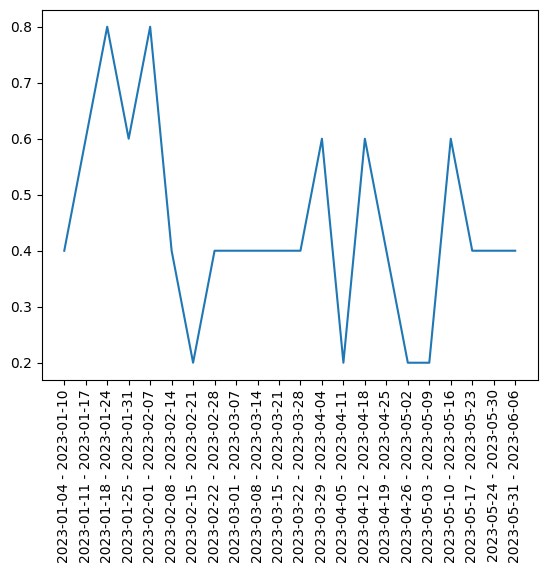

In [ ]:
plt.plot(cor_list.keys(), cor_list.values())
print(cor_list)
plt.xticks(rotation='vertical')  # This rotates the x-axis labels

plt.show()

In [ ]:
def add_split_data(data):
  pass

In [ ]:
def initialise_model(X_train):
  model = Sequential()
  model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
  model.add(LSTM(64))
  model.add(Dense(1,kernel_initializer="uniform",activation='linear'))

  # Compile and fit the model on 30 epochs
  model.compile(loss='mean_squared_error', optimizer='adam')

  return model

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def split_scale_data(data):

  X = data.drop(['Date', 'Adj Close'], axis=1)
  y = data['Adj Close']

  # Rescale the features
  scaler = MinMaxScaler(feature_range=(0, 1))
  X = scaler.fit_transform(X)

  # Split the data into train and test datasets
  X_train = X
  y_train = y

  # Reshape the inputs for LSTM
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))



<ipython-input-32-b3515ef0c9da>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data['sentiment'] == 'Sentiment: 0.']['sentiment'] = 0


In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Attention, Input
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model

es = EarlyStopping(patience=4, monitor='loss')

set_path = "/content/sample_data/"


def first_rnn(date):
  AAPL_data = yf.download('AAPL','2019-01-01', date)

  AAPL_sent = pd.read_csv(set_path+"reddit_sentimental_AAPL.csv")
  AAPL_sent = AAPL_sent[['created_at', 'content', 'score', 'sentiment']].rename(columns={'created_at': "Date", "score": "exposure"})
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])


  AAPL_with_sent = AAPL_data.merge(AAPL_sent, how='left', on='Date')
  AAPL_with_sent['exposure'] = AAPL_with_sent['exposure'].fillna(0)

  AAPL_grouped = AAPL_with_sent.loc[AAPL_with_sent.groupby("Date")["exposure"].idxmax()]
  AAPL_grouped['sentiment'] = AAPL_grouped['sentiment'].fillna(0)


  data = AAPL_grouped.drop(columns=['content'])


  # Set 'Adj Close' column as y and remaining columns as features X
  X = data.drop(columns=['Date', 'Adj Close'])
  X = X.astype(float)
  y = data['Adj Close']


  # Normalize features to between 0 and 1
  scaler = MinMaxScaler(feature_range=(0, 1))
  X = scaler.fit_transform(X)

  # Normalize target variable separately
  y_scaler = MinMaxScaler(feature_range=(0, 1))
  y = y_scaler.fit_transform(np.array(y).reshape(-1, 1))

  # Function to create sequences
  def create_sequences(X, y, time_steps=1):
      Xs, ys = [], []
      for i in range(len(X) - time_steps):
          Xs.append(X[i:(i + time_steps)])
          ys.append(y[i + time_steps])
      return np.array(Xs), np.array(ys)

  time_steps = 5  # change to whatever value you want
  X, y = create_sequences(X, y, time_steps)

  # Split data into train and test
  train_size = len(X) - 1  # use all data except the last instance
  X_train, X_test = X[:train_size], X[train_size:]
  y_train, y_test = y[:train_size], y[train_size:]

  # Build the LSTM model
  sequence_length = X_train.shape[1]
  feature_length = X_train.shape[2]

  # Define the layers
  inputs = Input(shape=(sequence_length, feature_length))

  lstm_out, hidden_h, hidden_c = LSTM(64, return_sequences=True, return_state=True)(inputs)
  attention = Attention()([lstm_out, lstm_out])
  lstm_out2 = LSTM(64, return_sequences=True)(attention)
  lstm_out3 = LSTM(32)(lstm_out2)

  outputs = Dense(1, kernel_initializer="uniform", activation='linear')(lstm_out3)

  # Define the model
  model = Model(inputs=inputs, outputs=outputs)

  # Compile the model
  model.compile(optimizer='adam', loss='mean_absolute_error')

  # Fit the model
  model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0, callbacks=[es])

  # Predict the future price
  predicted_price = model.predict(X_test)

  # Inverse the scaling to get true predicted price
  predicted_price = y_scaler.inverse_transform(predicted_price)

  actual_price = y_scaler.inverse_transform(y_test)

  # Reverse the scaling on the training set
  y_train_inversed = y_scaler.inverse_transform(y_train)

  # Get the price from the day before the prediction (the last price in the training set)
  price_day_before = y_train_inversed[-1]

  # Calculate the differences
  predicted_diff = (predicted_price[0] - price_day_before)[0]
  actual_diff = (actual_price[0] - price_day_before)[0]

  print("Price from the day before the prediction: ", price_day_before)
  print("Predicted difference: ", predicted_diff)
  print("Actual difference: ", actual_diff)

  print("Actual price: ", actual_price[0][0])
  print("Predicted price: ", predicted_price[0][0])

  if predicted_diff > 0:
      pred_action = 'buy'
  else:
      pred_action = 'sell'


  if actual_diff > 0:
      cor_action = 'buy'
  else:
      cor_action = 'sell'

  return cor_action == pred_action, pred_action, price_day_before[0], actual_price[0][0]



def create_date_list(start_date, end_date, batch_size):
    date_format = "%Y-%m-%d"
    date_batches = []
    current_batch = []

    start = datetime.strptime(start_date, date_format)
    end = datetime.strptime(end_date, date_format)

    current_date = end
    while current_date >= start:
        if current_date.weekday() < 5:  # If it's a weekday
            current_batch.append(current_date.strftime(date_format))
            if len(current_batch) == batch_size:
                date_batches.append(current_batch)
                current_batch = []
        current_date -= timedelta(days=1)

    # Reverse each individual batch so the dates are in ascending order
    date_batches = [batch[::-1] for batch in date_batches]

    return date_batches[::-1]


correct_ = 0
wrong_ = 0
money = 10000
stocks = 0
short_stocks = 0 # holds number of stocks that are short sold

cor_list = {}

for dates in create_date_list('2023-01-03', '2023-06-06', 5):
  print(dates)
  if dates:
    for date in dates:
      result, action, stock_prev, stock_now = first_rnn(date)
      if result == True:
        correct_ += 1
      else:
        wrong_ += 1
      print(action)
      if action == 'buy':
        if short_stocks > 0:  # Cover short position
            cost_to_cover = short_stocks*stock_prev
            if cost_to_cover <= money:  # Ensure you have enough money to cover
                money -= cost_to_cover
                short_stocks = 0
        if money > 0 and short_stocks == 0:  # You can't buy normally if you have an open short position
          stocks += money/stock_prev
          money = 0
      elif action == 'sell':
        if stocks > 0:  # Normal sell
            money += stocks * stock_prev
            stocks = 0
        if stocks == 0 and short_stocks == 0:  # Short sell
            short_stocks += money/stock_prev
            money += short_stocks*stock_prev  # You sold borrowed stocks, so add this money to your balance

      print(f"Current Money: {money}")
      print(f"Current Stocks: {stocks}")
      print(f"Short Stocks: {short_stocks}")
    cor_list[f'{dates[0]} - {dates[-1]}'] = correct_/len(dates)
    correct_ = 0

if stocks > 0:  # If you have stocks
    money += stocks * stock_now  # Sell all stocks at current price
elif short_stocks > 0:  # If you have short stocks
    money -= short_stocks * stock_now  # Buy back all short stocks at current price

print(money)



['2023-01-04', '2023-01-05', '2023-01-06', '2023-01-09', '2023-01-10']
[*********************100%***********************]  1 of 1 completed


<ipython-input-45-7ce440c81b3f>:18: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])


1/1 [==============================] - 1s 1s/step
Price from the day before the prediction:  [129.55271912]
Predicted difference:  1.3371429443359375
Actual difference:  -4.84588623046875
Actual price:  124.70683288574219
Predicted price:  130.88986
buy
Current Money: 0
Current Stocks: 77.18865391802262
Short Stocks: 0
[*********************100%***********************]  1 of 1 completed


<ipython-input-45-7ce440c81b3f>:18: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])


1/1 [==============================] - 1s 1s/step
Price from the day before the prediction:  [124.70683289]
Predicted difference:  1.1229782104492188
Actual difference:  1.2862625122070312
Actual price:  125.99309539794922
Predicted price:  125.82981
buy
Current Money: 0
Current Stocks: 77.18865391802262
Short Stocks: 0
[*********************100%***********************]  1 of 1 completed


<ipython-input-45-7ce440c81b3f>:18: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])


1/1 [==============================] - 1s 1s/step
Price from the day before the prediction:  [125.9930954]
Predicted difference:  -1.023162841796875
Actual difference:  -1.3361129760742188
Actual price:  124.656982421875
Predicted price:  124.96993
sell
Current Money: 19450.474873465424
Current Stocks: 0
Short Stocks: 77.18865391802262
[*********************100%***********************]  1 of 1 completed


<ipython-input-45-7ce440c81b3f>:18: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])


1/1 [==============================] - 2s 2s/step
Price from the day before the prediction:  [124.65698242]
Predicted difference:  2.0331039428710938
Actual difference:  4.586639404296875
Actual price:  129.24362182617188
Predicted price:  126.69009
buy
Current Money: 0
Current Stocks: 78.84331874468339
Short Stocks: 0
[*********************100%***********************]  1 of 1 completed


<ipython-input-45-7ce440c81b3f>:18: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])


1/1 [==============================] - 1s 1s/step
Price from the day before the prediction:  [129.24362183]
Predicted difference:  -6.359703063964844
Actual difference:  0.5284576416015625
Actual price:  129.77207946777344
Predicted price:  122.88392
sell
Current Money: 20379.992142716375
Current Stocks: 0
Short Stocks: 78.84331874468339
['2023-01-11', '2023-01-12', '2023-01-13', '2023-01-16', '2023-01-17']
[*********************100%***********************]  1 of 1 completed


<ipython-input-45-7ce440c81b3f>:18: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])


1/1 [==============================] - 1s 1s/step
Price from the day before the prediction:  [129.77207947]
Predicted difference:  -5.365104675292969
Actual difference:  0.5783233642578125
Actual price:  130.35040283203125
Predicted price:  124.406975
sell
Current Money: 20379.992142716375
Current Stocks: 0
Short Stocks: 78.84331874468339
[*********************100%***********************]  1 of 1 completed


<ipython-input-45-7ce440c81b3f>:18: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])


1/1 [==============================] - 1s 1s/step
Price from the day before the prediction:  [130.35040283]
Predicted difference:  -3.4502944946289062
Actual difference:  2.751983642578125
Actual price:  133.10238647460938
Predicted price:  126.90011
sell
Current Money: 20379.992142716375
Current Stocks: 0
Short Stocks: 78.84331874468339
[*********************100%***********************]  1 of 1 completed


<ipython-input-45-7ce440c81b3f>:18: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])


1/1 [==============================] - 1s 1s/step
Price from the day before the prediction:  [133.10238647]
Predicted difference:  -2.79498291015625
Actual difference:  -0.0797576904296875
Actual price:  133.0226287841797
Predicted price:  130.3074
sell
Current Money: 20379.992142716375
Current Stocks: 0
Short Stocks: 78.84331874468339
[*********************100%***********************]  1 of 1 completed


<ipython-input-45-7ce440c81b3f>:18: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])


1/1 [==============================] - 1s 1s/step
Price from the day before the prediction:  [133.02261353]
Predicted difference:  -0.7167968750000284
Actual difference:  1.3460845947265625
Actual price:  134.36869812011722
Predicted price:  132.30582
sell
Current Money: 20379.992142716375
Current Stocks: 0
Short Stocks: 78.84331874468339
[*********************100%***********************]  1 of 1 completed


<ipython-input-45-7ce440c81b3f>:18: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
Exception ignored in: <function _xla_gc_callback at 0x7fc059595630>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 103, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


1/1 [==============================] - 3s 3s/step
Price from the day before the prediction:  [133.02262878]
Predicted difference:  -4.146942138671875
Actual difference:  1.3460693359375
Actual price:  134.3686981201172
Predicted price:  128.87569
sell
Current Money: 20379.992142716375
Current Stocks: 0
Short Stocks: 78.84331874468339
['2023-01-18', '2023-01-19', '2023-01-20', '2023-01-23', '2023-01-24']
[*********************100%***********************]  1 of 1 completed


<ipython-input-45-7ce440c81b3f>:18: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
Exception ignored in: <function _xla_gc_callback at 0x7fc059595630>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 103, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


RuntimeError: ignored

{'2023-01-04 - 2023-01-10': 0.8, '2023-01-11 - 2023-01-17': 0.8, '2023-01-18 - 2023-01-24': 0.4, '2023-01-25 - 2023-01-31': 0.4, '2023-02-01 - 2023-02-07': 0.4, '2023-02-08 - 2023-02-14': 0.4, '2023-02-15 - 2023-02-21': 1.0, '2023-02-22 - 2023-02-28': 0.6, '2023-03-01 - 2023-03-07': 0.6, '2023-03-08 - 2023-03-14': 0.6, '2023-03-15 - 2023-03-21': 0.2, '2023-03-22 - 2023-03-28': 0.4, '2023-03-29 - 2023-04-04': 0.2, '2023-04-05 - 2023-04-11': 0.4, '2023-04-12 - 2023-04-18': 0.4, '2023-04-19 - 2023-04-25': 0.2, '2023-04-26 - 2023-05-02': 0.4, '2023-05-03 - 2023-05-09': 0.6, '2023-05-10 - 2023-05-16': 0.4, '2023-05-17 - 2023-05-23': 1.0, '2023-05-24 - 2023-05-30': 0.0, '2023-05-31 - 2023-06-06': 0.4}
0.4818181818181818


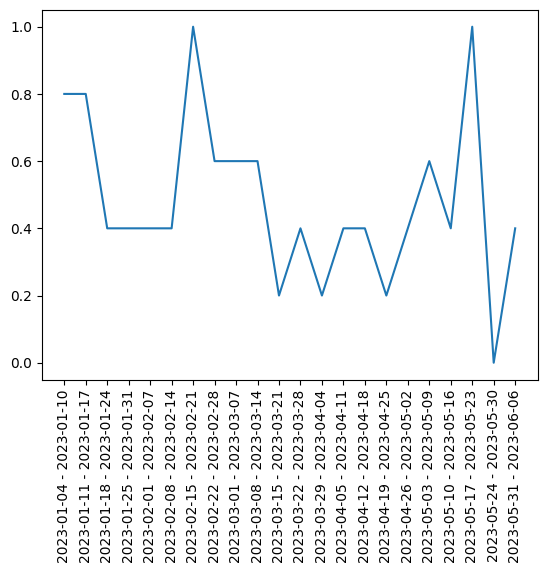

In [ ]:
plt.plot(cor_list.keys(), cor_list.values())
print(cor_list)
plt.xticks(rotation='vertical')  # This rotates the x-axis labels
print(sum(cor_list.values())/len(cor_list.values()))
plt.show()

In [ ]:
data = yf.download('AAPL','2019-01-01', '2023-01-06')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,38.722500,39.712502,38.557499,39.480000,37.994499,148158800
2019-01-03,35.994999,36.430000,35.500000,35.547501,34.209969,365248800
2019-01-04,36.132500,37.137501,35.950001,37.064999,35.670361,234428400
2019-01-07,37.174999,37.207500,36.474998,36.982498,35.590965,219111200
2019-01-08,37.389999,37.955002,37.130001,37.687500,36.269436,164101200
...,...,...,...,...,...,...
2022-12-29,127.989998,130.479996,127.730003,129.610001,129.233658,75703700
2022-12-30,128.410004,129.949997,127.430000,129.929993,129.552719,77034200
2023-01-03,130.279999,130.899994,124.169998,125.070000,124.706833,112117500


In [ ]:

aapl_fa = pd.read_csv(set_path+'AAPL_fa.csv').drop(columns='Close')
aapl_fa['Date'] = pd.to_datetime(aapl_fa['Date'])
aapl = data.merge(aapl_fa, how='left', on='Date')

aapl = aapl.fillna(0)

aapl.drop(columns='')

,symbol,content,created_at,score,sentiment
0,AAPL,bears feasting on aapl next week confirmed,26/09/2020,21050,0.00
1,AAPL,someone purchased $. billion worth of $aapl st...,05/12/2022,20769,0.75
2,AAPL,apple started wwiii so that phones would be de...,04/01/2020,15905,-0.75
3,AAPL,aapl's innovative product strategy,03/01/2019,11880,0.75
4,AAPL,"warren buffett: ‘if someone offered you $, to ...",12/04/2023,10883,0.25
...,...,...,...,...,...
400,AAPL,aapl earnings release bear case : msft missed ...,01/05/2023,106,0.87
401,AAPL,aapl loss porn,17/09/2020,105,-1.00
402,AAPL,the stock market should not bottom until $aapl...,23/12/2022,104,-0.45
403,AAPL,aapl yolo update. i was down k just a few week...,28/12/2022,103,0.25


In [4]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Attention, Input
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model

es = EarlyStopping(patience=4, monitor='loss')

def walk_forward_rnn(date, train_size=250):
  AAPL_data = yf.download('AAPL','2019-01-01', date)

  AAPL_sent = pd.read_csv(set_path+"reddit_sentimental_AAPL.csv")
  AAPL_sent = AAPL_sent[['created_at', 'content', 'score', 'sentiment']].rename(columns={'created_at': "Date", "score": "exposure"})
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])


  AAPL_with_sent = AAPL_data.merge(AAPL_sent, how='left', on='Date')
  AAPL_with_sent['exposure'] = AAPL_with_sent['exposure'].fillna(0)

  AAPL_grouped = AAPL_with_sent.loc[AAPL_with_sent.groupby("Date")["exposure"].idxmax()]
  AAPL_grouped['sentiment'] = AAPL_grouped['sentiment'].fillna(0)
  AAPL_grouped = AAPL_grouped.drop(columns=['content'])

  AAPL_fa = pd.read_csv(set_path+'AAPL_fa.csv').drop(columns='Close')
  AAPL_fa['Date'] = pd.to_datetime(AAPL_fa['Date'])
  AAPL = AAPL_grouped.merge(AAPL_fa, how='left', on='Date')
  AAPL = AAPL.fillna(0)

  data = AAPL

  """
  Optional drops
  """

  data = data.drop(columns=['Apple Quarterly Operating Margin', 'Apple Quarterly Net Income\n(Millions of US $)'])

  # Set 'Adj Close' column as y and remaining columns as features X
  X = data.drop(columns=['Date', 'Adj Close'])
  X = X.astype(float)
  y = data['Adj Close']
  y_diff = y.diff().dropna()

  # Normalize features to between 0 and 1
  scaler = MinMaxScaler(feature_range=(0, 1))
  X_scaled = scaler.fit_transform(X)

  # Normalize target variable separately
  y_scaler = MinMaxScaler(feature_range=(0, 1))
  y_diff_scaled = y_scaler.fit_transform(np.array(y_diff).reshape(-1, 1))

  # Function to create sequences
  def create_sequences(X, y, time_steps=5):
      Xs, ys = [], []
      for i in range(len(X) - (time_steps + 1)):
          Xs.append(X[i:(i + time_steps)])
          ys.append(y[i + time_steps])
      return np.array(Xs), np.array(ys)

  time_steps = 10  # change to whatever value you want
  X_seq, y_diff_seq = create_sequences(X_scaled, y_diff_scaled, time_steps)

  for i in range(train_size, len(X_seq)):
      X_train, X_test = X_seq[:i], X_seq[i:i+1]
      y_train, y_test = y_diff_seq[:i], y_diff_seq[i:i+1]

  # Build the LSTM model
  sequence_length = X_train.shape[1]
  feature_length = X_train.shape[2]

  # Define the layers
  inputs = Input(shape=(sequence_length, feature_length))

  lstm_out, hidden_h, hidden_c = LSTM(64, return_sequences=True, return_state=True)(inputs)
  attention = Attention()([lstm_out, lstm_out])
  lstm_out2 = LSTM(64, return_sequences=True)(attention)
  lstm_out3 = LSTM(32)(lstm_out2)

  outputs = Dense(1, kernel_initializer="uniform", activation='linear')(lstm_out3)

  # Define the model
  model = Model(inputs=inputs, outputs=outputs)

  # Compile the model
  model.compile(optimizer='adam', loss='mean_absolute_error')

  # Fit the model
  model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=0, callbacks=[es])

  # Predict the future price change
  predicted_diff = model.predict(X_test)

  # Inverse the scaling to get true predicted change
  predicted_diff = y_scaler.inverse_transform(predicted_diff)[0][0]

  # The actual change is just the y_test
  actual_diff = y_scaler.inverse_transform(y_test)[0][0]

  # Get the price from the day before the prediction (the last price in the training set)
  price_day_before = y.iloc[-2]

  # The predicted price is the price from the day before plus the predicted change
  predicted_price = price_day_before + predicted_diff

  # The actual price is the price from the day before plus the actual change
  actual_price = price_day_before + actual_diff

  print("Price from the day before the prediction: ", price_day_before)
  print("Predicted difference: ", predicted_diff)
  print("Actual difference: ", actual_diff)

  print("Actual price: ", actual_price)
  print("Predicted price: ", predicted_price)

  if predicted_diff > 0:
      pred_action = 'buy'
  else:
      pred_action = 'sell'


  if actual_diff > 0:
      cor_action = 'buy'
  else:
      cor_action = 'sell'

  return cor_action == pred_action, pred_action, price_day_before, actual_price




def create_date_list(start_date, end_date, batch_size):
    date_format = "%Y-%m-%d"
    date_batches = []
    current_batch = []

    start = datetime.strptime(start_date, date_format)
    end = datetime.strptime(end_date, date_format)

    current_date = end
    while current_date >= start:
        if current_date.weekday() < 5:  # If it's a weekday
            current_batch.append(current_date.strftime(date_format))
            if len(current_batch) == batch_size:
                date_batches.append(current_batch)
                current_batch = []
        current_date -= timedelta(days=1)

    # Reverse each individual batch so the dates are in ascending order
    date_batches = [batch[::-1] for batch in date_batches]

    return date_batches[::-1]

correct_all = 0
wrong_all = 0
correct_ = 0
wrong_ = 0
money = 10000
stocks = 0
short_stocks = 0 # holds number of stocks that are short sold

cor_list = {}

for dates in create_date_list('2023-03-06', '2023-06-06', 5):
  print(dates)
  if dates:
    for date in dates:
      print(date)
      result, action, stock_prev, stock_now = walk_forward_rnn(date, 125)
      if result == True:
        correct_ += 1
        correct_all += 1
      else:
        wrong_ += 1
        wrong_all += 1
      print(action)
      if action == 'buy':
        if short_stocks > 0:  # Cover short position
            cost_to_cover = short_stocks*stock_prev
            if cost_to_cover <= money:  # Ensure you have enough money to cover
                money -= cost_to_cover
                short_stocks = 0
        if money > 0 and short_stocks == 0:  # You can't buy normally if you have an open short position
          stocks += money/stock_prev
          money = 0
      elif action == 'sell':
        if stocks > 0:  # Normal sell
            money += stocks * stock_prev
            stocks = 0
        if stocks == 0 and short_stocks == 0:  # Short sell
            short_stocks += money/stock_prev
            money += short_stocks*stock_prev  # You sold borrowed stocks, so add this money to your balance

      print(f"Current Money: {money}")
      print(f"Current Stocks: {stocks}")
      print(f"Short Stocks: {short_stocks}")
    cor_list[f'{dates[0]} - {dates[-1]}'] = correct_/len(dates)
    correct_ = 0

if stocks > 0:  # If you have stocks
    money += stocks * stock_now  # Sell all stocks at current price
elif short_stocks > 0:  # If you have short stocks
    money -= short_stocks * stock_now  # Buy back all short stocks at current price

print(f"Final money: €{money}")
print(f"Total Correct: {correct_all}")
print(f"Total Wrong: {wrong_all}")
print(f"Ration: {(correct_all/(wrong_all+correct_all))*100}%")



"""
06-06-2023

Without drops
Final money: €11405.115933344177
Total Correct: 32
Total Wrong: 28
Ration: 53.33%
"""

"""
06-06-2023

With drops:
- Apple Quarterly Operating Margin
- Apple Quarterly Net Income\n(Millions of US $)

Final money: €9986.94641138851
Total Correct: 33
Total Wrong: 27
Ration: 55.00000000000001%
"""

['2023-03-08', '2023-03-09', '2023-03-10', '2023-03-13', '2023-03-14']
2023-03-08
[*********************100%***********************]  1 of 1 completed


<ipython-input-4-7211f3f348c9>:15: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])


FileNotFoundError: ignored

{'2023-03-15 - 2023-03-28': 0.9, '2023-03-29 - 2023-04-11': 0.5, '2023-04-12 - 2023-04-25': 0.5, '2023-04-26 - 2023-05-09': 0.1, '2023-05-10 - 2023-05-23': 0.6, '2023-05-24 - 2023-06-06': 0.7}
0.5499999999999999


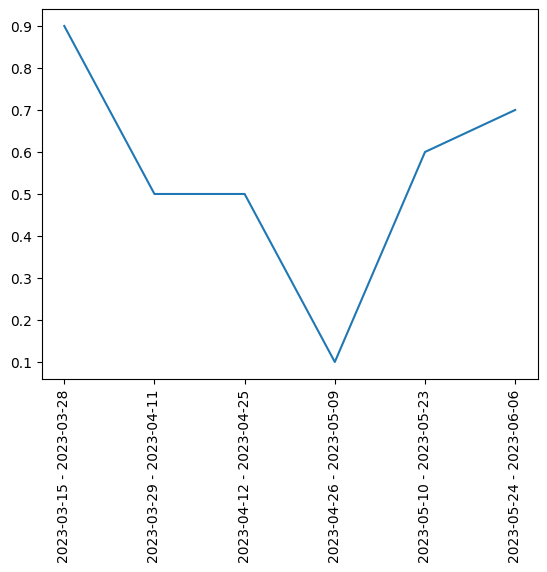

In [ ]:
plt.plot(cor_list.keys(), cor_list.values())
print(cor_list)
plt.xticks(rotation='vertical')  # This rotates the x-axis labels
print(sum(cor_list.values())/len(cor_list.values()))
plt.show()

In [ ]:
set_path = "/content/sample_data/"
AAPL_event = pd.read_csv(set_path+'whether_releases_df.csv')
AAPL_event

,Date,Entry
0,2018-06-12,0.0
1,2018-06-13,0.0
2,2018-06-14,0.0
3,2018-06-15,0.0
4,2018-06-18,0.0
...,...,...
1249,2023-05-30,0.0
1250,2023-05-31,0.0
1251,2023-06-01,0.0
1252,2023-06-02,0.0


{'2023-03-15 - 2023-03-21': 0.8, '2023-03-22 - 2023-03-28': 0.6, '2023-03-29 - 2023-04-04': 0.8, '2023-04-05 - 2023-04-11': 0.4, '2023-04-12 - 2023-04-18': 0.6, '2023-04-19 - 2023-04-25': 0.6, '2023-04-26 - 2023-05-02': 0.6, '2023-05-03 - 2023-05-09': 0.2, '2023-05-10 - 2023-05-16': 0.8, '2023-05-17 - 2023-05-23': 0.6, '2023-05-24 - 2023-05-30': 1.0, '2023-05-31 - 2023-06-06': 0.6}
0.6333333333333333


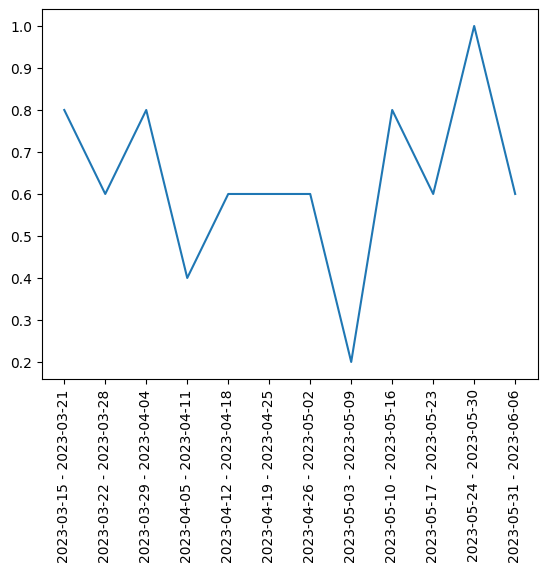

In [22]:
plt.plot(cor_list.keys(), cor_list.values())
print(cor_list)
plt.xticks(rotation='vertical')  # This rotates the x-axis labels
print(sum(cor_list.values())/len(cor_list.values()))
plt.show()

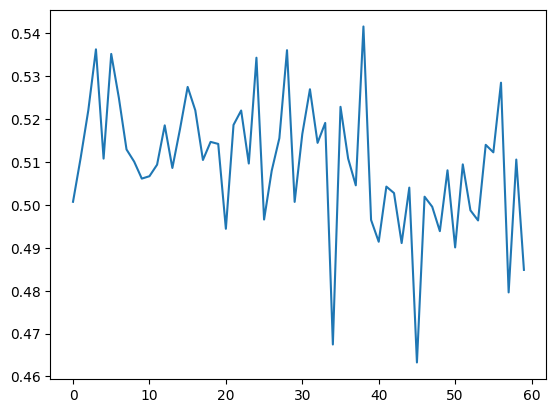

In [24]:
plt.plot(probabilities)
# zipped = list(zip(range(len(correct_list)), correct_list))
# zipped2 = list(zip(range(len(probabilities)), probabilities))
# for x in zipped2:
#   if x[1] > 0.49:
#     print(x)
#     print(zipped[x[0]])
# # plt.scatter(range(len(correct_list)), correct_list)

In [30]:
AAPL_data = yf.download('AAPL','2018-01-01', "2023-06-13")

AAPL_sent = pd.read_csv(set_path+"reddit_sentimental_AAPL.csv")
AAPL_sent = AAPL_sent[['created_at', 'content', 'score', 'sentiment']].rename(columns={'created_at': "Date", "score": "exposure"})
AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])

AAPL_with_sent = AAPL_data.merge(AAPL_sent, how='left', on='Date')
AAPL_with_sent['exposure'] = AAPL_with_sent['exposure'].fillna(0)

AAPL_grouped = AAPL_with_sent.loc[AAPL_with_sent.groupby("Date")["exposure"].idxmax()]
AAPL_grouped['sentiment'] = AAPL_grouped['sentiment'].fillna(0)
AAPL_grouped = AAPL_grouped.drop(columns=['content'])

AAPL_fa = pd.read_csv(set_path+'df_aapl_final.csv').drop(columns='Close')
AAPL_fa['Date'] = pd.to_datetime(AAPL_fa['Date'])

AAPL_event = pd.read_csv(set_path+'whether_releases_df.csv')
AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])

AAPL = AAPL_grouped.merge(AAPL_fa, how='left', on='Date')
AAPL = AAPL.merge(AAPL_event, how='left', on='Date')
AAPL = AAPL.fillna(0)

AAPL_vix = pd.read_csv(set_path+'vix_weekday_df.csv')
AAPL_vix['Date'] = pd.to_datetime(AAPL_vix['Date'])
AAPL = AAPL.merge(AAPL_vix, how='left', on='Date')
AAPL = AAPL.fillna(0)

AAPL_pce = pd.read_csv(set_path+'PCE_weekday_df.csv')
AAPL_pce['Date'] = pd.to_datetime(AAPL_pce['Date'])
AAPL = AAPL.merge(AAPL_pce, how='left', on='Date')
AAPL = AAPL.fillna(0)

AAPL['sent_exp'] = AAPL['sentiment'] * AAPL['exposure']

AAPL = AAPL.drop(columns=['sentiment', 'exposure'])

data = AAPL

# Calculate the correlation matrix
correlation_matrix = data.corr()

# Get the correlation of each feature with the target
correlations = correlation_matrix['Adj Close'].sort_values(ascending=False)

# Print the correlations
print(correlations)


data.to_csv(f"{set_path}present.csv", index=False)

[*********************100%***********************]  1 of 1 completed


<ipython-input-30-6b6b27ade687>:5: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])


Adj Close                                         1.000000
Close                                             0.999956
Low                                               0.999633
High                                              0.999617
Open                                              0.999234
PE                                                0.781798
Apple Quarterly EPS                               0.764860
Apple Quarterly Net Income\n(Millions of US $)    0.712058
Apple Quarterly Revenue\n(Millions of US $)       0.681894
PCE                                               0.595639
Apple Quarterly Operating Margin                  0.531907
CPI                                               0.508610
VIX                                               0.330169
sent_exp                                          0.051074
Interest                                          0.029525
Entry                                             0.004419
Volume                                           -0.3954

<ipython-input-30-6b6b27ade687>:18: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])
<ipython-input-30-6b6b27ade687>:41: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


In [27]:
from sklearn.ensemble import RandomForestRegressor


X = data.drop(columns=['Date', 'Adj Close'])
X = X.astype(float)
y = data['Adj Close']
y_diff = y.diff().dropna()

# Normalize features to between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)
X_trimmed = X_scaled[1:]

# Normalize target variable separately
y_scaler = MinMaxScaler(feature_range=(0, 1))
y_diff_scaled = y_scaler.fit_transform(np.array(y_diff).reshape(-1, 1))

# Fit a RandomForestRegressor to your data
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(X_trimmed, y_diff_scaled.ravel())

# Get the importance of each feature
importances = rf.feature_importances_
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})

# Print feature importances in descending order
print(feature_importances.sort_values('importance', ascending=False))


                                           feature  importance
4                                           Volume    0.182113
0                                             Open    0.168046
13                                             VIX    0.150946
3                                            Close    0.136541
7                                               PE    0.098152
1                                             High    0.051143
2                                              Low    0.050508
15                                        sent_exp    0.034222
14                                             PCE    0.033142
6                                              CPI    0.022423
5                                         Interest    0.021947
10                Apple Quarterly Operating Margin    0.019483
8      Apple Quarterly Revenue\n(Millions of US $)    0.010451
9   Apple Quarterly Net Income\n(Millions of US $)    0.009557
11                             Apple Quarterly EPS    0

In [17]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

# We need to standardize the data for Lasso
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# RFE with cross-validation using RandomForest
rfecv = RFECV(estimator=RandomForestRegressor(n_estimators=100, random_state=0), step=1, cv=5, scoring='neg_mean_squared_error')
rfecv.fit(X_trimmed, y_diff_scaled.ravel())
X_trimmed = X_scaled[1:]

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))

# LassoCV
lasso = LassoCV(cv=5, random_state=0)
lasso.fit(X_trimmed, y_diff_scaled.ravel())

# Get the coefficients of the Lasso model
lasso_coefs = pd.DataFrame({'feature': X.columns, 'coef': lasso.coef_})

# Print features with non-zero coefficients
print(lasso_coefs[lasso_coefs.coef != 0])


Optimal number of features: 2
Selected features: ['Open', 'Close']


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022482945005446453, tolerance: 0.0012811974770581248
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0088202227255465, tolerance: 0.0012811974770581248
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012627406636285698, tolerance: 0.0012811974770581248
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py

                                           feature      coef
0                                             Open -1.490083
1                                             High  0.329054
2                                              Low  0.089567
3                                            Close  1.068539
4                                           Volume  0.000977
5                                         exposure -0.003718
6                                        sentiment  0.004191
8                                              CPI  0.005504
9                                               PE  0.013858
11  Apple Quarterly Net Income\n(Millions of US $) -0.004529
13                             Apple Quarterly EPS -0.000688
14                                           Entry -0.000851
15                                             VIX -0.014698


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.26607086939556446, tolerance: 0.0008173207644895128
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2625004064599701, tolerance: 0.0008173207644895128
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.25928165559977256, tolerance: 0.0008173207644895128
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:61

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
aapl.drop(columns=['Apple Quarterly Operating Margin', 'Apple Quarterly Net Income\n(Millions of US $)'])

,Date,Open,High,Low,Close,Adj Close,Volume,exposure,sentiment,Interest,CPI,PE,Apple Quarterly Revenue\n(Millions of US $),Apple Quarterly EPS
0,2019-01-02,38.722500,39.712502,38.557499,39.480000,37.994495,148158800,0.038567,-0.75,0.0240,251.712,6.950704,84.310,1.05
1,2019-01-03,35.994999,36.430000,35.500000,35.547501,34.209969,365248800,0.572006,0.75,0.0240,251.712,6.258363,84.310,1.05
2,2019-01-04,36.132500,37.137501,35.950001,37.064999,35.670361,234428400,0.016948,-0.45,0.0240,251.712,6.525528,84.310,1.05
3,2019-01-07,37.174999,37.207500,36.474998,36.982498,35.590961,219111200,0.018393,0.45,0.0240,251.712,6.511003,84.310,1.05
4,2019-01-08,37.389999,37.955002,37.130001,37.687500,36.269440,164101200,0.018441,0.75,0.0240,251.712,6.635123,84.310,1.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1112,2023-06-02,181.029999,181.779999,179.259995,180.949997,180.949997,61945900,0.000000,0,0.0508,303.363,30.721561,94.836,1.52
1113,2023-06-05,182.630005,184.949997,178.039993,179.580002,179.580002,121946500,0.032356,0.95,0.0508,303.363,30.488965,94.836,1.52
1114,2023-06-06,179.970001,180.119995,177.429993,179.210007,179.210007,64848400,0.319996,0.75,0.0508,303.363,30.426147,94.836,1.52
1115,2023-06-07,178.440002,181.210007,177.320007,177.820007,177.820007,61944600,0.089557,0.00,0.0000,0.000,0.000000,0.000,0.00


In [ ]:
file_path = 'data_transformation.ipynb'
absolute_path = os.path.abspath(file_path)
absolute_path

'/content/data_transformation.ipynb'

In [ ]:
import os

set_path = "/content/drive/MyDrive/SMA/hist/"

# Get a list of all files in the directory
all_files = os.listdir(set_path)

# Filter out the CSV files
csv_files = [file for file in all_files if file.endswith('.csv')]

# Now csv_files is a list of all CSV filenames in the directory


"""
TSLA, AMD, AAPL, AMZN, SOFI, COIN, LCID, INTC, NVDA, MVIS, GOOGL, RIVN, FCEL, MSFT, GTLB, LYFT
"""

In [ ]:
set_path = "/content/drive/MyDrive/SMA/hist/"

high_vol = dict()

for cur_csv in csv_files:
  data = pd.read_csv(set_path + cur_csv)

  vol = max(data['Volume'])
  symbol = cur_csv[:-4]
  high_vol[symbol] = vol

  if len(high_vol) > 10:
    del_key = min(high_vol, key=high_vol.get)
    del high_vol[del_key]

print(high_vol)

ParserError: ignored

In [ ]:
set_path = "/content/drive/MyDrive/SMA/hist/"
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

correct = 0
wrong = 0

es = EarlyStopping(patience=4, monitor='loss')

for cur_csv in csv_files:


  test_data = pd.read_csv(set_path + cur_csv)

  test_data['Change'] = test_data['Close'] - test_data['Open']

  test_data['P_V'] = test_data['Close'] / test_data['Volume']

  test_data['Range'] = test_data['High'] - test_data['Low']

  test_data.drop(['High', 'Low', 'Close', 'Volume', 'Open'], axis=1)

  es = EarlyStopping(patience=4, monitor="loss")

  X = test_data.drop(['Date', 'Adj Close'], axis=1)
  y = test_data['Adj Close']

  # Rescale the features
  scaler = MinMaxScaler(feature_range=(0, 1))
  X = scaler.fit_transform(X)

  # Split the data into train and test datasets
  X_train = X[:-1]
  y_train = y[:-1]

  # Reshape the inputs for LSTM
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

  # Build the LSTM model
  model = Sequential()
  model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
  model.add(LSTM(64))
  model.add(Dense(1,kernel_initializer="uniform",activation='linear'))

  # Compile and fit the model on 30 epochs
  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1, callbacks=[es])

  # Use the last day's data as input for predicting the next day's 'Adj Close' value
  X_last_day = X[-1].reshape((1, X.shape[1], 1))
  next_day_prediction = model.predict(X_last_day)[0][0]


  prev = min(y_train[-1:])

  print(f"Next day's predicted 'Adj Close' value: {next_day_prediction}")
  print(f'Previous: {prev}')
  print(f'Forecast: {next_day_prediction}')



  print(prev)
  pred_change = min(y_train[-1:] - next_day_prediction)

  if abs(pred_change) > abs(prev * 0.005) and pred_change > 0:
    pred_action = 'buy'
  elif abs(pred_change) < abs(prev * 0.005):
    pred_action = 'nothing'
  elif abs(pred_change) > abs(prev * 0.005) and pred_change < 0:
    pred_action = 'sell'

  # Print the actual last value
  print(f'Previous: {prev}')
  print(f'Actual: {min(y[-1:])}')

  actual_change = min(prev - y_train[-1:])
  print(actual_change)

  if abs(actual_change) > abs(prev * 0.005) and actual_change > 0:
    cor_action = 'buy'
  elif abs(actual_change) < abs(prev * 0.005):
    cor_action = 'nothing'
  elif abs(actual_change) > abs(prev * 0.005) and actual_change < 0:
    cor_action = 'sell'

  if cor_action == pred_action:
    correct += 1
  else:
    wrong += 1

  print(f"Total: {correct + wrong}")
  print(f"Correct Ratio: {correct/ (correct + wrong)}")



Epoch 1/100
158/158 [==============================] - 5s 5ms/step - loss: 648.1033
Epoch 2/100
158/158 [==============================] - 1s 5ms/step - loss: 248.7288
Epoch 3/100
158/158 [==============================] - 1s 5ms/step - loss: 97.0285
Epoch 4/100
158/158 [==============================] - 1s 5ms/step - loss: 44.7555
Epoch 5/100
158/158 [==============================] - 1s 5ms/step - loss: 30.8525
Epoch 6/100
158/158 [==============================] - 1s 5ms/step - loss: 28.1135
Epoch 7/100
158/158 [==============================] - 1s 5ms/step - loss: 27.6824
Epoch 8/100
158/158 [==============================] - 1s 7ms/step - loss: 27.6398
Epoch 9/100
158/158 [==============================] - 1s 8ms/step - loss: 27.6335
Epoch 10/100
158/158 [==============================] - 1s 7ms/step - loss: 19.8515
Epoch 11/100
158/158 [==============================] - 1s 6ms/step - loss: 11.5540
Epoch 12/100
158/158 [==============================] - 1s 5ms/step - loss: 10.1067

ValueError: ignored

In [ ]:
set_path = "/content/drive/MyDrive/SMA/hist/"
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model


correct = 0
wrong = 0

for cur_csv in csv_files:


    test_data = pd.read_csv(set_path + cur_csv)

    time_series_data = test_data['Adj Close']

    if len(time_series_data) < 500:
      continue

    # Select all but the last row for fitting the model
    time_series_data_fit = time_series_data[:-1]

    # Fit an ARIMA model
    model = ARIMA(time_series_data_fit, order=(5,1,0))
    model_fit = model.fit()

    # Get the residuals
    residuals = model_fit.resid

    # Fit a GARCH model on the residuals of the ARIMA model
    garch_model = arch_model(residuals, vol="Garch", p=1, q=1)
    garch_model_fit = garch_model.fit()

    # Make a one-step ahead forecast
    garch_forecast = garch_model_fit.forecast(horizon=1)
    print(garch_forecast.variance[-1:])

    prev = time_series_data.iloc[-2]


    # Forecast the last value
    arima_forecast = model_fit.forecast(steps=1)
    print(f'Previous: {time_series_data.iloc[-2]}')
    print(f'Forecast: {arima_forecast}')

    pred_change = time_series_data.iloc[-2] - min(arima_forecast)

    print(pred_change)

    if abs(pred_change) > abs(prev * 0.005) and pred_change > 0:
      pred_action = 'buy'
    elif abs(pred_change) < abs(prev * 0.005):
      pred_action = 'nothing'
    elif abs(pred_change) > abs(prev * 0.005) and pred_change < 0:
      pred_action = 'sell'

    # Print the actual last value
    print(f'Previous: {time_series_data.iloc[-2]}')
    print(f'Actual: {time_series_data.iloc[-1]}')

    actual_change = time_series_data.iloc[-2] - time_series_data.iloc[-1]

    if abs(actual_change) > abs(prev * 0.005) and actual_change > 0:
      cor_action = 'buy'
    elif abs(actual_change) < abs(prev * 0.005):
      cor_action = 'nothing'
    elif abs(actual_change) > abs(prev * 0.005) and actual_change < 0:
      cor_action = 'sell'

    if cor_action == pred_action:
      correct += 1
    else:
      wrong += 1

    print(f"Total: {correct + wrong}")
    print(f"Correct Ratio: {correct/ (correct + wrong)}")


print(f"Correct: {correct}")
print(f"Wrong: {wrong}")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
## SIMPLE MOVING AVERAGE 20, 50, 200

test_data['SMA_20'] = test_data['Adj Close'].rolling(window=20).mean()
test_data['STD_20'] = test_data['Adj Close'].rolling(window=20).std()

test_data['SMA_50'] = test_data['Adj Close'].rolling(window=50).mean()
test_data['STD_50'] = test_data['Adj Close'].rolling(window=50).std()

test_data['SMA_200'] = test_data['Adj Close'].rolling(window=200).mean()
test_data['STD_200'] = test_data['Adj Close'].rolling(window=200).std()


test_data['Upper_Band_20'] = test_data['SMA_20'] + (test_data['STD_20'] * 2)
test_data['Lower_Band_20'] = test_data['SMA_20'] - (test_data['STD_20'] * 2)

test_data['Upper_Band_50'] = test_data['SMA_50'] + (test_data['STD_50'] * 2)
test_data['Lower_Band_50'] = test_data['SMA_50'] - (test_data['STD_50'] * 2)

test_data['Upper_Band_200'] = test_data['SMA_200'] + (test_data['STD_200'] * 2)
test_data['Lower_Band_200'] = test_data['SMA_200'] - (test_data['STD_200'] * 2)


In [ ]:
## MOVING AVERAGE CONVERGE DIVERGE

exp1 = test_data['Adj Close'].ewm(span=12, adjust=False).mean()
exp2 = test_data['Adj Close'].ewm(span=26, adjust=False).mean()
macd = exp1 - exp2
signal = macd.ewm(span=9, adjust=False).mean()
test_data['MACD'] = macd - signal

In [ ]:
delta = test_data['Adj Close'].diff()
delta = delta[1:]
up = delta.copy()
down = delta.copy()
up[up < 0] = 0
down[down > 0] = 0
average_gain = up.rolling(window=14).mean()
average_loss = abs(down.rolling(window=14).mean())
rs = average_gain / average_loss
test_data['RSI'] = 100 - (100 / (1 + rs))

In [ ]:
test_data['volume_rolling_avg_20'] = test_data['Volume'].rolling(window=20).mean()
test_data['volume_rolling_avg_50'] = test_data['Volume'].rolling(window=50).mean()
test_data['volume_rolling_avg_200'] = test_data['Volume'].rolling(window=200).mean()


In [ ]:
test_data['pivot'] = (test_data['High'].shift(1) + test_data['Low'].shift(1) + test_data['Close'].shift(1)) / 3
test_data['R1'] = test_data['pivot'] * 2 - test_data['Low'].shift(1)
test_data['S1'] = test_data['pivot'] * 2 - test_data['High'].shift(1)
test_data['R2'] = test_data['pivot'] + (test_data['High'].shift(1) - test_data['Low'].shift(1))
test_data['S2'] = test_data['pivot'] - (test_data['High'].shift(1) - test_data['Low'].shift(1))


In [ ]:
test_data.columns


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'SMA_20',
       'STD_20', 'SMA_50', 'STD_50', 'SMA_200', 'STD_200', 'Upper_Band_20',
       'Lower_Band_20', 'Upper_Band_50', 'Lower_Band_50', 'Upper_Band_200',
       'Lower_Band_200', 'MACD', 'RSI', 'volume_rolling_avg_20',
       'volume_rolling_avg_50', 'volume_rolling_avg_200', 'pivot', 'R1', 'S1',
       'R2', 'S2'],
      dtype='object')

<ipython-input-13-8cd3cb302bab>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = test_data.corr()


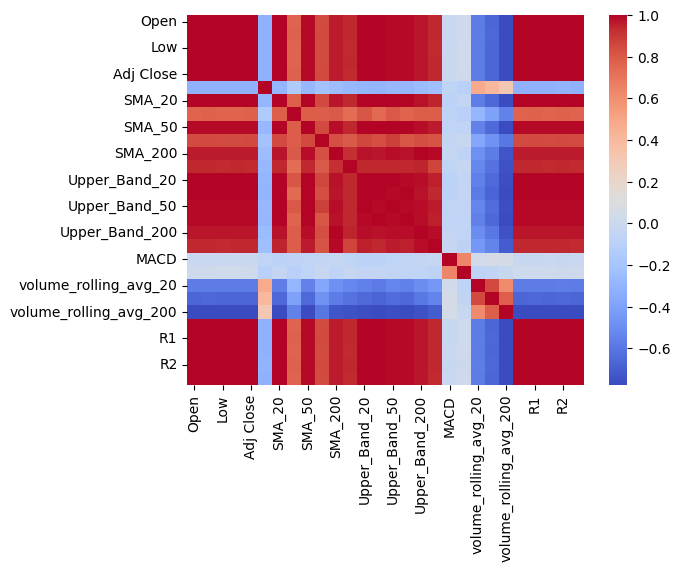

In [ ]:
correlation_matrix = test_data.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.show()

In [ ]:
test_data


,Date,Open,High,Low,Close,Adj Close,Volume,SMA_20,STD_20,SMA_50,...,MACD,RSI,volume_rolling_avg_20,volume_rolling_avg_50,volume_rolling_avg_200,pivot,R1,S1,R2,S2
0,2013-06-03,32.653790,32.789700,32.217453,32.553650,29.849840,5158201,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-06-04,33.032906,33.226036,32.460659,32.489269,29.790802,4703152,NaN,NaN,NaN,...,-0.003768,NaN,NaN,NaN,NaN,32.520267,32.823082,32.250835,33.092514,31.948021
2,2013-06-05,32.417740,32.460659,31.831186,31.852648,29.207064,3488150,NaN,NaN,NaN,...,-0.043176,NaN,NaN,NaN,NaN,32.725321,32.989984,32.224607,33.490698,31.959944
3,2013-06-06,31.831186,32.195995,31.623749,32.195995,29.521898,5284580,NaN,NaN,NaN,...,-0.045414,NaN,NaN,NaN,NaN,32.048164,32.265142,31.635670,32.677637,31.418692
4,2013-06-07,32.303291,32.846924,32.145924,32.296139,29.613716,3888537,NaN,NaN,NaN,...,-0.038366,NaN,NaN,NaN,NaN,32.005246,32.386744,31.814498,32.577493,31.433000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2514,2023-05-26,120.070000,120.720001,118.379997,120.419998,120.419998,2089100,128.712500,4.658854,133.123054,...,-0.735117,23.207126,2005620.0,1727736.0,1464018.0,119.513334,121.386668,117.616664,123.283338,115.743329
2515,2023-05-30,120.010002,121.309998,117.669998,117.730003,117.730003,2094800,127.795000,4.930530,132.818387,...,-0.897769,25.998008,2059715.0,1728712.0,1468679.5,119.839999,121.300001,118.959997,122.180003,117.499995
2516,2023-05-31,116.989998,117.150002,114.800003,115.669998,115.669998,3998800,126.852499,5.360265,132.445363,...,-1.057745,21.037869,2178175.0,1774598.0,1484344.5,118.903333,120.136668,116.496668,122.543332,115.263334
2517,2023-06-01,116.970001,117.639999,115.000000,116.260002,116.260002,3966100,125.926999,5.516957,132.034820,...,-1.036128,23.586662,2300025.0,1826074.0,1497719.5,115.873334,116.946665,114.596667,118.223333,113.523336


In [ ]:
import pandas as pd

correlation_matrix = test_data.corr()

# Set correlation threshold
threshold = 0.5

# Identify collinear features based on correlation matrix
collinear_features = []
for feature in correlation_matrix.columns:
    correlated_with = list(correlation_matrix.index[correlation_matrix[feature].abs() > threshold])
    correlated_with.remove(feature)
    if correlated_with:
        collinear_features.append((feature, correlated_with))

# Print the collinear features and what they are collinear with
for feature, correlated_with in collinear_features:
    print(f"'{feature}': {correlated_with}")


'Open': ['High', 'Low', 'Close', 'Adj Close', 'SMA_20', 'STD_20', 'SMA_50', 'STD_50', 'SMA_200', 'STD_200', 'Upper_Band_20', 'Lower_Band_20', 'Upper_Band_50', 'Lower_Band_50', 'Upper_Band_200', 'Lower_Band_200', 'volume_rolling_avg_20', 'volume_rolling_avg_50', 'volume_rolling_avg_200', 'pivot', 'R1', 'S1', 'R2', 'S2']
'High': ['Open', 'Low', 'Close', 'Adj Close', 'SMA_20', 'STD_20', 'SMA_50', 'STD_50', 'SMA_200', 'STD_200', 'Upper_Band_20', 'Lower_Band_20', 'Upper_Band_50', 'Lower_Band_50', 'Upper_Band_200', 'Lower_Band_200', 'volume_rolling_avg_20', 'volume_rolling_avg_50', 'volume_rolling_avg_200', 'pivot', 'R1', 'S1', 'R2', 'S2']
'Low': ['Open', 'High', 'Close', 'Adj Close', 'SMA_20', 'STD_20', 'SMA_50', 'STD_50', 'SMA_200', 'STD_200', 'Upper_Band_20', 'Lower_Band_20', 'Upper_Band_50', 'Lower_Band_50', 'Upper_Band_200', 'Lower_Band_200', 'volume_rolling_avg_20', 'volume_rolling_avg_50', 'volume_rolling_avg_200', 'pivot', 'R1', 'S1', 'R2', 'S2']
'Close': ['Open', 'High', 'Low', 'Adj

<ipython-input-15-e1fdc82a43a9>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = test_data.corr()


In [ ]:
import pandas as pd

# Assuming you have a dataframe 'df' containing all the data
target_variable = 'Adj Close'
correlation_matrix = test_data.corr()

# Calculate the correlation with the target variable and sort in ascending order
correlations = correlation_matrix[target_variable].abs().sort_values()

# Select the least correlated features with 'Adj Close'
least_correlated_features = correlations.index.tolist()

# Choose a subset of the least correlated features with low inter-feature correlation
selected_features = []
correlation_threshold = 0.5  # Set the correlation threshold for inter-feature correlation

for feature in least_correlated_features:
    if all(abs(correlation_matrix[feature][selected_features]) < correlation_threshold):
        selected_features.append(feature)
        if len(selected_features) >= 20:  # Define the desired number of features
            break

# Print the selected feature combination
print("Selected features:")
for feature in selected_features:
    print(feature)


Selected features:
MACD
Volume
volume_rolling_avg_20
STD_20


<ipython-input-16-11f1286118b6>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = test_data.corr()


In [ ]:
test_data.columns


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'SMA_20',
       'STD_20', 'SMA_50', 'STD_50', 'SMA_200', 'STD_200', 'Upper_Band_20',
       'Lower_Band_20', 'Upper_Band_50', 'Lower_Band_50', 'Upper_Band_200',
       'Lower_Band_200', 'MACD', 'RSI', 'volume_rolling_avg_20',
       'volume_rolling_avg_50', 'volume_rolling_avg_200', 'pivot', 'R1', 'S1',
       'R2', 'S2'],
      dtype='object')

In [ ]:
test_data_20 = pd.DataFrame(test_data[['Date', 'SMA_20', 'Lower_Band_20', 'Upper_Band_20', 'volume_rolling_avg_20', 'RSI', 'pivot', 'R1', 'S1',
       'R2', 'S2', 'Adj Close']])

test_data_50 = pd.DataFrame(test_data[['Date', 'SMA_50', 'Lower_Band_50', 'Upper_Band_50', 'volume_rolling_avg_50', 'RSI', 'pivot', 'R1', 'S1',
       'R2', 'S2', 'Adj Close']])

test_data_200 = pd.DataFrame(test_data[['Date', 'SMA_200', 'Lower_Band_200', 'Upper_Band_200', 'volume_rolling_avg_200', 'RSI', 'pivot', 'R1', 'S1',
       'R2', 'S2', 'Adj Close']])

In [ ]:
# url = "https://www.reddit.com/r/AA/top/?t=all"

# request = requests.get(url)

In [ ]:
# request.content

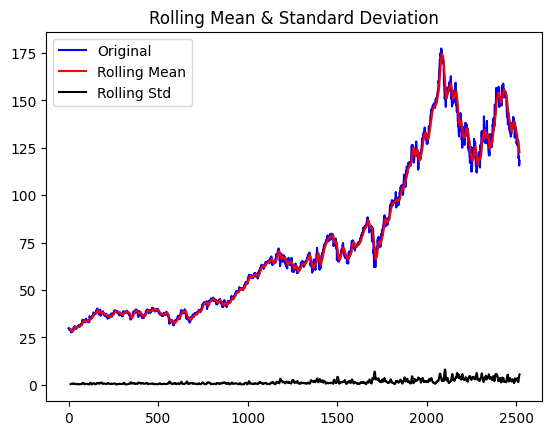

Results of Dickey-Fuller Test:
Test Statistic                   -0.863096
p-value                           0.799882
#Lags Used                        6.000000
Number of Observations Used    2512.000000
Critical Value (1%)              -3.432956
Critical Value (5%)              -2.862691
Critical Value (10%)             -2.567383
dtype: float64


In [ ]:
from statsmodels.tsa.stattools import adfuller

# Testing for stationarity
def test_stationarity(timeseries):

    # Determining rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    # Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

# Run the test on the 'Adj Close' column
test_stationarity(test_data_20['Adj Close'])

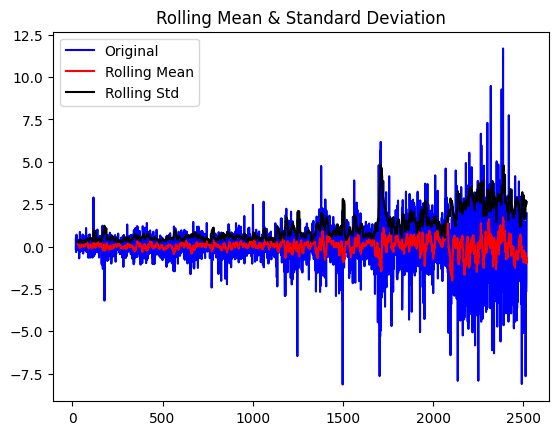

Results of Dickey-Fuller Test:
Test Statistic                  -21.844336
p-value                           0.000000
#Lags Used                        5.000000
Number of Observations Used    2494.000000
Critical Value (1%)              -3.432975
Critical Value (5%)              -2.862700
Critical Value (10%)             -2.567387
dtype: float64


In [ ]:
test_data_20['Adj Close_diff'] = test_data_20['Adj Close'] - test_data_20['Adj Close'].shift(1)

# Drop the NaN values
test_data_20 = test_data_20.dropna()

# Check stationarity again
test_stationarity(test_data_20['Adj Close_diff'])

In [ ]:
from statsmodels.tsa.ar_model import AutoReg

# Split the data
train, test = test_data_20['Adj Close_diff'][:-10], test_data_20['Adj Close_diff'][-10:]

# Train the model
model = AutoReg(train, lags=1)
model_fit = model.fit()

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

print(predictions)

2490   -0.030885
2491    0.044393
2492    0.040348
2493    0.040565
2494    0.040553
2495    0.040554
2496    0.040554
2497    0.040554
2498    0.040554
2499    0.040554
dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
predictions_in_original_scale = test_data_20['Adj Close'].iloc[-10-1:-1] + predictions.values

print(predictions_in_original_scale)

2508    129.109114
2509    128.914388
2510    129.130344
2511    128.680564
2512    121.030551
2513    119.530552
2514    120.460552
2515    117.770557
2516    115.710552
2517    116.300556
Name: Adj Close, dtype: float64


In [ ]:
# import numpy as np

# # Compute the difference in predictions (these are your predicted returns)
# predicted_returns = predictions_in_original_scale.pct_change().shift(-1)[:-1]  # drop last value

# # Compute the difference in actual prices (these are your actual returns)
# actual_returns = test_in_original_scale.pct_change().shift(-1)[:-1]  # drop last value

# # Define a simple trading strategy: go long when predicted return is positive, go short when predicted return is negative
# trading_positions = np.sign(predicted_returns)

# # Compute the strategy returns
# strategy_returns = trading_positions * actual_returns

# # Compute the cumulative returns of the strategy
# cumulative_returns = (strategy_returns + 1).cumprod() - 1

# # The total gain/loss of the strategy is the last value in cumulative_returns
# total_gain_loss = cumulative_returns.iloc[-1]

# print(f'Total gain/loss of the strategy: {total_gain_loss * 100}%')

test = test_data[['Date', 'Open', 'High', 'Low', 'Volume', 'Adj Close']]

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np


es = EarlyStopping(patience=4, monitor="loss")

# Select the feature and target
X = test_data.drop(['Date', 'Adj Close'], axis=1)
y = test_data['Adj Close']

# Rescale the features
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

# Split the data into train and test datasets
# Assume you want to use the entire dataset for training, and the last 5 data points for testing
X_train = X[201:-5]
X_test = X[-5:]
y_train = y[201:-5]
y_test = y[-5:]

# Reshape the inputs for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential()
# model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))

# model.add(LSTM(units=50))
# model.add(Dense(1))

model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))

model.add(LSTM(64))

model.add(Dense(1,kernel_initializer="uniform",activation='linear'))


# Compile and fit the model on 30 epochs
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2)

# Make predictions
predictions = model.predict(X_test)

# If you want to compare predictions and real values, you can print them out
print("Predictions:", predictions)
print("Real values:", y_test.values)

Epoch 1/100
73/73 - 5s - loss: 8913.6680 - 5s/epoch - 63ms/step
Epoch 2/100
73/73 - 2s - loss: 8014.0693 - 2s/epoch - 21ms/step
Epoch 3/100
73/73 - 2s - loss: 7315.1821 - 2s/epoch - 21ms/step
Epoch 4/100
73/73 - 2s - loss: 6706.8467 - 2s/epoch - 21ms/step
Epoch 5/100
73/73 - 2s - loss: 6168.1934 - 2s/epoch - 21ms/step
Epoch 6/100
73/73 - 2s - loss: 5688.4868 - 2s/epoch - 22ms/step
Epoch 7/100
73/73 - 2s - loss: 5261.3081 - 2s/epoch - 29ms/step
Epoch 8/100
73/73 - 2s - loss: 4885.3506 - 2s/epoch - 23ms/step
Epoch 9/100
73/73 - 2s - loss: 4551.4683 - 2s/epoch - 22ms/step
Epoch 10/100
73/73 - 2s - loss: 4256.1255 - 2s/epoch - 21ms/step
Epoch 11/100
73/73 - 2s - loss: 3998.8142 - 2s/epoch - 22ms/step
Epoch 12/100
73/73 - 2s - loss: 3773.0520 - 2s/epoch - 21ms/step
Epoch 13/100
73/73 - 2s - loss: 3577.1687 - 2s/epoch - 21ms/step
Epoch 14/100
73/73 - 2s - loss: 3408.1433 - 2s/epoch - 25ms/step
Epoch 15/100
73/73 - 3s - loss: 3263.4463 - 3s/epoch - 38ms/step
Epoch 16/100
73/73 - 1s - loss: 31

In [ ]:
X_test[-1:,:,:]

array([[[0.7752892 ],
        [0.77173154],
        [0.78070869],
        [0.        ]]])

In [ ]:
def predict_next_n_days(model, X_input, n_days):
    # Copy the input data to avoid changing the original
    X_input = X_input.copy()

    # Initialize an empty list to hold the predictions
    predictions = []

    # Make predictions for the next n_days
    for _ in range(n_days):
        # Make a prediction for the next day
        y_pred = model.predict(X_input)

        # Append the prediction to the list
        predictions.append(y_pred[0,0])

        # Remove the first day's data from the input
        X_input = X_input[:,1:,:]

        # Add the prediction to the end of the input data
        X_input = np.append(X_input, np.array([[[y_pred[0,0]]]]), axis=1)

    # Return the predictions
    return predictions

X_input = X_train[-1:,:,:] # Use the last available data to start the prediction
predictions = predict_next_n_days(model, X_input, 5)

# Print the predicted and actual prices for the last 5 days
print("Predicted prices:", predictions)
print("Actual prices:", y_test.values)

1/1 [==============================] - 0s 17ms/step
Predicted prices: [113.0303, 110.25082, 109.98756, 110.04671, 110.079575]
Actual prices: [120.11000061 121.66000366 120.58000183 122.76999664 124.25      ]


In [ ]:
original_prices = y_test.values
predicted_prices = predictions

print(original_prices, predicted_prices)

profit_loss = original_prices[-1] - predicted_prices[-1]
print(f'Profit/Loss: {profit_loss}')

# ROI
initial_investment = predicted_prices[-1]
roi = profit_loss / initial_investment
print(f'ROI: {roi}')

# Simple buying and selling strategy
initial_money = 10000  # or any starting amount of money you want
money = initial_money
stocks = 0

for i in range(len(predicted_prices)-1):
    # Buy if the price is predicted to go up
    if predicted_prices[i+1] > predicted_prices[i] * 1.005:
        stocks += money / original_prices[i]  # buy as much as you can
        money = 0  # use all your money to buy stocks
    # Sell if the price is predicted to go down
    elif predicted_prices[i+1] < predicted_prices[i]:
        money += stocks * original_prices[i]  # sell all stocks
        stocks = 0  # sell all stocks

# Sell any remaining stocks at the end
if stocks > 0:
    money += stocks * original_prices[-1]

print(f'Final amount of money: {money}')

[120.11000061 121.66000366 120.58000183 122.76999664 124.25      ] [113.0303, 110.25082, 109.98756, 110.04671, 110.079575]
Profit/Loss: 14.170425415039062
ROI: 0.12872892603797384
Final amount of money: 10000.0


In [ ]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# mse = mean_squared_error(y_test, predictions)
# print(f'MSE: {mse}')

# rmse = np.sqrt(mse)
# print(f'RMSE: {rmse}')

# mae = mean_absolute_error(y_test, predictions)
# print(f'MAE: {mae}')

# r2 = r2_score(y_test, predictions)
# print(f'R2 Score: {r2}')

# # Calculate Profit/Loss
# original_prices = y_test.values
# predicted_prices = predictions.flatten()

# profit_loss = original_prices[-1] - predicted_prices[-1]
# print(f'Profit/Loss: {profit_loss}')

# # Profit/Loss accuracy
# accuracy = np.mean(predicted_prices[-1] < original_prices[-1])
# print(f'P/L Accuracy: {accuracy}')

test_data['Adj Close'].iloc[-1]

124.25

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model

# Assume we are working with some time series data
time_series_data = test_data['Adj Close']

# Select all but the last row for fitting the model
time_series_data_fit = time_series_data[:-1]

# Fit an ARIMA model
model = ARIMA(time_series_data_fit, order=(5,1,0))
model_fit = model.fit()

# Get the residuals
residuals = model_fit.resid

# Fit a GARCH model on the residuals of the ARIMA model
garch_model = arch_model(residuals, vol="Garch", p=1, q=1)
garch_model_fit = garch_model.fit()

# Make a one-step ahead forecast
garch_forecast = garch_model_fit.forecast(horizon=1)
print(garch_forecast.variance[-1:])

# Forecast the last value
arima_forecast = model_fit.forecast(steps=1)
print(f'Previous: {time_series_data.iloc[-2]}')
print(f'Forecast: {arima_forecast}')

# Print the actual last value
print(f'Previous: {time_series_data.iloc[-2]}')
print(f'Actual: {time_series_data.iloc[-1]}')


Iteration:      1,   Func. Count:      6,   Neg. LLF: 15760.768678345255
Iteration:      2,   Func. Count:     16,   Neg. LLF: 1371004.3418507408
Iteration:      3,   Func. Count:     23,   Neg. LLF: 3479.2521828084223
Iteration:      4,   Func. Count:     29,   Neg. LLF: 6583.387651994766
Iteration:      5,   Func. Count:     35,   Neg. LLF: 3478.5767067660204
Iteration:      6,   Func. Count:     41,   Neg. LLF: 3455.0167739357794
Iteration:      7,   Func. Count:     47,   Neg. LLF: 3358.4192069082037
Iteration:      8,   Func. Count:     52,   Neg. LLF: 3354.4017009153868
Iteration:      9,   Func. Count:     57,   Neg. LLF: 3353.4796616854883
Iteration:     10,   Func. Count:     62,   Neg. LLF: 3353.2279307170056
Iteration:     11,   Func. Count:     67,   Neg. LLF: 3353.157198904651
Iteration:     12,   Func. Count:     72,   Neg. LLF: 3353.155370951612
Iteration:     13,   Func. Count:     77,   Neg. LLF: 3353.1552751860727
Iteration:     14,   Func. Count:     82,   Neg. LLF: 

/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [ ]:
from arch import arch_model

# Assume we are working with some time series data
time_series_data = test_data['Adj Close']

# Select all but the last row for fitting the model
time_series_data_fit = time_series_data[:-1]

# Fit an ARIMA(5,1,0) + GARCH(1,1) model to the data
model = arch_model(time_series_data_fit, mean='AR', lags=5, vol='Garch', p=1, q=1)
model_fit = model.fit()

# Forecast the last value
forecast = model_fit.forecast(start=0)
print(f'Forecast: {forecast.mean[-1]}')

# Print the actual last value
print(f'Actual: {time_series_data[-1]}')

Iteration:      1,   Func. Count:     11,   Neg. LLF: 828849776058.0765
Iteration:      2,   Func. Count:     29,   Neg. LLF: 902148.7170864823
Iteration:      3,   Func. Count:     43,   Neg. LLF: 220451.58977469953
Iteration:      4,   Func. Count:     57,   Neg. LLF: 3962916.868850926
Iteration:      5,   Func. Count:     70,   Neg. LLF: 1946080.5810766825
Iteration:      6,   Func. Count:     82,   Neg. LLF: 1477903.8985966153
Iteration:      7,   Func. Count:     93,   Neg. LLF: 14953838.7260065
Iteration:      8,   Func. Count:    106,   Neg. LLF: 4084.3166452791197
Iteration:      9,   Func. Count:    117,   Neg. LLF: 4322.7393462171185
Iteration:     10,   Func. Count:    128,   Neg. LLF: 3953.750363468819
Iteration:     11,   Func. Count:    138,   Neg. LLF: 6689.232831131471
Iteration:     12,   Func. Count:    149,   Neg. LLF: 15969.273691079823
Iteration:     13,   Func. Count:    161,   Neg. LLF: 5279.172133624772
Iteration:     14,   Func. Count:    172,   Neg. LLF: 3904.

/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


ValueError: ignored

In [ ]:
# !pip install focal_loss

import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Attention, Input
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from sklearn.ensemble import RandomForestRegressor
# from focal_loss import BinaryFocalLoss

es = EarlyStopping(patience=4, monitor='loss')
set_path = "/content/sample_data/"


def walk_forward_rnn_class_present(date, train_size=250):
  AAPL_data = yf.download('AAPL','2018-01-01', date)

  AAPL_sent = pd.read_csv(set_path+"reddit_sentimental_AAPL.csv")
  AAPL_sent = AAPL_sent[['created_at', 'content', 'score', 'sentiment']].rename(columns={'created_at': "Date", "score": "exposure"})
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])

  AAPL_with_sent = AAPL_data.merge(AAPL_sent, how='left', on='Date')
  AAPL_with_sent['exposure'] = AAPL_with_sent['exposure'].fillna(0)

  AAPL_grouped = AAPL_with_sent.loc[AAPL_with_sent.groupby("Date")["exposure"].idxmax()]
  AAPL_grouped['sentiment'] = AAPL_grouped['sentiment'].fillna(0)
  AAPL_grouped = AAPL_grouped.drop(columns=['content'])

  AAPL_fa = pd.read_csv(set_path+'df_aapl_final.csv').drop(columns='Close')
  AAPL_fa['Date'] = pd.to_datetime(AAPL_fa['Date'])

  AAPL_event = pd.read_csv(set_path+'whether_releases_df.csv')
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])

  AAPL = AAPL_grouped.merge(AAPL_fa, how='left', on='Date')
  AAPL = AAPL.merge(AAPL_event, how='left', on='Date')
  AAPL = AAPL.fillna(0)

  AAPL_vix = pd.read_csv(set_path+'vix_weekday_df.csv')
  AAPL_vix['Date'] = pd.to_datetime(AAPL_vix['Date'])
  AAPL = AAPL.merge(AAPL_vix, how='left', on='Date')
  AAPL = AAPL.fillna(0)

  AAPL_pce = pd.read_csv(set_path+'PCE_weekday_df.csv')
  AAPL_pce['Date'] = pd.to_datetime(AAPL_pce['Date'])
  AAPL = AAPL.merge(AAPL_pce, how='left', on='Date')
  AAPL = AAPL.fillna(0)

  AAPL['sent_exp'] = AAPL['sentiment'] * AAPL['exposure']

  AAPL = AAPL.drop(columns=['sentiment', 'exposure'])

  data = AAPL

  # data = pd.read_csv(set_path+'present.csv')

  """
  Optional drops
  """

  # data = data.drop(columns=['Apple Quarterly Operating Margin', 'Apple Quarterly Net Income\n(Millions of US $)'])

  # Set 'Adj Close' column as y and remaining columns as features X
  X = data.drop(columns=['Date', 'Adj Close', 'Entry', 'PCE', 'sent_exp'])
  X = X.astype(float)
  y = data['Adj Close']

  y_diff = y.diff().dropna()

  # Normalize features to between 0 and 1
  scaler = MinMaxScaler(feature_range=(0, 1))
  X_scaled = scaler.fit_transform(X)

  # Normalize target variable separately
  y_scaler = MinMaxScaler(feature_range=(0, 1))
  y_diff_scaled = y_scaler.fit_transform(np.array(y_diff).reshape(-1, 1))

  # Function to create sequences
  def create_sequences(X, y, time_steps=5):
      Xs, ys = [], []
      for i in range(len(X) - (time_steps)):
            Xs.append(X[i:(i + time_steps)])
            ys.append(y[i + time_steps - 1])

      return np.array(Xs), np.array(ys)


  y_bin = np.where(y.diff() > 0, 1, 0)[1:]  # Shift by one to exclude the first NaN value from diff()
  y_shift = np.array(y)[1:]
  # Normalize target variable separately
  y_bin_scaler = MinMaxScaler(feature_range=(0, 1))
  y_bin_scaled = y_bin_scaler.fit_transform(np.array(y_bin).reshape(-1, 1))

  time_steps = 10  # change to whatever value you want
  X_seq, y_bin_seq = create_sequences(X_scaled, y_bin_scaled, time_steps)
  X_seq_o, y_bin_o = create_sequences(X, y_shift, time_steps)

  # Loop from train_size to len(X_seq) + 1
  # Training Data
  X_train = X_seq  # Exclude the last row from X
  y_train = y_bin_seq  # Exclude the last row from Y

  # Test Data (for prediction)
  X_test = np.array(X_scaled[-time_steps:]).reshape(1, 10, 13)



  # Build the LSTM model
  sequence_length = X_train.shape[1]
  feature_length = X_train.shape[2]

  # Define the layers
  inputs = Input(shape=(sequence_length, feature_length))

  lstm_out, hidden_h, hidden_c = LSTM(64, return_sequences=True, return_state=True)(inputs)
  attention = Attention()([lstm_out, lstm_out])
  lstm_out2 = LSTM(64, return_sequences=True)(attention)
  lstm_out3 = LSTM(32)(lstm_out2)

  outputs = Dense(1, activation='sigmoid')(lstm_out3)

  model = Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer='adam', loss='binary_crossentropy')
  model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=0, callbacks=[es])

  predicted_prob = model.predict(X_test)[0][0]  # Probability of price increase
  predicted_bin = np.where(predicted_prob > 0.485, 1, 0)  # Binary prediction

  # The actual price direction

  price_day_before = y.iloc[-1]

  print("Predicted probability: ", predicted_prob)
  print("Predicted direction: ", "Increase" if predicted_bin else "Decrease")

  print("Price from the day before the prediction: ", price_day_before)

  if predicted_bin:
      pred_action = 'buy'
  else:
      pred_action = 'sell'
  return pred_action, price_day_before, predicted_prob

# print(walk_forward_rnn_class_present('2023-06-06'))


def create_date_list(start_date, end_date, batch_size):
    date_format = "%Y-%m-%d"
    date_batches = []
    current_batch = []

    start = datetime.strptime(start_date, date_format)
    end = datetime.strptime(end_date, date_format)

    current_date = end
    while current_date >= start:
        if current_date.weekday() < 5:  # If it's a weekday
            current_batch.append(current_date.strftime(date_format))
            if len(current_batch) == batch_size:
                date_batches.append(current_batch)
                current_batch = []
        current_date -= timedelta(days=1)

    # Reverse each individual batch so the dates are in ascending order
    date_batches = [batch[::-1] for batch in date_batches]

    return date_batches[::-1]

correct_all = 0
wrong_all = 0
correct_ = 0
wrong_ = 0
money = 10000
stocks = 0
short_stocks = 0 # holds number of stocks that are short sold
probabilities = []
correct_list = []




action_list = {}
price_list = {}

for i in range(5):
  for dates in create_date_list('2023-03-13', '2023-06-06', 5):
    print(dates)
    if dates:
      for date in dates:
        print(date)
        action, stock_prev, predicted_prob = walk_forward_rnn_class_present(date, 125)
        probabilities.append(predicted_prob)
        price_list[f'{date}'] = stock_prev
        if action == 'buy':
          if date in action_list.keys():
            action_list[f'{date}'] += action
          else:
            action_list[f'{date}'] = action
          if short_stocks > 0:  # Cover short position
              cost_to_cover = short_stocks*stock_prev
              if cost_to_cover <= money:  # Ensure you have enough money to cover
                  money -= cost_to_cover
                  short_stocks = 0
          if money > 0 and short_stocks == 0:  # You can't buy normally if you have an open short position
            stocks += money/stock_prev
            money = 0
        elif action == 'sell':
          if date in action_list.keys():
            action_list[f'{date}'] += action
          else:
            action_list[f'{date}'] = action
          if stocks > 0:  # Normal sell
              money += stocks * stock_prev
              stocks = 0
          if stocks == 0 and short_stocks == 0:  # Short sell
              short_stocks += money/stock_prev
              money += short_stocks*stock_prev  # You sold borrowed stocks, so add this money to your balance

        print(f"Current Money: {money}")
        print(f"Current Stocks: {stocks}")
        print(f"Short Stocks: {short_stocks}")
      correct_ = 0

if stocks > 0:  # If you have stocks
    money += stocks * 179.21  # Sell all stocks at current price
elif short_stocks > 0:  # If you have short stocks
    money -= short_stocks * 179.21  # Buy back all short stocks at current price

print(f"Final money: €{money}")




['2023-03-15', '2023-03-16', '2023-03-17', '2023-03-20', '2023-03-21']
2023-03-15
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.51443183
Predicted direction:  Increase
Price from the day before the prediction:  152.3792266845703
Current Money: 0
Current Stocks: 65.62574320383123
Short Stocks: 0
2023-03-16
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.5176467
Predicted direction:  Increase
Price from the day before the prediction:  152.7786865234375
Current Money: 0
Current Stocks: 65.62574320383123
Short Stocks: 0
2023-03-17
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 2s 2s/step
Predicted probability:  0.51048404
Predicted direction:  Increase
Price from the day before the prediction:  155.63473510742188
Current Money: 0
Current Stocks: 65.62574320383123
Short Stocks: 0
2023-03-20
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.5184551
Predicted direction:  Increase
Price from the day before the prediction:  154.78590393066406
Current Money: 0
Current Stocks: 65.62574320383123
Short Stocks: 0
2023-03-21
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.5062042
Predicted direction:  Increase
Price from the day before the prediction:  157.18258666992188
Current Money: 0
Current Stocks: 65.62574320383123
Short Stocks: 0
['2023-03-22', '2023-03-23', '2023-03-24', '2023-03-27', '2023-03-28']
2023-03-22
[*********************100%***********************]  1 of 1 completed

<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])


<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.5287076
Predicted direction:  Increase
Price from the day before the prediction:  159.0599822998047
Current Money: 0
Current Stocks: 65.62574320383123
Short Stocks: 0
2023-03-23
[*********************100%***********************]  1 of 1 completed

<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])


<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.52182794
Predicted direction:  Increase
Price from the day before the prediction:  157.61199951171875
Current Money: 0
Current Stocks: 65.62574320383123
Short Stocks: 0
2023-03-24
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.50747204
Predicted direction:  Increase
Price from the day before the prediction:  158.71046447753906
Current Money: 0
Current Stocks: 65.62574320383123
Short Stocks: 0
2023-03-27
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 2s 2s/step
Predicted probability:  0.5421598
Predicted direction:  Increase
Price from the day before the prediction:  160.02865600585938
Current Money: 0
Current Stocks: 65.62574320383123
Short Stocks: 0
2023-03-28
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.52304095
Predicted direction:  Increase
Price from the day before the prediction:  158.06137084960938
Current Money: 0
Current Stocks: 65.62574320383123
Short Stocks: 0
['2023-03-29', '2023-03-30', '2023-03-31', '2023-04-03', '2023-04-04']
2023-03-29
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.5150492
Predicted direction:  Increase
Price from the day before the prediction:  157.43223571777344
Current Money: 0
Current Stocks: 65.62574320383123
Short Stocks: 0
2023-03-30
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.51833576
Predicted direction:  Increase
Price from the day before the prediction:  160.54794311523438
Current Money: 0
Current Stocks: 65.62574320383123
Short Stocks: 0
2023-03-31
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 2s 2s/step
Predicted probability:  0.51734006
Predicted direction:  Increase
Price from the day before the prediction:  162.1357421875
Current Money: 0
Current Stocks: 65.62574320383123
Short Stocks: 0
2023-04-03
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.518158
Predicted direction:  Increase
Price from the day before the prediction:  164.67222595214844
Current Money: 0
Current Stocks: 65.62574320383123
Short Stocks: 0
2023-04-04
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.5202568
Predicted direction:  Increase
Price from the day before the prediction:  165.9404754638672
Current Money: 0
Current Stocks: 65.62574320383123
Short Stocks: 0
['2023-04-05', '2023-04-06', '2023-04-07', '2023-04-10', '2023-04-11']
2023-04-05
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 2s 2s/step
Predicted probability:  0.52899593
Predicted direction:  Increase
Price from the day before the prediction:  165.40122985839844
Current Money: 0
Current Stocks: 65.62574320383123
Short Stocks: 0
2023-04-06
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.5332164
Predicted direction:  Increase
Price from the day before the prediction:  163.53379821777344
Current Money: 0
Current Stocks: 65.62574320383123
Short Stocks: 0
2023-04-07
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 2s 2s/step
Predicted probability:  0.5055007
Predicted direction:  Increase
Price from the day before the prediction:  164.43255615234375
Current Money: 0
Current Stocks: 65.62574320383123
Short Stocks: 0
2023-04-10
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.52219844
Predicted direction:  Increase
Price from the day before the prediction:  164.43255615234375
Current Money: 0
Current Stocks: 65.62574320383123
Short Stocks: 0
2023-04-11
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.5236658
Predicted direction:  Increase
Price from the day before the prediction:  161.80618286132812
Current Money: 0
Current Stocks: 65.62574320383123
Short Stocks: 0
['2023-04-12', '2023-04-13', '2023-04-14', '2023-04-17', '2023-04-18']
2023-04-12
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.4844645
Predicted direction:  Decrease
Price from the day before the prediction:  160.57789611816406
Current Money: 21076.087549724245
Current Stocks: 0
Short Stocks: 65.62574320383123
2023-04-13
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 2s 2s/step
Predicted probability:  0.5044017
Predicted direction:  Increase
Price from the day before the prediction:  159.8788604736328
Current Money: 0
Current Stocks: 66.1996118636707
Short Stocks: 0
2023-04-14
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.5277371
Predicted direction:  Increase
Price from the day before the prediction:  165.33131408691406
Current Money: 0
Current Stocks: 66.1996118636707
Short Stocks: 0
2023-04-17
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.48884228
Predicted direction:  Increase
Price from the day before the prediction:  164.9818115234375
Current Money: 0
Current Stocks: 66.1996118636707
Short Stocks: 0
2023-04-18
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.5111639
Predicted direction:  Increase
Price from the day before the prediction:  165.00177001953125
Current Money: 0
Current Stocks: 66.1996118636707
Short Stocks: 0
['2023-04-19', '2023-04-20', '2023-04-21', '2023-04-24', '2023-04-25']
2023-04-19
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.51367205
Predicted direction:  Increase
Price from the day before the prediction:  166.2400665283203
Current Money: 0
Current Stocks: 66.1996118636707
Short Stocks: 0
2023-04-20
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 2s 2s/step
Predicted probability:  0.52049834
Predicted direction:  Increase
Price from the day before the prediction:  167.39846801757812
Current Money: 0
Current Stocks: 66.1996118636707
Short Stocks: 0
2023-04-21
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.52088404
Predicted direction:  Increase
Price from the day before the prediction:  166.4197998046875
Current Money: 0
Current Stocks: 66.1996118636707
Short Stocks: 0
2023-04-24
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.5193542
Predicted direction:  Increase
Price from the day before the prediction:  164.7920684814453
Current Money: 0
Current Stocks: 66.1996118636707
Short Stocks: 0
2023-04-25
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 2s 2s/step
Predicted probability:  0.5068075
Predicted direction:  Increase
Price from the day before the prediction:  165.1016387939453
Current Money: 0
Current Stocks: 66.1996118636707
Short Stocks: 0
['2023-04-26', '2023-04-27', '2023-04-28', '2023-05-01', '2023-05-02']
2023-04-26
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.50529855
Predicted direction:  Increase
Price from the day before the prediction:  163.54379272460938
Current Money: 0
Current Stocks: 66.1996118636707
Short Stocks: 0
2023-04-27
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.49975076
Predicted direction:  Increase
Price from the day before the prediction:  163.53379821777344
Current Money: 0
Current Stocks: 66.1996118636707
Short Stocks: 0
2023-04-28
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.5174873
Predicted direction:  Increase
Price from the day before the prediction:  168.17738342285156
Current Money: 0
Current Stocks: 66.1996118636707
Short Stocks: 0
2023-05-01
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.49403602
Predicted direction:  Increase
Price from the day before the prediction:  169.44561767578125
Current Money: 0
Current Stocks: 66.1996118636707
Short Stocks: 0
2023-05-02
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 2s 2s/step
Predicted probability:  0.49656308
Predicted direction:  Increase
Price from the day before the prediction:  169.35574340820312
Current Money: 0
Current Stocks: 66.1996118636707
Short Stocks: 0
['2023-05-03', '2023-05-04', '2023-05-05', '2023-05-08', '2023-05-09']
2023-05-03
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 2s 2s/step
Predicted probability:  0.51776564
Predicted direction:  Increase
Price from the day before the prediction:  168.30718994140625
Current Money: 0
Current Stocks: 66.1996118636707
Short Stocks: 0
2023-05-04
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.5011008
Predicted direction:  Increase
Price from the day before the prediction:  167.2187042236328
Current Money: 0
Current Stocks: 66.1996118636707
Short Stocks: 0
2023-05-05
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.51611453
Predicted direction:  Increase
Price from the day before the prediction:  165.5609893798828
Current Money: 0
Current Stocks: 66.1996118636707
Short Stocks: 0
2023-05-08
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.521441
Predicted direction:  Increase
Price from the day before the prediction:  173.33026123046875
Current Money: 0
Current Stocks: 66.1996118636707
Short Stocks: 0
2023-05-09
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 2s 2s/step
Predicted probability:  0.5038032
Predicted direction:  Increase
Price from the day before the prediction:  173.26034545898438
Current Money: 0
Current Stocks: 66.1996118636707
Short Stocks: 0
['2023-05-10', '2023-05-11', '2023-05-12', '2023-05-15', '2023-05-16']
2023-05-10
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.49959135
Predicted direction:  Increase
Price from the day before the prediction:  171.53274536132812
Current Money: 0
Current Stocks: 66.1996118636707
Short Stocks: 0
2023-05-11
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.52163494
Predicted direction:  Increase
Price from the day before the prediction:  173.3202667236328
Current Money: 0
Current Stocks: 66.1996118636707
Short Stocks: 0
2023-05-12
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.5215066
Predicted direction:  Increase
Price from the day before the prediction:  173.510009765625
Current Money: 0
Current Stocks: 66.1996118636707
Short Stocks: 0
2023-05-15
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.48011005
Predicted direction:  Decrease
Price from the day before the prediction:  172.57000732421875
Current Money: 22848.13500834818
Current Stocks: 0
Short Stocks: 66.1996118636707
2023-05-16
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.48793158
Predicted direction:  Increase
Price from the day before the prediction:  172.07000732421875
Current Money: 0
Current Stocks: 66.58433673753518
Short Stocks: 0
['2023-05-17', '2023-05-18', '2023-05-19', '2023-05-22', '2023-05-23']
2023-05-17
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.49949557
Predicted direction:  Increase
Price from the day before the prediction:  172.07000732421875
Current Money: 0
Current Stocks: 66.58433673753518
Short Stocks: 0
2023-05-18
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.44710723
Predicted direction:  Decrease
Price from the day before the prediction:  172.69000244140625
Current Money: 22996.898547528734
Current Stocks: 0
Short Stocks: 66.58433673753518
2023-05-19
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.5185266
Predicted direction:  Increase
Price from the day before the prediction:  175.0500030517578
Current Money: 0
Current Stocks: 64.78897458271163
Short Stocks: 0
2023-05-22
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.50084585
Predicted direction:  Increase
Price from the day before the prediction:  175.16000366210938
Current Money: 0
Current Stocks: 64.78897458271163
Short Stocks: 0
2023-05-23
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.50556713
Predicted direction:  Increase
Price from the day before the prediction:  174.1999969482422
Current Money: 0
Current Stocks: 64.78897458271163
Short Stocks: 0
['2023-05-24', '2023-05-25', '2023-05-26', '2023-05-29', '2023-05-30']
2023-05-24
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.4968592
Predicted direction:  Increase
Price from the day before the prediction:  171.55999755859375
Current Money: 0
Current Stocks: 64.78897458271163
Short Stocks: 0
2023-05-25
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.5302273
Predicted direction:  Increase
Price from the day before the prediction:  171.83999633789062
Current Money: 0
Current Stocks: 64.78897458271163
Short Stocks: 0
2023-05-26
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.50681144
Predicted direction:  Increase
Price from the day before the prediction:  172.99000549316406
Current Money: 0
Current Stocks: 64.78897458271163
Short Stocks: 0
2023-05-29
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.5089777
Predicted direction:  Increase
Price from the day before the prediction:  175.42999267578125
Current Money: 0
Current Stocks: 64.78897458271163
Short Stocks: 0
2023-05-30
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.5163846
Predicted direction:  Increase
Price from the day before the prediction:  175.42999267578125
Current Money: 0
Current Stocks: 64.78897458271163
Short Stocks: 0
['2023-05-31', '2023-06-01', '2023-06-02', '2023-06-05', '2023-06-06']
2023-05-31
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.50273764
Predicted direction:  Increase
Price from the day before the prediction:  177.3000030517578
Current Money: 0
Current Stocks: 64.78897458271163
Short Stocks: 0
2023-06-01
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.49871024
Predicted direction:  Increase
Price from the day before the prediction:  177.25
Current Money: 0
Current Stocks: 64.78897458271163
Short Stocks: 0
2023-06-02
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.51898855
Predicted direction:  Increase
Price from the day before the prediction:  180.08999633789062
Current Money: 0
Current Stocks: 64.78897458271163
Short Stocks: 0
2023-06-05
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.51260746
Predicted direction:  Increase
Price from the day before the prediction:  180.9499969482422
Current Money: 0
Current Stocks: 64.78897458271163
Short Stocks: 0
2023-06-06
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.5038183
Predicted direction:  Increase
Price from the day before the prediction:  179.5800018310547
Current Money: 0
Current Stocks: 64.78897458271163
Short Stocks: 0
['2023-03-15', '2023-03-16', '2023-03-17', '2023-03-20', '2023-03-21']
2023-03-15
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.53738594
Predicted direction:  Increase
Price from the day before the prediction:  152.3792266845703
Current Money: 0
Current Stocks: 64.78897458271163
Short Stocks: 0
2023-03-16
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.51729685
Predicted direction:  Increase
Price from the day before the prediction:  152.7786865234375
Current Money: 0
Current Stocks: 64.78897458271163
Short Stocks: 0
2023-03-17
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 2s 2s/step
Predicted probability:  0.51272374
Predicted direction:  Increase
Price from the day before the prediction:  155.63473510742188
Current Money: 0
Current Stocks: 64.78897458271163
Short Stocks: 0
2023-03-20
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.5008566
Predicted direction:  Increase
Price from the day before the prediction:  154.78590393066406
Current Money: 0
Current Stocks: 64.78897458271163
Short Stocks: 0
2023-03-21
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.517957
Predicted direction:  Increase
Price from the day before the prediction:  157.18258666992188
Current Money: 0
Current Stocks: 64.78897458271163
Short Stocks: 0
['2023-03-22', '2023-03-23', '2023-03-24', '2023-03-27', '2023-03-28']
2023-03-22
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 2s 2s/step
Predicted probability:  0.5188605
Predicted direction:  Increase
Price from the day before the prediction:  159.0599822998047
Current Money: 0
Current Stocks: 64.78897458271163
Short Stocks: 0
2023-03-23
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.5153323
Predicted direction:  Increase
Price from the day before the prediction:  157.61199951171875
Current Money: 0
Current Stocks: 64.78897458271163
Short Stocks: 0
2023-03-24
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.51044184
Predicted direction:  Increase
Price from the day before the prediction:  158.71046447753906
Current Money: 0
Current Stocks: 64.78897458271163
Short Stocks: 0
2023-03-27
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.52452034
Predicted direction:  Increase
Price from the day before the prediction:  160.02865600585938
Current Money: 0
Current Stocks: 64.78897458271163
Short Stocks: 0
2023-03-28
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.52246773
Predicted direction:  Increase
Price from the day before the prediction:  158.06137084960938
Current Money: 0
Current Stocks: 64.78897458271163
Short Stocks: 0
['2023-03-29', '2023-03-30', '2023-03-31', '2023-04-03', '2023-04-04']
2023-03-29
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.52192146
Predicted direction:  Increase
Price from the day before the prediction:  157.43223571777344
Current Money: 0
Current Stocks: 64.78897458271163
Short Stocks: 0
2023-03-30
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.5216231
Predicted direction:  Increase
Price from the day before the prediction:  160.54794311523438
Current Money: 0
Current Stocks: 64.78897458271163
Short Stocks: 0
2023-03-31
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.532612
Predicted direction:  Increase
Price from the day before the prediction:  162.1357421875
Current Money: 0
Current Stocks: 64.78897458271163
Short Stocks: 0
2023-04-03
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.5073143
Predicted direction:  Increase
Price from the day before the prediction:  164.67222595214844
Current Money: 0
Current Stocks: 64.78897458271163
Short Stocks: 0
2023-04-04
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.50631136
Predicted direction:  Increase
Price from the day before the prediction:  165.9404754638672
Current Money: 0
Current Stocks: 64.78897458271163
Short Stocks: 0
['2023-04-05', '2023-04-06', '2023-04-07', '2023-04-10', '2023-04-11']
2023-04-05
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.52051973
Predicted direction:  Increase
Price from the day before the prediction:  165.40122985839844
Current Money: 0
Current Stocks: 64.78897458271163
Short Stocks: 0
2023-04-06
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.4999527
Predicted direction:  Increase
Price from the day before the prediction:  163.53379821777344
Current Money: 0
Current Stocks: 64.78897458271163
Short Stocks: 0
2023-04-07
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.50344723
Predicted direction:  Increase
Price from the day before the prediction:  164.43255615234375
Current Money: 0
Current Stocks: 64.78897458271163
Short Stocks: 0
2023-04-10
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.52644444
Predicted direction:  Increase
Price from the day before the prediction:  164.43255615234375
Current Money: 0
Current Stocks: 64.78897458271163
Short Stocks: 0
2023-04-11
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 3s 3s/step
Predicted probability:  0.51356214
Predicted direction:  Increase
Price from the day before the prediction:  161.80618286132812
Current Money: 0
Current Stocks: 64.78897458271163
Short Stocks: 0
['2023-04-12', '2023-04-13', '2023-04-14', '2023-04-17', '2023-04-18']
2023-04-12
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.5130467
Predicted direction:  Increase
Price from the day before the prediction:  160.57789611816406
Current Money: 0
Current Stocks: 64.78897458271163
Short Stocks: 0
2023-04-13
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.50029373
Predicted direction:  Increase
Price from the day before the prediction:  159.8788604736328
Current Money: 0
Current Stocks: 64.78897458271163
Short Stocks: 0
2023-04-14
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.51263005
Predicted direction:  Increase
Price from the day before the prediction:  165.33131408691406
Current Money: 0
Current Stocks: 64.78897458271163
Short Stocks: 0
2023-04-17
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.5189838
Predicted direction:  Increase
Price from the day before the prediction:  164.9818115234375
Current Money: 0
Current Stocks: 64.78897458271163
Short Stocks: 0
2023-04-18
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 2s 2s/step
Predicted probability:  0.5018971
Predicted direction:  Increase
Price from the day before the prediction:  165.00177001953125
Current Money: 0
Current Stocks: 64.78897458271163
Short Stocks: 0
['2023-04-19', '2023-04-20', '2023-04-21', '2023-04-24', '2023-04-25']
2023-04-19
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.5158832
Predicted direction:  Increase
Price from the day before the prediction:  166.2400665283203
Current Money: 0
Current Stocks: 64.78897458271163
Short Stocks: 0
2023-04-20
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.52595156
Predicted direction:  Increase
Price from the day before the prediction:  167.39846801757812
Current Money: 0
Current Stocks: 64.78897458271163
Short Stocks: 0
2023-04-21
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


1/1 [==============================] - 1s 1s/step
Predicted probability:  0.51206255
Predicted direction:  Increase
Price from the day before the prediction:  166.4197998046875
Current Money: 0
Current Stocks: 64.78897458271163
Short Stocks: 0
2023-04-24
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-9a81d1e36dc8>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-5-9a81d1e36dc8>:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


In [21]:
  AAPL_data = yf.download('AAPL','2018-01-01', '2023-06-06')

  AAPL_sent = pd.read_csv(set_path+"reddit_sentimental_AAPL.csv")
  AAPL_sent = AAPL_sent[['created_at', 'content', 'score', 'sentiment']].rename(columns={'created_at': "Date", "score": "exposure"})
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])

  AAPL_with_sent = AAPL_data.merge(AAPL_sent, how='left', on='Date')
  AAPL_with_sent['exposure'] = AAPL_with_sent['exposure'].fillna(0)

  AAPL_grouped = AAPL_with_sent.loc[AAPL_with_sent.groupby("Date")["exposure"].idxmax()]
  AAPL_grouped['sentiment'] = AAPL_grouped['sentiment'].fillna(0)
  AAPL_grouped = AAPL_grouped.drop(columns=['content'])

  AAPL_fa = pd.read_csv(set_path+'df_aapl_final.csv').drop(columns='Close')
  AAPL_fa['Date'] = pd.to_datetime(AAPL_fa['Date'])

  AAPL_event = pd.read_csv(set_path+'whether_releases_df.csv')
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])

  AAPL = AAPL_grouped.merge(AAPL_fa, how='left', on='Date')
  AAPL = AAPL.merge(AAPL_event, how='left', on='Date')
  AAPL = AAPL.fillna(0)

  AAPL_vix = pd.read_csv(set_path+'vix_weekday_df.csv')
  AAPL_vix['Date'] = pd.to_datetime(AAPL_vix['Date'])
  AAPL = AAPL.merge(AAPL_vix, how='left', on='Date')
  AAPL = AAPL.fillna(0)

  AAPL_pce = pd.read_csv(set_path+'PCE_weekday_df.csv')
  AAPL_pce['Date'] = pd.to_datetime(AAPL_pce['Date'])
  AAPL = AAPL.merge(AAPL_pce, how='left', on='Date')
  AAPL = AAPL.fillna(0)

  AAPL['sent_exp'] = AAPL['sentiment'] * AAPL['exposure']

  AAPL = AAPL.drop(columns=['sentiment', 'exposure'])

  data = AAPL

  data.tail()

[*********************100%***********************]  1 of 1 completed


<ipython-input-21-d7ef9128bfe4>:5: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])
<ipython-input-21-d7ef9128bfe4>:18: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])


,Date,Open,High,Low,Close,Adj Close,Volume,Interest,CPI,PE,Apple Quarterly Revenue\n(Millions of US $),Apple Quarterly Net Income\n(Millions of US $),Apple Quarterly Operating Margin,Apple Quarterly EPS,Entry,VIX,PCE,sent_exp
1360,2023-05-30,176.960007,178.990005,176.570007,177.300003,177.300003,55964400,0.0508,303.363,30.101868,94.836,24.16,0.2916,1.52,0.0,17.46,23016.4,0.0
1361,2023-05-31,177.330002,179.350006,176.759995,177.250000,177.250000,99625300,0.0508,303.363,30.093379,94.836,24.16,0.2916,1.52,0.0,17.94,23016.4,0.0
1362,2023-06-01,177.699997,180.119995,176.929993,180.089996,180.089996,68901800,0.0508,303.363,30.575551,94.836,24.16,0.2916,1.52,0.0,15.65,23096.9,0.0
1363,2023-06-02,181.029999,181.779999,179.259995,180.949997,180.949997,61945900,0.0508,303.363,30.721561,94.836,24.16,0.2916,1.52,0.0,14.60,23096.9,0.0
1364,2023-06-05,182.630005,184.949997,178.039993,179.580002,179.580002,121946500,0.0508,303.363,30.488965,94.836,24.16,0.2916,1.52,0.0,14.73,23096.9,0.0


In [46]:
# !pip install focal_loss

import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Attention, Input
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from sklearn.ensemble import RandomForestRegressor
# from focal_loss import BinaryFocalLoss

es = EarlyStopping(patience=4, monitor='loss')
set_path = "/content/sample_data/"


def walk_forward_rnn_class(date, train_size=250):
  # AAPL_data = yf.download('AAPL','2018-01-01', date)

  # AAPL_sent = pd.read_csv(set_path+"reddit_sentimental_AAPL.csv")
  # AAPL_sent = AAPL_sent[['created_at', 'content', 'score', 'sentiment']].rename(columns={'created_at': "Date", "score": "exposure"})
  # AAPL_sent['Date'] = pd.to_datetime(AAPL_sent['Date'])

  # AAPL_with_sent = AAPL_data.merge(AAPL_sent, how='left', on='Date')
  # AAPL_with_sent['exposure'] = AAPL_with_sent['exposure'].fillna(0)

  # AAPL_grouped = AAPL_with_sent.loc[AAPL_with_sent.groupby("Date")["exposure"].idxmax()]
  # AAPL_grouped['sentiment'] = AAPL_grouped['sentiment'].fillna(0)
  # AAPL_grouped = AAPL_grouped.drop(columns=['content'])

  # AAPL_fa = pd.read_csv(set_path+'df_aapl_final.csv').drop(columns='Close')
  # AAPL_fa['Date'] = pd.to_datetime(AAPL_fa['Date'])

  # AAPL_event = pd.read_csv(set_path+'whether_releases_df.csv')
  # AAPL_event['Date'] = pd.to_datetime(AAPL_event['Date'])

  # AAPL = AAPL_grouped.merge(AAPL_fa, how='left', on='Date')
  # AAPL = AAPL.merge(AAPL_event, how='left', on='Date')
  # AAPL = AAPL.fillna(0)

  # AAPL_vix = pd.read_csv(set_path+'vix_weekday_df.csv')
  # AAPL_vix['Date'] = pd.to_datetime(AAPL_vix['Date'])
  # AAPL = AAPL.merge(AAPL_vix, how='left', on='Date')
  # AAPL = AAPL.fillna(0)

  # AAPL_pce = pd.read_csv(set_path+'PCE_weekday_df.csv')
  # AAPL_pce['Date'] = pd.to_datetime(AAPL_pce['Date'])
  # AAPL = AAPL.merge(AAPL_pce, how='left', on='Date')
  # AAPL = AAPL.fillna(0)

  # AAPL['sent_exp'] = AAPL['sentiment'] * AAPL['exposure']

  # AAPL = AAPL.drop(columns=['sentiment', 'exposure'])

  # data = AAPL
  data = pd.read_csv(set_path+'present.csv')

  """
  Optional drops
  """

  # data = data.drop(columns=['Apple Quarterly Operating Margin', 'Apple Quarterly Net Income\n(Millions of US $)'])

  # Set 'Adj Close' column as y and remaining columns as features X
  X = data.drop(columns=['Date', 'Adj Close', 'Entry', 'PCE', 'sent_exp'])
  X = X.astype(float)
  y = data['Adj Close']
  y_diff = y.diff().dropna()

  # Normalize features to between 0 and 1
  scaler = MinMaxScaler(feature_range=(0, 1))
  X_scaled = scaler.fit_transform(X)

  # Normalize target variable separately
  y_scaler = MinMaxScaler(feature_range=(0, 1))
  y_diff_scaled = y_scaler.fit_transform(np.array(y_diff).reshape(-1, 1))

  # Function to create sequences
  def create_sequences(X, y, time_steps=5):
      Xs, ys = [], []
      for i in range(len(X) - (time_steps + 1)):
          Xs.append(X[i:(i + time_steps)])
          ys.append(y[i + time_steps])
      return np.array(Xs), np.array(ys)


  y_bin = np.where(y.diff() > 0, 1, 0)[1:]  # Shift by one to exclude the first NaN value from diff()

  # Normalize target variable separately
  y_bin_scaler = MinMaxScaler(feature_range=(0, 1))
  y_bin_scaled = y_bin_scaler.fit_transform(np.array(y_bin).reshape(-1, 1))

  time_steps = 10  # change to whatever value you want
  X_seq, y_bin_seq = create_sequences(X_scaled, y_bin_scaled, time_steps)
  X_seq_o, y_bin_o = create_sequences(X, y, time_steps)

  for i in range(train_size, len(X_seq)):
      X_train, X_test = X_seq[:i], X_seq[i: i+1]
      y_train, y_test = y_bin_seq[:i], y_bin_seq[i: i+1]
      X_train_o, X_test_o = X_seq_o[:i], X_seq_o[i: i+1]
      y_train_o, y_test_o = y_bin_o[:i], y_bin_o[i: i+1]

  print(X_test_o, y_test_o)

  # Build the LSTM model
  sequence_length = X_train.shape[1]
  feature_length = X_train.shape[2]

  # Define the layers
  inputs = Input(shape=(sequence_length, feature_length))

  lstm_out, hidden_h, hidden_c = LSTM(64, return_sequences=True, return_state=True)(inputs)
  attention = Attention()([lstm_out, lstm_out])
  lstm_out2 = LSTM(64, return_sequences=True)(attention)
  lstm_out3 = LSTM(32)(lstm_out2)

  outputs = Dense(1, activation='sigmoid')(lstm_out3)

  model = Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer='adam', loss='binary_crossentropy')
  model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=0, callbacks=[es])

  predicted_prob = model.predict(X_test)[0][0]  # Probability of price increase
  predicted_bin = np.where(predicted_prob > 0.495, 1, 0)  # Binary prediction

  # The actual price direction
  actual_bin = y_test[0][0]

  actual_price = y.iloc[-1]

  price_day_before = y.iloc[-2]

  print("Predicted probability: ", predicted_prob)
  print("Predicted direction: ", "Increase" if predicted_bin else "Decrease")
  print("Actual direction: ", "Increase" if actual_bin else "Decrease")

  print("Price from the day before the prediction: ", price_day_before)
  print("Actual price: ", actual_price)

  if predicted_bin:
      pred_action = 'buy'
  else:
      pred_action = 'sell'
  if actual_bin:
      cor_action = 'buy'
  else:
      cor_action = 'sell'
  return cor_action == pred_action, pred_action, price_day_before, actual_price, predicted_prob

walk_forward_rnn_class('none')


def create_date_list(start_date, end_date, batch_size):
    date_format = "%Y-%m-%d"
    date_batches = []
    current_batch = []

    start = datetime.strptime(start_date, date_format)
    end = datetime.strptime(end_date, date_format)

    current_date = end
    while current_date >= start:
        if current_date.weekday() < 5:  # If it's a weekday
            current_batch.append(current_date.strftime(date_format))
            if len(current_batch) == batch_size:
                date_batches.append(current_batch)
                current_batch = []
        current_date -= timedelta(days=1)

    # Reverse each individual batch so the dates are in ascending order
    date_batches = [batch[::-1] for batch in date_batches]

    return date_batches[::-1]

# correct_all = 0
# wrong_all = 0
# correct_ = 0
# wrong_ = 0
# money = 10000
# stocks = 0
# short_stocks = 0 # holds number of stocks that are short sold
# probabilities = []
# correct_list = []
# actual_list = []


# cor_list = {}

# for dates in create_date_list('2023-03-13', '2023-06-06', 5):
#   print(dates)
#   if dates:
#     for date in dates:
#       print(date)
#       result, action, stock_prev, stock_now, predicted_prob = walk_forward_rnn_class(date, 125)
#       probabilities.append(predicted_prob)
#       if result == True:
#         correct_ += 1
#         correct_all += 1
#         correct_list.append(1)
#       else:
#         wrong_ += 1
#         wrong_all += 1
#         correct_list.append(0)
#       print(action)
#       if action == 'buy':
#         actual_list.append(1)
#         if short_stocks > 0:  # Cover short position
#             cost_to_cover = short_stocks*stock_prev
#             if cost_to_cover <= money:  # Ensure you have enough money to cover
#                 money -= cost_to_cover
#                 short_stocks = 0
#         if money > 0 and short_stocks == 0:  # You can't buy normally if you have an open short position
#           stocks += money/stock_prev
#           money = 0
#       elif action == 'sell':
#         actual_list.append(0)
#         if stocks > 0:  # Normal sell
#             money += stocks * stock_prev
#             stocks = 0
#         if stocks == 0 and short_stocks == 0:  # Short sell
#             short_stocks += money/stock_prev
#             money += short_stocks*stock_prev  # You sold borrowed stocks, so add this money to your balance

#       print(f"Current Money: {money}")
#       print(f"Current Stocks: {stocks}")
#       print(f"Short Stocks: {short_stocks}")
#     cor_list[f'{dates[0]} - {dates[-1]}'] = correct_/len(dates)
#     correct_ = 0

# if stocks > 0:  # If you have stocks
#     money += stocks * stock_now  # Sell all stocks at current price
# elif short_stocks > 0:  # If you have short stocks
#     money -= short_stocks * stock_now  # Buy back all short stocks at current price

# print(f"Final money: €{money}")
# print(f"Total Correct: {correct_all}")
# print(f"Total Wrong: {wrong_all}")
# print(f"Ration: {(correct_all/(wrong_all+correct_all))*100}%")


"""
06-03-2023 - 06-06-2023

Probability Threshold: 0.48

Optimizer: Adam

Batch size: 16

Without drops

Final money: €11785.43
Total Correct: 34
Total Wrong: 26
Ration: 56.67%
"""

"""
06-03-2023 - 06-06-2023

Probability Threshold: 0.48

Optimizer: Adam

Batch size: 8

Without drops

Final money: €10544.610713478407
Total Correct: 31
Total Wrong: 29
Ration: 51.66666666666667%
"""

"""
06-03-2023 - 06-06-2023

Probability Threshold: 0.48

Optimizer: Adam

Batch size: 16

With drops:
- Apple Quarterly Operating Margin
- Apple Quarterly Net Income\n(Millions of US $)

Final money: €11880.57
Total Correct: 31
Total Wrong: 29
Ration: 51.66666666666667%
"""

"""
06-03-2023 - 06-06-2023

Probability Threshold: 0.48

Optimizer: Adam

Batch size: 8

With drops:
- Apple Quarterly Operating Margin
- Apple Quarterly Net Income\n(Millions of US $)

Final money: €11720.38
Total Correct: 32
Total Wrong: 28
Ration: 53.336%
"""


"""
06-03-2022 - 06-06-2023

Probability Threshold: 0.48

Optimizer: Adam

Batch size: 8

Without drops

Final money: €11433.54493124345
Total Correct: 35
Total Wrong: 25
Ration: 58.33%

"""


"""
06-03-2022 - 06-06-2023

Probability Threshold: 0.48

Optimizer: Adam

Batch size: 8

With drops:
- Apple Quarterly Operating Margin
- Apple Quarterly Net Income\n(Millions of US $)

Final money: €11083.44
Total Correct: 33
Total Wrong: 27
Ration: 55%
"""

"""
06-03-2022 - 06-06-2023

Probability Threshold: 0.48

Optimizer: Adam

Batch size: 8

With drops:
X = data.drop(columns=['Date', 'Adj Close', 'sentiment', 'exposure', 'Entry', 'Interest'])

Final money: €12081.31
Total Correct: 34
Total Wrong: 26
Ration: 56.67%
"""

"""
06-03-2022 - 06-06-2023

Probability Threshold: 0.48

Optimizer: Adam

Batch size: 8

With drops:
X = data.drop(columns=['Date', 'Adj Close', 'sentiment', 'exposure', 'Entry'])

Final money: €11865.30
Total Correct: 33
Total Wrong: 27
Ration: 55%
"""






"""
06-03-2022 - 06-06-2023

Probability Threshold: 0.495

Optimizer: Adam

Batch size: 8

With drops:
X = data.drop(columns=['Date', 'Adj Close', 'sentiment', 'exposure', 'Entry'])

Final money: €11865.30
Total Correct: 33
Total Wrong: 27
Ration: 55%
"""

"""
06-03-2022 - 06-06-2023

Probability Threshold: 0.495

Optimizer: Adam

Batch size: 8

With drops:
X = data.drop(columns=['Date', 'Adj Close', 'Entry', 'PCE', 'sent_exp'])

Final money: €12679.620804381635
Total Correct: 38
Total Wrong: 22
Ration: 63.33%
"""


"""
Correlation Matrix:

Adj Close                                         1.000000
Close                                             0.999956
Low                                               0.999631
High                                              0.999617
Open                                              0.999230
PE                                                0.798916
Apple Quarterly EPS                               0.781591
Apple Quarterly Net Income\n(Millions of US $)    0.729496
Apple Quarterly Revenue\n(Millions of US $)       0.702916
PCE                                               0.620702
Apple Quarterly Operating Margin                  0.557630
CPI                                               0.534362
VIX                                               0.344336
sent_exp                                          0.044835
Interest                                          0.031306
Entry                                             0.005733
Volume                                           -0.391898
"""

"""
Random Forest Regressor:

                                           feature  importance
4                                           Volume    0.182113
0                                             Open    0.168046
13                                             VIX    0.150946
3                                            Close    0.136541
7                                               PE    0.098152
1                                             High    0.051143
2                                              Low    0.050508
15                                        sent_exp    0.034222
14                                             PCE    0.033142
6                                              CPI    0.022423
5                                         Interest    0.021947
10                Apple Quarterly Operating Margin    0.019483
8      Apple Quarterly Revenue\n(Millions of US $)    0.010451
9   Apple Quarterly Net Income\n(Millions of US $)    0.009557
11                             Apple Quarterly EPS    0.007196
12                                           Entry    0.004128
"""

[[[1.72410004e+02 1.73899994e+02 1.71690002e+02 1.72990005e+02
   5.60583000e+07 5.08000000e-02 3.03363000e+02 2.93701198e+01
   9.48360000e+01 2.41600000e+01 2.91600000e-01 1.52000000e+00
   1.91400000e+01]
  [1.73320007e+02 1.75770004e+02 1.73110001e+02 1.75429993e+02
   5.48350000e+07 5.08000000e-02 3.03363000e+02 2.97843791e+01
   9.48360000e+01 2.41600000e+01 2.91600000e-01 1.52000000e+00
   1.79500000e+01]
  [1.76960007e+02 1.78990005e+02 1.76570007e+02 1.77300003e+02
   5.59644000e+07 5.08000000e-02 3.03363000e+02 3.01018681e+01
   9.48360000e+01 2.41600000e+01 2.91600000e-01 1.52000000e+00
   1.74600000e+01]
  [1.77330002e+02 1.79350006e+02 1.76759995e+02 1.77250000e+02
   9.96253000e+07 5.08000000e-02 3.03363000e+02 3.00933786e+01
   9.48360000e+01 2.41600000e+01 2.91600000e-01 1.52000000e+00
   1.79400000e+01]
  [1.77699997e+02 1.80119995e+02 1.76929993e+02 1.80089996e+02
   6.89018000e+07 5.08000000e-02 3.03363000e+02 3.05755512e+01
   9.48360000e+01 2.41600000e+01 2.9160000

'\nRandom Forest Regressor:\n\n                                           feature  importance\n4                                           Volume    0.182113\n0                                             Open    0.168046\n13                                             VIX    0.150946\n3                                            Close    0.136541\n7                                               PE    0.098152\n1                                             High    0.051143\n2                                              Low    0.050508\n15                                        sent_exp    0.034222\n14                                             PCE    0.033142\n6                                              CPI    0.022423\n5                                         Interest    0.021947\n10                Apple Quarterly Operating Margin    0.019483\n8      Apple Quarterly Revenue\n(Millions of US $)    0.010451\n9   Apple Quarterly Net Income\n(Millions of US $)    0.009557\n11       